# 2 Programming problem [75 points]


For this problem, you will implement a video search method to retrieve relevant frames from a video
based on the features in a query region selected from some frame. We are providing image data and some
starter code for this assignment.

## Provided data

You can access pre–computed SIFT features here: https://filebox.ece.vt.edu/~F13ECE5554/resources/PS4_material/PS4SIFT.zip.

The associated images are stored here: https://filebox.ece.vt.edu/~F13ECE5554/resources/PS4_material/PS4Frames.zip.

Please note that the data takes about 6GB. Each .mat file in the provided SIFT data corresponds to a single
image, and contains the following variables, where `N` is the number of detected SIFT features in that image:

|   | shape | type | description |
|:-:|:-----:|:----:|:-----------:|
| descriptors | Nx128 | double | the SIFT vectors as rows |
| imname | 1x57 | char | name of the image file that goes with this data |
| numfeats | 1x1 | double | number of detected features |
| orients | Nx1 | double | the orientations of the patches |
| positions | Nx2 | double | the positions of the patch centers |
| scales | Nx1 | double | the scales of the patches |

## Provided code

The following are the provided code files. You are not required to use any of these functions, but you will
probably find them helpful.

**loadDataExample.py**: Run this code first and make sure you understand the data format. It is
a script that selects a random image, and shows how to access the descriptors. It also shows how to use
some of the other functions below.

**displaySIFTPatches.py**: given SIFT descriptor info, it returns the corners corresponding to each patch.

**getPatchFromSIFTParameters.py**: given SIFT descriptor info, it extracts the image patch itself and
returns as a single image

**selectRegion.py**: given an image and list of feature positions, it allows a user to draw a polygon
showing a region of interest, and then returns the indices within the list of positions that fell within
the polygon.

**dist2.py**: a fast implementation of computing pairwise distances between two matrices for which each
row is a data point

## Deliverables

After completing all four parts of this notebook manually export the following functions into a file name `ps4.py`:

- [x] `match_descriptors()`
- [x] `calculate_bag_of_words_histogram()`
- [x] `caculate_normalized_scalar_product()`

> Note: You must include all of the imports required by your functions in the file `ps4.py`

Submit `ps4.py` and the completed version of this notebook `ps4.ipynb` to the `PS4 Code` assignment on Gradescope.

**The remaining deliverables should be added to your answer sheet and are listed in each sub-part below.**

In [40]:
import os
import glob
import imageio
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Additional imports
from dist2 import dist2
from draw_patches import draw_patches
from patch_img_from_sift import patch_img_from_sift
from rect_from_sift_patches import rect_from_sift_patches
from sklearn.cluster import KMeans, MiniBatchKMeans
from skimage.color import rgb2gray
from displaySIFTPatches import displaySIFTPatches
import random
import pickle

### 2.1. Raw descriptor matching [15 pts]: 

In this part, we will write code to allow a user to select a region of interest in one image and then 
match descriptors from that region with descriptors in another image.

We shall display the selected region of interest in the first image (a polygon), and the matched features in the second image.The output should look similar to this:

<img src="https://www.dropbox.com/s/rd9jzz0bd3b8hxz/cv_ps4.png?raw=1" width="700" height="900"/>

> **Note: Do not use a visual vocabulary for this part.**

#### Steps:

1. Write a script `select_roi.py` that
   - loads `twoFrameData.mat`,
   - displays 'im1',
   - allows a user to select a region of interest in the image,
   - saves the selected region (i.e. an Nx2 array of polygon points) to `region.npy`,
   - and saves the indicies of the features contained within the selected region to `points.npy`.
   
> Hint: Read through `loadDataExample.py`. You will find some of the functionality you need in there.

2. Implement the `match_descriptors` function as described below.

3. Write code in this notebook to
   - load `twoFrameData.mat`, `region.npy`, and `points.npy`
   - call `match_descriptors` with the subset of descriptors from the selected region
   - generate a figure (as above) that displays the selected region in 'im1' and the corresponding feature matches in 'im2'.
   

#### Deliverables

- [x] The function `match_descriptors` should be included when you export `ps4.py`.
- [x] Add the figure from step 3 to your answer sheet.

In [41]:
def match_descriptors(desc1, desc2, threshold=None):
    """ Finds the `descriptors2` that best match `descriptors1`
    
    Inputs:
    - desc1: NxD matrix of feature descriptors
    - desc2: MxD matrix of feature descriptors

    Returns:
    - indices: the index of N descriptors from `desc2` that 
               best match each descriptor in `desc1`
    """
    N = desc1.shape[0]
    indices = np.zeros((N,), dtype="int64")
    
    ############################
    # TODO: Add your code here #
    ############################
    dist = dist2(desc1, desc2)
    for i, d in enumerate(dist):
        min_d, min_d2 = np.sort(d)[:2]
        ratio = min_d / min_d2
        if threshold is None or ratio < threshold:
            indices[i] = np.argmin(d)
   
    ############################
    #     END OF YOUR CODE     #
    ############################
    
    return indices

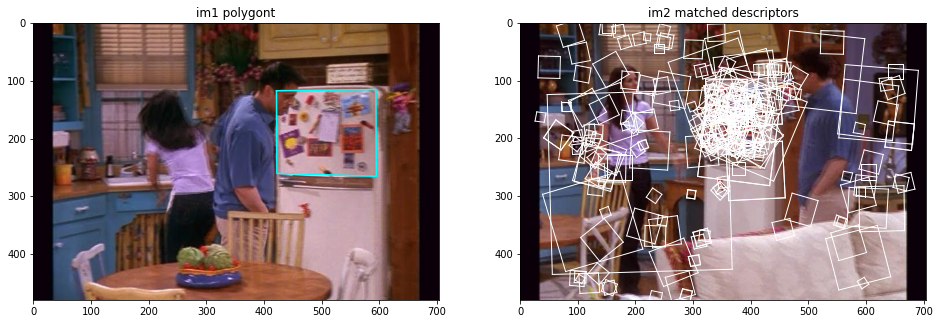

In [42]:
####################################################################
# TODO: Write code to complete the steps described above.          #
####################################################################
mat = scipy.io.loadmat("twoFrameData.mat")
im1 = mat["im1"]
im2 = mat["im2"]
region = np.load("gen/region.npy")
points = np.load("gen/points.npy")
indices = match_descriptors(mat["descriptors1"][points], mat["descriptors2"])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(im1)
x, y = list(region[:, 0]), list(region[:, 1])
x.append(x[0])
y.append(y[0])
ax[0].plot(x, y, color='cyan')

ax[1].imshow(im2)
rect = displaySIFTPatches(mat["positions2"][indices], mat["scales2"][indices], mat["orients2"][indices])
for j in range(len(rect)):
    ax[1].plot(
        [rect[j][0][1], rect[j][1][1]],
        [rect[j][0][0], rect[j][1][0]],
        color="white",
        linestyle="-",
        linewidth=1,
    )
    ax[1].plot(
        [rect[j][1][1], rect[j][2][1]],
        [rect[j][1][0], rect[j][2][0]],
        color="white",
        linestyle="-",
        linewidth=1,
    )
    ax[1].plot(
        [rect[j][2][1], rect[j][3][1]],
        [rect[j][2][0], rect[j][3][0]],
        color="white",
        linestyle="-",
        linewidth=1,
    )
    ax[1].plot(
        [rect[j][3][1], rect[j][0][1]],
        [rect[j][3][0], rect[j][0][0]],
        color="white",
        linestyle="-",
        linewidth=1,
    )
ax[1].set_xlim(0, im2.shape[1])
ax[1].set_ylim(0, im2.shape[0])
plt.gca().invert_yaxis()

ax[0].set_title("im1 polygont")
ax[1].set_title("im2 matched descriptors")

plt.show()
####################################################################
#                        END OF YOUR CODE                          #
####################################################################

### 2.2. Visualizing the vocabulary [20 pts]:

In this part we will build a visual vocabulary.

#### Steps

1. Cluster a large, representative random sample of SIFT descriptors from some portion of the frames using k-means. Let the `k` centers be the visual words. The value of `k` is a free parameter. For this data something like `k = 1500` should work, but feel free to play with this parameter. For clustering, refer to `kmeans` function in **sklearn**. 

   > **Note:** You may run out of memory if you use all the provided SIFT descriptors to build the vocabulary.

   Save the cluster centers to `vocabulary.npy` so that you can use the vocabulary again in other parts of the assignment.


2. Display example image patches associated with any two of the visual words i.e choose raw SIFT descriptors that are nearest to each of the chosen visual words. Choose the two words such that they are distinct to illustrate what the different words are capturing, and display enough patch examples so the word content is evident (e.g., 25 patches per word). 

> Refer to the helper functions `getPatchFromSIFTParameters.py` to display patches and `dist2.py` for fast distance computation.


3. Describe what you see in your answer sheet

#### Deliverables

- [x] Display patches corresponding with two visual words in your answer sheet.
- [x] Discuss the results in your answer sheet.

#### Train Vocabulary

In [36]:
fhs = glob.glob("data/sift/*.mat")
fhs = [os.path.basename(name) for name in fhs]
size = 1000
random.shuffle(fhs)
sample = fhs[:size]

data = []
for fh in sample:
    descriptors = scipy.io.loadmat(os.path.join('data/sift/', fh))['descriptors']
    data += list(descriptors)
    
kmeans = MiniBatchKMeans(n_clusters=2000, verbose=True, batch_size=100)
mat = np.array(data)
kmeans.fit(mat)
np.save(f'gen/vocabulary_{size}.npy', kmeans.cluster_centers_)
pickle.dump(kmeans, open(f'gen/vocabulary_{size}.pkl', 'wb'))

Loading 1000 random frames...
Loading friends_0000003677.jpeg.mat...
Loading friends_0000004535.jpeg.mat...
Loading friends_0000006225.jpeg.mat...
Loading friends_0000005928.jpeg.mat...
Loading friends_0000002904.jpeg.mat...
Loading friends_0000000989.jpeg.mat...
Loading friends_0000004834.jpeg.mat...
Loading friends_0000003396.jpeg.mat...
Loading friends_0000004238.jpeg.mat...
Loading friends_0000004089.jpeg.mat...
Loading friends_0000006360.jpeg.mat...
Loading friends_0000003728.jpeg.mat...
Loading friends_0000003525.jpeg.mat...
Loading friends_0000005615.jpeg.mat...
Loading friends_0000001193.jpeg.mat...
Loading friends_0000001100.jpeg.mat...
Loading friends_0000005003.jpeg.mat...
Loading friends_0000000092.jpeg.mat...
Loading friends_0000005321.jpeg.mat...
Loading friends_0000005998.jpeg.mat...
Loading friends_0000001842.jpeg.mat...
Loading friends_0000003898.jpeg.mat...
Loading friends_0000003892.jpeg.mat...
Loading friends_0000006349.jpeg.mat...
Loading friends_0000005563.jpeg.ma

Loading friends_0000003511.jpeg.mat...
Loading friends_0000006393.jpeg.mat...
Loading friends_0000004291.jpeg.mat...
Loading friends_0000002437.jpeg.mat...
Loading friends_0000001263.jpeg.mat...
Loading friends_0000000970.jpeg.mat...
Loading friends_0000006220.jpeg.mat...
Loading friends_0000000442.jpeg.mat...
Loading friends_0000000206.jpeg.mat...
Loading friends_0000003066.jpeg.mat...
Loading friends_0000002330.jpeg.mat...
Loading friends_0000001687.jpeg.mat...
Loading friends_0000005622.jpeg.mat...
Loading friends_0000001969.jpeg.mat...
Loading friends_0000005577.jpeg.mat...
Loading friends_0000004037.jpeg.mat...
Loading friends_0000002534.jpeg.mat...
Loading friends_0000005722.jpeg.mat...
Loading friends_0000003901.jpeg.mat...
Loading friends_0000001123.jpeg.mat...
Loading friends_0000002999.jpeg.mat...
Loading friends_0000002159.jpeg.mat...
Loading friends_0000001356.jpeg.mat...
Loading friends_0000005826.jpeg.mat...
Loading friends_0000001710.jpeg.mat...
Loading friends_000000060

Loading friends_0000003656.jpeg.mat...
Loading friends_0000002469.jpeg.mat...
Loading friends_0000002891.jpeg.mat...
Loading friends_0000004064.jpeg.mat...
Loading friends_0000002944.jpeg.mat...
Loading friends_0000006043.jpeg.mat...
Loading friends_0000004158.jpeg.mat...
Loading friends_0000000344.jpeg.mat...
Loading friends_0000005168.jpeg.mat...
Loading friends_0000004332.jpeg.mat...
Loading friends_0000000504.jpeg.mat...
Loading friends_0000005181.jpeg.mat...
Loading friends_0000002659.jpeg.mat...
Loading friends_0000005669.jpeg.mat...
Loading friends_0000004698.jpeg.mat...
Loading friends_0000001807.jpeg.mat...
Loading friends_0000001786.jpeg.mat...
Loading friends_0000004418.jpeg.mat...
Loading friends_0000003104.jpeg.mat...
Loading friends_0000001952.jpeg.mat...
Loading friends_0000000924.jpeg.mat...
Loading friends_0000006032.jpeg.mat...
Loading friends_0000005626.jpeg.mat...
Loading friends_0000002126.jpeg.mat...
Loading friends_0000004568.jpeg.mat...
Loading friends_000000176

Loading friends_0000005601.jpeg.mat...
Loading friends_0000000390.jpeg.mat...
Loading friends_0000005583.jpeg.mat...
Loading friends_0000005021.jpeg.mat...
Loading friends_0000000111.jpeg.mat...
Loading friends_0000005695.jpeg.mat...
Loading friends_0000006077.jpeg.mat...
Loading friends_0000000300.jpeg.mat...
Loading friends_0000002140.jpeg.mat...
Loading friends_0000004689.jpeg.mat...
Loading friends_0000005445.jpeg.mat...
Loading friends_0000005636.jpeg.mat...
Loading friends_0000006320.jpeg.mat...
Loading friends_0000001229.jpeg.mat...
Loading friends_0000003019.jpeg.mat...
Loading friends_0000004896.jpeg.mat...
Loading friends_0000000247.jpeg.mat...
Loading friends_0000000560.jpeg.mat...
Loading friends_0000001078.jpeg.mat...
Loading friends_0000006309.jpeg.mat...
Loading friends_0000003717.jpeg.mat...
Loading friends_0000006185.jpeg.mat...
Loading friends_0000004866.jpeg.mat...
Loading friends_0000003220.jpeg.mat...
Loading friends_0000000201.jpeg.mat...
Loading friends_000000562

Loading friends_0000001586.jpeg.mat...
Loading friends_0000002416.jpeg.mat...
Loading friends_0000002654.jpeg.mat...
Loading friends_0000003591.jpeg.mat...
Loading friends_0000005317.jpeg.mat...
Loading friends_0000006508.jpeg.mat...
Loading friends_0000000865.jpeg.mat...
Loading friends_0000006314.jpeg.mat...
Loading friends_0000000871.jpeg.mat...
Loading friends_0000003793.jpeg.mat...
Loading friends_0000003985.jpeg.mat...
Loading friends_0000002861.jpeg.mat...
Loading friends_0000004033.jpeg.mat...
Loading friends_0000001301.jpeg.mat...
Loading friends_0000000737.jpeg.mat...
Loading friends_0000002333.jpeg.mat...
Loading friends_0000000397.jpeg.mat...
Loading friends_0000006630.jpeg.mat...
Loading friends_0000002607.jpeg.mat...
Loading friends_0000005058.jpeg.mat...
Loading friends_0000002706.jpeg.mat...
Loading friends_0000003071.jpeg.mat...
Loading friends_0000005827.jpeg.mat...
Loading friends_0000003250.jpeg.mat...
Loading friends_0000002301.jpeg.mat...
Loading friends_000000507

/home/maki/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 1/3: 11.490918
Init 2/3 with method: k-means++


/home/maki/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 2/3: 8.395506
Init 3/3 with method: k-means++


/home/maki/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 3/3: 9.002383
Minibatch iteration 1/1122900: mean batch inertia: 0.347756, ewa inertia: 0.347756 
Minibatch iteration 2/1122900: mean batch inertia: 0.330293, ewa inertia: 0.347753 
Minibatch iteration 3/1122900: mean batch inertia: 0.349811, ewa inertia: 0.347754 
Minibatch iteration 4/1122900: mean batch inertia: 0.344868, ewa inertia: 0.347753 
Minibatch iteration 5/1122900: mean batch inertia: 0.341577, ewa inertia: 0.347752 
Minibatch iteration 6/1122900: mean batch inertia: 0.347562, ewa inertia: 0.347752 
Minibatch iteration 7/1122900: mean batch inertia: 0.332302, ewa inertia: 0.347749 
Minibatch iteration 8/1122900: mean batch inertia: 0.331621, ewa inertia: 0.347746 
Minibatch iteration 9/1122900: mean batch inertia: 0.328245, ewa inertia: 0.347743 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/1122900: mean batch inertia: 0.350672, ewa inertia: 0.347743 
Minibatch iteration 11/1122900: mean batch inertia: 0.314082, ewa inertia: 0.3

Minibatch iteration 95/1122900: mean batch inertia: 0.286908, ewa inertia: 0.346970 
Minibatch iteration 96/1122900: mean batch inertia: 0.298089, ewa inertia: 0.346962 
Minibatch iteration 97/1122900: mean batch inertia: 0.284404, ewa inertia: 0.346950 
Minibatch iteration 98/1122900: mean batch inertia: 0.284596, ewa inertia: 0.346939 
Minibatch iteration 99/1122900: mean batch inertia: 0.272013, ewa inertia: 0.346926 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 100/1122900: mean batch inertia: 0.275346, ewa inertia: 0.346913 
Minibatch iteration 101/1122900: mean batch inertia: 0.281054, ewa inertia: 0.346902 
Minibatch iteration 102/1122900: mean batch inertia: 0.270502, ewa inertia: 0.346888 
Minibatch iteration 103/1122900: mean batch inertia: 0.262179, ewa inertia: 0.346873 
Minibatch iteration 104/1122900: mean batch inertia: 0.273734, ewa inertia: 0.346860 
Minibatch iteration 105/1122900: mean batch inertia: 0.288686, ewa inertia: 0.346849 
Minibatch

Minibatch iteration 195/1122900: mean batch inertia: 0.256176, ewa inertia: 0.345687 
Minibatch iteration 196/1122900: mean batch inertia: 0.251956, ewa inertia: 0.345670 
Minibatch iteration 197/1122900: mean batch inertia: 0.271382, ewa inertia: 0.345657 
Minibatch iteration 198/1122900: mean batch inertia: 0.252881, ewa inertia: 0.345641 
Minibatch iteration 199/1122900: mean batch inertia: 0.268205, ewa inertia: 0.345627 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 200/1122900: mean batch inertia: 0.260569, ewa inertia: 0.345612 
Minibatch iteration 201/1122900: mean batch inertia: 0.273498, ewa inertia: 0.345599 
Minibatch iteration 202/1122900: mean batch inertia: 0.264019, ewa inertia: 0.345584 
Minibatch iteration 203/1122900: mean batch inertia: 0.278710, ewa inertia: 0.345572 
Minibatch iteration 204/1122900: mean batch inertia: 0.254056, ewa inertia: 0.345556 
Minibatch iteration 205/1122900: mean batch inertia: 0.280950, ewa inertia: 0.345544 
Mini

Minibatch iteration 300/1122900: mean batch inertia: 0.261863, ewa inertia: 0.344196 
Minibatch iteration 301/1122900: mean batch inertia: 0.264191, ewa inertia: 0.344181 
Minibatch iteration 302/1122900: mean batch inertia: 0.269030, ewa inertia: 0.344168 
Minibatch iteration 303/1122900: mean batch inertia: 0.264017, ewa inertia: 0.344154 
Minibatch iteration 304/1122900: mean batch inertia: 0.278531, ewa inertia: 0.344142 
Minibatch iteration 305/1122900: mean batch inertia: 0.266705, ewa inertia: 0.344128 
Minibatch iteration 306/1122900: mean batch inertia: 0.247520, ewa inertia: 0.344111 
Minibatch iteration 307/1122900: mean batch inertia: 0.265793, ewa inertia: 0.344097 
Minibatch iteration 308/1122900: mean batch inertia: 0.252856, ewa inertia: 0.344081 
Minibatch iteration 309/1122900: mean batch inertia: 0.255015, ewa inertia: 0.344065 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 310/1122900: mean batch inertia: 0.273878, ewa inertia: 0.344053 
Mini

Minibatch iteration 396/1122900: mean batch inertia: 0.272023, ewa inertia: 0.342779 
Minibatch iteration 397/1122900: mean batch inertia: 0.266685, ewa inertia: 0.342765 
Minibatch iteration 398/1122900: mean batch inertia: 0.251294, ewa inertia: 0.342749 
Minibatch iteration 399/1122900: mean batch inertia: 0.271357, ewa inertia: 0.342736 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 400/1122900: mean batch inertia: 0.261061, ewa inertia: 0.342722 
Minibatch iteration 401/1122900: mean batch inertia: 0.249744, ewa inertia: 0.342705 
Minibatch iteration 402/1122900: mean batch inertia: 0.251071, ewa inertia: 0.342689 
Minibatch iteration 403/1122900: mean batch inertia: 0.263079, ewa inertia: 0.342675 
Minibatch iteration 404/1122900: mean batch inertia: 0.262869, ewa inertia: 0.342660 
Minibatch iteration 405/1122900: mean batch inertia: 0.266818, ewa inertia: 0.342647 
Minibatch iteration 406/1122900: mean batch inertia: 0.264203, ewa inertia: 0.342633 
Mini

Minibatch iteration 499/1122900: mean batch inertia: 0.260538, ewa inertia: 0.341237 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 500/1122900: mean batch inertia: 0.241389, ewa inertia: 0.341219 
Minibatch iteration 501/1122900: mean batch inertia: 0.265871, ewa inertia: 0.341206 
Minibatch iteration 502/1122900: mean batch inertia: 0.255916, ewa inertia: 0.341190 
Minibatch iteration 503/1122900: mean batch inertia: 0.267267, ewa inertia: 0.341177 
Minibatch iteration 504/1122900: mean batch inertia: 0.245311, ewa inertia: 0.341160 
Minibatch iteration 505/1122900: mean batch inertia: 0.268666, ewa inertia: 0.341147 
Minibatch iteration 506/1122900: mean batch inertia: 0.259056, ewa inertia: 0.341133 
Minibatch iteration 507/1122900: mean batch inertia: 0.244679, ewa inertia: 0.341115 
Minibatch iteration 508/1122900: mean batch inertia: 0.264290, ewa inertia: 0.341102 
Minibatch iteration 509/1122900: mean batch inertia: 0.265865, ewa inertia: 0.341088 
[Min

Minibatch iteration 592/1122900: mean batch inertia: 0.261829, ewa inertia: 0.339805 
Minibatch iteration 593/1122900: mean batch inertia: 0.243596, ewa inertia: 0.339788 
Minibatch iteration 594/1122900: mean batch inertia: 0.248587, ewa inertia: 0.339772 
Minibatch iteration 595/1122900: mean batch inertia: 0.245238, ewa inertia: 0.339755 
Minibatch iteration 596/1122900: mean batch inertia: 0.251683, ewa inertia: 0.339739 
Minibatch iteration 597/1122900: mean batch inertia: 0.257908, ewa inertia: 0.339725 
Minibatch iteration 598/1122900: mean batch inertia: 0.250534, ewa inertia: 0.339709 
Minibatch iteration 599/1122900: mean batch inertia: 0.253852, ewa inertia: 0.339694 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 600/1122900: mean batch inertia: 0.240831, ewa inertia: 0.339676 
Minibatch iteration 601/1122900: mean batch inertia: 0.269134, ewa inertia: 0.339664 
Minibatch iteration 602/1122900: mean batch inertia: 0.253304, ewa inertia: 0.339648 
Mini

Minibatch iteration 691/1122900: mean batch inertia: 0.255199, ewa inertia: 0.338259 
Minibatch iteration 692/1122900: mean batch inertia: 0.247406, ewa inertia: 0.338243 
Minibatch iteration 693/1122900: mean batch inertia: 0.253337, ewa inertia: 0.338228 
Minibatch iteration 694/1122900: mean batch inertia: 0.263535, ewa inertia: 0.338214 
Minibatch iteration 695/1122900: mean batch inertia: 0.260441, ewa inertia: 0.338200 
Minibatch iteration 696/1122900: mean batch inertia: 0.258295, ewa inertia: 0.338186 
Minibatch iteration 697/1122900: mean batch inertia: 0.253849, ewa inertia: 0.338171 
Minibatch iteration 698/1122900: mean batch inertia: 0.257791, ewa inertia: 0.338157 
Minibatch iteration 699/1122900: mean batch inertia: 0.237521, ewa inertia: 0.338139 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 700/1122900: mean batch inertia: 0.262536, ewa inertia: 0.338125 
Minibatch iteration 701/1122900: mean batch inertia: 0.250136, ewa inertia: 0.338110 
Mini

Minibatch iteration 799/1122900: mean batch inertia: 0.240508, ewa inertia: 0.336588 
Minibatch iteration 800/1122900: mean batch inertia: 0.257484, ewa inertia: 0.336574 
Minibatch iteration 801/1122900: mean batch inertia: 0.256212, ewa inertia: 0.336559 
Minibatch iteration 802/1122900: mean batch inertia: 0.238785, ewa inertia: 0.336542 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 803/1122900: mean batch inertia: 0.245072, ewa inertia: 0.336526 
Minibatch iteration 804/1122900: mean batch inertia: 0.261332, ewa inertia: 0.336512 
Minibatch iteration 805/1122900: mean batch inertia: 0.242841, ewa inertia: 0.336496 
Minibatch iteration 806/1122900: mean batch inertia: 0.260360, ewa inertia: 0.336482 
Minibatch iteration 807/1122900: mean batch inertia: 0.248568, ewa inertia: 0.336466 
Minibatch iteration 808/1122900: mean batch inertia: 0.251073, ewa inertia: 0.336451 
Minibatch iteration 809/1122900: mean batch inertia: 0.251581, ewa inertia: 0.336436 
Mini

Minibatch iteration 900/1122900: mean batch inertia: 0.233593, ewa inertia: 0.335002 
Minibatch iteration 901/1122900: mean batch inertia: 0.244744, ewa inertia: 0.334986 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 902/1122900: mean batch inertia: 0.260962, ewa inertia: 0.334973 
Minibatch iteration 903/1122900: mean batch inertia: 0.239485, ewa inertia: 0.334956 
Minibatch iteration 904/1122900: mean batch inertia: 0.242865, ewa inertia: 0.334939 
Minibatch iteration 905/1122900: mean batch inertia: 0.245558, ewa inertia: 0.334923 
Minibatch iteration 906/1122900: mean batch inertia: 0.252219, ewa inertia: 0.334908 
Minibatch iteration 907/1122900: mean batch inertia: 0.262804, ewa inertia: 0.334896 
Minibatch iteration 908/1122900: mean batch inertia: 0.233082, ewa inertia: 0.334878 
Minibatch iteration 909/1122900: mean batch inertia: 0.244929, ewa inertia: 0.334861 
Minibatch iteration 910/1122900: mean batch inertia: 0.259888, ewa inertia: 0.334848 
Mini

Minibatch iteration 998/1122900: mean batch inertia: 0.240034, ewa inertia: 0.333472 
Minibatch iteration 999/1122900: mean batch inertia: 0.235377, ewa inertia: 0.333454 
Minibatch iteration 1000/1122900: mean batch inertia: 0.246970, ewa inertia: 0.333439 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1001/1122900: mean batch inertia: 0.250353, ewa inertia: 0.333424 
Minibatch iteration 1002/1122900: mean batch inertia: 0.244879, ewa inertia: 0.333408 
Minibatch iteration 1003/1122900: mean batch inertia: 0.231489, ewa inertia: 0.333390 
Minibatch iteration 1004/1122900: mean batch inertia: 0.243844, ewa inertia: 0.333374 
Minibatch iteration 1005/1122900: mean batch inertia: 0.258399, ewa inertia: 0.333361 
Minibatch iteration 1006/1122900: mean batch inertia: 0.264670, ewa inertia: 0.333349 
Minibatch iteration 1007/1122900: mean batch inertia: 0.245260, ewa inertia: 0.333333 
Minibatch iteration 1008/1122900: mean batch inertia: 0.251995, ewa inertia: 0.333

Minibatch iteration 1098/1122900: mean batch inertia: 0.230712, ewa inertia: 0.331914 
Minibatch iteration 1099/1122900: mean batch inertia: 0.229261, ewa inertia: 0.331895 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1100/1122900: mean batch inertia: 0.237954, ewa inertia: 0.331879 
Minibatch iteration 1101/1122900: mean batch inertia: 0.241217, ewa inertia: 0.331863 
Minibatch iteration 1102/1122900: mean batch inertia: 0.245415, ewa inertia: 0.331847 
Minibatch iteration 1103/1122900: mean batch inertia: 0.249081, ewa inertia: 0.331832 
Minibatch iteration 1104/1122900: mean batch inertia: 0.252733, ewa inertia: 0.331818 
Minibatch iteration 1105/1122900: mean batch inertia: 0.239285, ewa inertia: 0.331802 
Minibatch iteration 1106/1122900: mean batch inertia: 0.241357, ewa inertia: 0.331786 
Minibatch iteration 1107/1122900: mean batch inertia: 0.243036, ewa inertia: 0.331770 
Minibatch iteration 1108/1122900: mean batch inertia: 0.246092, ewa inertia: 0.3

Minibatch iteration 1194/1122900: mean batch inertia: 0.241587, ewa inertia: 0.330437 
Minibatch iteration 1195/1122900: mean batch inertia: 0.232362, ewa inertia: 0.330419 
Minibatch iteration 1196/1122900: mean batch inertia: 0.249351, ewa inertia: 0.330405 
Minibatch iteration 1197/1122900: mean batch inertia: 0.252670, ewa inertia: 0.330391 
Minibatch iteration 1198/1122900: mean batch inertia: 0.250734, ewa inertia: 0.330377 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1199/1122900: mean batch inertia: 0.253667, ewa inertia: 0.330363 
Minibatch iteration 1200/1122900: mean batch inertia: 0.250044, ewa inertia: 0.330349 
Minibatch iteration 1201/1122900: mean batch inertia: 0.256217, ewa inertia: 0.330335 
Minibatch iteration 1202/1122900: mean batch inertia: 0.238781, ewa inertia: 0.330319 
Minibatch iteration 1203/1122900: mean batch inertia: 0.241476, ewa inertia: 0.330303 
Minibatch iteration 1204/1122900: mean batch inertia: 0.230266, ewa inertia: 0.3

Minibatch iteration 1291/1122900: mean batch inertia: 0.246227, ewa inertia: 0.328975 
Minibatch iteration 1292/1122900: mean batch inertia: 0.240211, ewa inertia: 0.328959 
Minibatch iteration 1293/1122900: mean batch inertia: 0.241555, ewa inertia: 0.328944 
Minibatch iteration 1294/1122900: mean batch inertia: 0.252017, ewa inertia: 0.328930 
Minibatch iteration 1295/1122900: mean batch inertia: 0.245141, ewa inertia: 0.328915 
Minibatch iteration 1296/1122900: mean batch inertia: 0.248482, ewa inertia: 0.328901 
Minibatch iteration 1297/1122900: mean batch inertia: 0.230123, ewa inertia: 0.328883 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1298/1122900: mean batch inertia: 0.248628, ewa inertia: 0.328869 
Minibatch iteration 1299/1122900: mean batch inertia: 0.248288, ewa inertia: 0.328855 
Minibatch iteration 1300/1122900: mean batch inertia: 0.238368, ewa inertia: 0.328838 
Minibatch iteration 1301/1122900: mean batch inertia: 0.243007, ewa inertia: 0.3

Minibatch iteration 1387/1122900: mean batch inertia: 0.243264, ewa inertia: 0.327514 
Minibatch iteration 1388/1122900: mean batch inertia: 0.239079, ewa inertia: 0.327498 
Minibatch iteration 1389/1122900: mean batch inertia: 0.241946, ewa inertia: 0.327483 
Minibatch iteration 1390/1122900: mean batch inertia: 0.255773, ewa inertia: 0.327470 
Minibatch iteration 1391/1122900: mean batch inertia: 0.246032, ewa inertia: 0.327455 
Minibatch iteration 1392/1122900: mean batch inertia: 0.233074, ewa inertia: 0.327439 
Minibatch iteration 1393/1122900: mean batch inertia: 0.234692, ewa inertia: 0.327422 
Minibatch iteration 1394/1122900: mean batch inertia: 0.234108, ewa inertia: 0.327405 
Minibatch iteration 1395/1122900: mean batch inertia: 0.255225, ewa inertia: 0.327393 
Minibatch iteration 1396/1122900: mean batch inertia: 0.245776, ewa inertia: 0.327378 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1397/1122900: mean batch inertia: 0.236776, ewa inertia: 0.3

Minibatch iteration 1479/1122900: mean batch inertia: 0.232391, ewa inertia: 0.326131 
Minibatch iteration 1480/1122900: mean batch inertia: 0.249956, ewa inertia: 0.326117 
Minibatch iteration 1481/1122900: mean batch inertia: 0.238126, ewa inertia: 0.326101 
Minibatch iteration 1482/1122900: mean batch inertia: 0.240423, ewa inertia: 0.326086 
Minibatch iteration 1483/1122900: mean batch inertia: 0.251750, ewa inertia: 0.326073 
Minibatch iteration 1484/1122900: mean batch inertia: 0.249588, ewa inertia: 0.326059 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1485/1122900: mean batch inertia: 0.236582, ewa inertia: 0.326043 
Minibatch iteration 1486/1122900: mean batch inertia: 0.231692, ewa inertia: 0.326027 
Minibatch iteration 1487/1122900: mean batch inertia: 0.233981, ewa inertia: 0.326010 
Minibatch iteration 1488/1122900: mean batch inertia: 0.228394, ewa inertia: 0.325993 
Minibatch iteration 1489/1122900: mean batch inertia: 0.235298, ewa inertia: 0.3

Minibatch iteration 1582/1122900: mean batch inertia: 0.230255, ewa inertia: 0.324581 
Minibatch iteration 1583/1122900: mean batch inertia: 0.235802, ewa inertia: 0.324565 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1584/1122900: mean batch inertia: 0.229936, ewa inertia: 0.324548 
Minibatch iteration 1585/1122900: mean batch inertia: 0.241190, ewa inertia: 0.324533 
Minibatch iteration 1586/1122900: mean batch inertia: 0.246212, ewa inertia: 0.324519 
Minibatch iteration 1587/1122900: mean batch inertia: 0.237601, ewa inertia: 0.324504 
Minibatch iteration 1588/1122900: mean batch inertia: 0.232985, ewa inertia: 0.324487 
Minibatch iteration 1589/1122900: mean batch inertia: 0.245514, ewa inertia: 0.324473 
Minibatch iteration 1590/1122900: mean batch inertia: 0.230293, ewa inertia: 0.324457 
Minibatch iteration 1591/1122900: mean batch inertia: 0.251876, ewa inertia: 0.324444 
Minibatch iteration 1592/1122900: mean batch inertia: 0.236010, ewa inertia: 0.3

Minibatch iteration 1686/1122900: mean batch inertia: 0.243830, ewa inertia: 0.323041 
Minibatch iteration 1687/1122900: mean batch inertia: 0.256897, ewa inertia: 0.323029 
Minibatch iteration 1688/1122900: mean batch inertia: 0.239052, ewa inertia: 0.323014 
Minibatch iteration 1689/1122900: mean batch inertia: 0.230388, ewa inertia: 0.322998 
Minibatch iteration 1690/1122900: mean batch inertia: 0.247827, ewa inertia: 0.322984 
Minibatch iteration 1691/1122900: mean batch inertia: 0.244255, ewa inertia: 0.322970 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1692/1122900: mean batch inertia: 0.244191, ewa inertia: 0.322956 
Minibatch iteration 1693/1122900: mean batch inertia: 0.230674, ewa inertia: 0.322940 
Minibatch iteration 1694/1122900: mean batch inertia: 0.239129, ewa inertia: 0.322925 
Minibatch iteration 1695/1122900: mean batch inertia: 0.263882, ewa inertia: 0.322914 
Minibatch iteration 1696/1122900: mean batch inertia: 0.239498, ewa inertia: 0.3

Minibatch iteration 1790/1122900: mean batch inertia: 0.248002, ewa inertia: 0.321551 
Minibatch iteration 1791/1122900: mean batch inertia: 0.225140, ewa inertia: 0.321534 
Minibatch iteration 1792/1122900: mean batch inertia: 0.259728, ewa inertia: 0.321523 
Minibatch iteration 1793/1122900: mean batch inertia: 0.223310, ewa inertia: 0.321505 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1794/1122900: mean batch inertia: 0.234666, ewa inertia: 0.321490 
Minibatch iteration 1795/1122900: mean batch inertia: 0.250122, ewa inertia: 0.321477 
Minibatch iteration 1796/1122900: mean batch inertia: 0.252716, ewa inertia: 0.321465 
Minibatch iteration 1797/1122900: mean batch inertia: 0.233679, ewa inertia: 0.321449 
Minibatch iteration 1798/1122900: mean batch inertia: 0.250457, ewa inertia: 0.321437 
Minibatch iteration 1799/1122900: mean batch inertia: 0.244714, ewa inertia: 0.321423 
Minibatch iteration 1800/1122900: mean batch inertia: 0.239516, ewa inertia: 0.3

Minibatch iteration 1891/1122900: mean batch inertia: 0.227755, ewa inertia: 0.320082 
Minibatch iteration 1892/1122900: mean batch inertia: 0.237178, ewa inertia: 0.320067 
Minibatch iteration 1893/1122900: mean batch inertia: 0.231779, ewa inertia: 0.320051 
Minibatch iteration 1894/1122900: mean batch inertia: 0.226427, ewa inertia: 0.320034 
Minibatch iteration 1895/1122900: mean batch inertia: 0.255818, ewa inertia: 0.320023 
Minibatch iteration 1896/1122900: mean batch inertia: 0.242650, ewa inertia: 0.320009 
Minibatch iteration 1897/1122900: mean batch inertia: 0.246354, ewa inertia: 0.319996 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1898/1122900: mean batch inertia: 0.230037, ewa inertia: 0.319980 
Minibatch iteration 1899/1122900: mean batch inertia: 0.230936, ewa inertia: 0.319964 
Minibatch iteration 1900/1122900: mean batch inertia: 0.246550, ewa inertia: 0.319951 
Minibatch iteration 1901/1122900: mean batch inertia: 0.246991, ewa inertia: 0.3

Minibatch iteration 1983/1122900: mean batch inertia: 0.230900, ewa inertia: 0.318760 
Minibatch iteration 1984/1122900: mean batch inertia: 0.237672, ewa inertia: 0.318745 
Minibatch iteration 1985/1122900: mean batch inertia: 0.237093, ewa inertia: 0.318731 
Minibatch iteration 1986/1122900: mean batch inertia: 0.249647, ewa inertia: 0.318719 
Minibatch iteration 1987/1122900: mean batch inertia: 0.240703, ewa inertia: 0.318705 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1988/1122900: mean batch inertia: 0.252210, ewa inertia: 0.318693 
Minibatch iteration 1989/1122900: mean batch inertia: 0.240542, ewa inertia: 0.318679 
Minibatch iteration 1990/1122900: mean batch inertia: 0.229210, ewa inertia: 0.318663 
Minibatch iteration 1991/1122900: mean batch inertia: 0.245936, ewa inertia: 0.318650 
Minibatch iteration 1992/1122900: mean batch inertia: 0.223259, ewa inertia: 0.318633 
Minibatch iteration 1993/1122900: mean batch inertia: 0.253208, ewa inertia: 0.3

Minibatch iteration 2076/1122900: mean batch inertia: 0.238881, ewa inertia: 0.317450 
Minibatch iteration 2077/1122900: mean batch inertia: 0.253826, ewa inertia: 0.317439 
Minibatch iteration 2078/1122900: mean batch inertia: 0.251566, ewa inertia: 0.317427 
Minibatch iteration 2079/1122900: mean batch inertia: 0.235417, ewa inertia: 0.317412 
Minibatch iteration 2080/1122900: mean batch inertia: 0.232376, ewa inertia: 0.317397 
Minibatch iteration 2081/1122900: mean batch inertia: 0.244253, ewa inertia: 0.317384 
Minibatch iteration 2082/1122900: mean batch inertia: 0.230015, ewa inertia: 0.317368 
Minibatch iteration 2083/1122900: mean batch inertia: 0.244017, ewa inertia: 0.317355 
Minibatch iteration 2084/1122900: mean batch inertia: 0.240001, ewa inertia: 0.317342 
Minibatch iteration 2085/1122900: mean batch inertia: 0.254585, ewa inertia: 0.317330 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2086/1122900: mean batch inertia: 0.235134, ewa inertia: 0.3

Minibatch iteration 2176/1122900: mean batch inertia: 0.236684, ewa inertia: 0.316062 
Minibatch iteration 2177/1122900: mean batch inertia: 0.240313, ewa inertia: 0.316048 
Minibatch iteration 2178/1122900: mean batch inertia: 0.256037, ewa inertia: 0.316038 
Minibatch iteration 2179/1122900: mean batch inertia: 0.235629, ewa inertia: 0.316023 
Minibatch iteration 2180/1122900: mean batch inertia: 0.242657, ewa inertia: 0.316010 
Minibatch iteration 2181/1122900: mean batch inertia: 0.241669, ewa inertia: 0.315997 
Minibatch iteration 2182/1122900: mean batch inertia: 0.236178, ewa inertia: 0.315983 
Minibatch iteration 2183/1122900: mean batch inertia: 0.222401, ewa inertia: 0.315966 
Minibatch iteration 2184/1122900: mean batch inertia: 0.246819, ewa inertia: 0.315954 
Minibatch iteration 2185/1122900: mean batch inertia: 0.226960, ewa inertia: 0.315938 
Minibatch iteration 2186/1122900: mean batch inertia: 0.245293, ewa inertia: 0.315926 
Minibatch iteration 2187/1122900: mean batc

Minibatch iteration 2281/1122900: mean batch inertia: 0.248129, ewa inertia: 0.314667 
Minibatch iteration 2282/1122900: mean batch inertia: 0.227551, ewa inertia: 0.314651 
Minibatch iteration 2283/1122900: mean batch inertia: 0.251625, ewa inertia: 0.314640 
Minibatch iteration 2284/1122900: mean batch inertia: 0.236762, ewa inertia: 0.314626 
Minibatch iteration 2285/1122900: mean batch inertia: 0.237655, ewa inertia: 0.314613 
Minibatch iteration 2286/1122900: mean batch inertia: 0.243071, ewa inertia: 0.314600 
Minibatch iteration 2287/1122900: mean batch inertia: 0.253998, ewa inertia: 0.314589 
Minibatch iteration 2288/1122900: mean batch inertia: 0.219370, ewa inertia: 0.314572 
Minibatch iteration 2289/1122900: mean batch inertia: 0.239870, ewa inertia: 0.314559 
Minibatch iteration 2290/1122900: mean batch inertia: 0.238603, ewa inertia: 0.314545 
Minibatch iteration 2291/1122900: mean batch inertia: 0.240374, ewa inertia: 0.314532 
Minibatch iteration 2292/1122900: mean batc

Minibatch iteration 2383/1122900: mean batch inertia: 0.219327, ewa inertia: 0.313285 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2384/1122900: mean batch inertia: 0.246195, ewa inertia: 0.313273 
Minibatch iteration 2385/1122900: mean batch inertia: 0.242120, ewa inertia: 0.313260 
Minibatch iteration 2386/1122900: mean batch inertia: 0.235900, ewa inertia: 0.313246 
Minibatch iteration 2387/1122900: mean batch inertia: 0.237843, ewa inertia: 0.313233 
Minibatch iteration 2388/1122900: mean batch inertia: 0.237648, ewa inertia: 0.313219 
Minibatch iteration 2389/1122900: mean batch inertia: 0.229841, ewa inertia: 0.313205 
Minibatch iteration 2390/1122900: mean batch inertia: 0.230504, ewa inertia: 0.313190 
Minibatch iteration 2391/1122900: mean batch inertia: 0.238597, ewa inertia: 0.313177 
Minibatch iteration 2392/1122900: mean batch inertia: 0.230188, ewa inertia: 0.313162 
Minibatch iteration 2393/1122900: mean batch inertia: 0.240125, ewa inertia: 0.3

Minibatch iteration 2481/1122900: mean batch inertia: 0.234837, ewa inertia: 0.311994 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2482/1122900: mean batch inertia: 0.221682, ewa inertia: 0.311978 
Minibatch iteration 2483/1122900: mean batch inertia: 0.230973, ewa inertia: 0.311963 
Minibatch iteration 2484/1122900: mean batch inertia: 0.232506, ewa inertia: 0.311949 
Minibatch iteration 2485/1122900: mean batch inertia: 0.236408, ewa inertia: 0.311936 
Minibatch iteration 2486/1122900: mean batch inertia: 0.241512, ewa inertia: 0.311923 
Minibatch iteration 2487/1122900: mean batch inertia: 0.239820, ewa inertia: 0.311910 
Minibatch iteration 2488/1122900: mean batch inertia: 0.225604, ewa inertia: 0.311895 
Minibatch iteration 2489/1122900: mean batch inertia: 0.237964, ewa inertia: 0.311882 
Minibatch iteration 2490/1122900: mean batch inertia: 0.235176, ewa inertia: 0.311868 
Minibatch iteration 2491/1122900: mean batch inertia: 0.236837, ewa inertia: 0.3

Minibatch iteration 2584/1122900: mean batch inertia: 0.227508, ewa inertia: 0.310630 
Minibatch iteration 2585/1122900: mean batch inertia: 0.239657, ewa inertia: 0.310618 
Minibatch iteration 2586/1122900: mean batch inertia: 0.232605, ewa inertia: 0.310604 
Minibatch iteration 2587/1122900: mean batch inertia: 0.241282, ewa inertia: 0.310591 
Minibatch iteration 2588/1122900: mean batch inertia: 0.245193, ewa inertia: 0.310580 
Minibatch iteration 2589/1122900: mean batch inertia: 0.219916, ewa inertia: 0.310564 
Minibatch iteration 2590/1122900: mean batch inertia: 0.224679, ewa inertia: 0.310548 
Minibatch iteration 2591/1122900: mean batch inertia: 0.214308, ewa inertia: 0.310531 
[MiniBatchKMeans] Reassigning 49 cluster centers.
Minibatch iteration 2592/1122900: mean batch inertia: 0.221522, ewa inertia: 0.310515 
Minibatch iteration 2593/1122900: mean batch inertia: 0.242370, ewa inertia: 0.310503 
Minibatch iteration 2594/1122900: mean batch inertia: 0.233035, ewa inertia: 0.3

Minibatch iteration 2679/1122900: mean batch inertia: 0.249086, ewa inertia: 0.309375 
Minibatch iteration 2680/1122900: mean batch inertia: 0.221306, ewa inertia: 0.309359 
Minibatch iteration 2681/1122900: mean batch inertia: 0.246320, ewa inertia: 0.309348 
Minibatch iteration 2682/1122900: mean batch inertia: 0.236277, ewa inertia: 0.309335 
Minibatch iteration 2683/1122900: mean batch inertia: 0.231022, ewa inertia: 0.309321 
Minibatch iteration 2684/1122900: mean batch inertia: 0.240399, ewa inertia: 0.309309 
Minibatch iteration 2685/1122900: mean batch inertia: 0.236641, ewa inertia: 0.309296 
Minibatch iteration 2686/1122900: mean batch inertia: 0.232487, ewa inertia: 0.309282 
Minibatch iteration 2687/1122900: mean batch inertia: 0.244402, ewa inertia: 0.309271 
Minibatch iteration 2688/1122900: mean batch inertia: 0.244458, ewa inertia: 0.309259 
Minibatch iteration 2689/1122900: mean batch inertia: 0.241610, ewa inertia: 0.309247 
Minibatch iteration 2690/1122900: mean batc

Minibatch iteration 2776/1122900: mean batch inertia: 0.239189, ewa inertia: 0.308152 
Minibatch iteration 2777/1122900: mean batch inertia: 0.241252, ewa inertia: 0.308140 
Minibatch iteration 2778/1122900: mean batch inertia: 0.233835, ewa inertia: 0.308127 
Minibatch iteration 2779/1122900: mean batch inertia: 0.230339, ewa inertia: 0.308113 
Minibatch iteration 2780/1122900: mean batch inertia: 0.233182, ewa inertia: 0.308099 
Minibatch iteration 2781/1122900: mean batch inertia: 0.238283, ewa inertia: 0.308087 
Minibatch iteration 2782/1122900: mean batch inertia: 0.246772, ewa inertia: 0.308076 
Minibatch iteration 2783/1122900: mean batch inertia: 0.234410, ewa inertia: 0.308063 
Minibatch iteration 2784/1122900: mean batch inertia: 0.239904, ewa inertia: 0.308051 
Minibatch iteration 2785/1122900: mean batch inertia: 0.235668, ewa inertia: 0.308038 
Minibatch iteration 2786/1122900: mean batch inertia: 0.240856, ewa inertia: 0.308026 
Minibatch iteration 2787/1122900: mean batc

Minibatch iteration 2873/1122900: mean batch inertia: 0.229805, ewa inertia: 0.306945 
Minibatch iteration 2874/1122900: mean batch inertia: 0.243410, ewa inertia: 0.306934 
Minibatch iteration 2875/1122900: mean batch inertia: 0.225030, ewa inertia: 0.306919 
Minibatch iteration 2876/1122900: mean batch inertia: 0.239929, ewa inertia: 0.306907 
Minibatch iteration 2877/1122900: mean batch inertia: 0.233731, ewa inertia: 0.306894 
Minibatch iteration 2878/1122900: mean batch inertia: 0.236044, ewa inertia: 0.306882 
Minibatch iteration 2879/1122900: mean batch inertia: 0.233452, ewa inertia: 0.306869 
Minibatch iteration 2880/1122900: mean batch inertia: 0.225784, ewa inertia: 0.306854 
Minibatch iteration 2881/1122900: mean batch inertia: 0.240829, ewa inertia: 0.306842 
Minibatch iteration 2882/1122900: mean batch inertia: 0.235856, ewa inertia: 0.306830 
Minibatch iteration 2883/1122900: mean batch inertia: 0.250568, ewa inertia: 0.306820 
Minibatch iteration 2884/1122900: mean batc

Minibatch iteration 2983/1122900: mean batch inertia: 0.234311, ewa inertia: 0.305596 
Minibatch iteration 2984/1122900: mean batch inertia: 0.231619, ewa inertia: 0.305583 
Minibatch iteration 2985/1122900: mean batch inertia: 0.236796, ewa inertia: 0.305570 
Minibatch iteration 2986/1122900: mean batch inertia: 0.232925, ewa inertia: 0.305557 
Minibatch iteration 2987/1122900: mean batch inertia: 0.235355, ewa inertia: 0.305545 
Minibatch iteration 2988/1122900: mean batch inertia: 0.240217, ewa inertia: 0.305533 
Minibatch iteration 2989/1122900: mean batch inertia: 0.234346, ewa inertia: 0.305521 
Minibatch iteration 2990/1122900: mean batch inertia: 0.237385, ewa inertia: 0.305508 
Minibatch iteration 2991/1122900: mean batch inertia: 0.236103, ewa inertia: 0.305496 
Minibatch iteration 2992/1122900: mean batch inertia: 0.247808, ewa inertia: 0.305486 
Minibatch iteration 2993/1122900: mean batch inertia: 0.248326, ewa inertia: 0.305476 
Minibatch iteration 2994/1122900: mean batc

Minibatch iteration 3083/1122900: mean batch inertia: 0.227547, ewa inertia: 0.304370 
Minibatch iteration 3084/1122900: mean batch inertia: 0.241557, ewa inertia: 0.304359 
Minibatch iteration 3085/1122900: mean batch inertia: 0.242641, ewa inertia: 0.304348 
Minibatch iteration 3086/1122900: mean batch inertia: 0.218011, ewa inertia: 0.304333 
Minibatch iteration 3087/1122900: mean batch inertia: 0.233999, ewa inertia: 0.304320 
Minibatch iteration 3088/1122900: mean batch inertia: 0.236540, ewa inertia: 0.304308 
Minibatch iteration 3089/1122900: mean batch inertia: 0.229748, ewa inertia: 0.304295 
Minibatch iteration 3090/1122900: mean batch inertia: 0.247549, ewa inertia: 0.304285 
Minibatch iteration 3091/1122900: mean batch inertia: 0.224097, ewa inertia: 0.304271 
Minibatch iteration 3092/1122900: mean batch inertia: 0.235992, ewa inertia: 0.304258 
Minibatch iteration 3093/1122900: mean batch inertia: 0.225465, ewa inertia: 0.304244 
Minibatch iteration 3094/1122900: mean batc

Minibatch iteration 3187/1122900: mean batch inertia: 0.237518, ewa inertia: 0.303103 
Minibatch iteration 3188/1122900: mean batch inertia: 0.238964, ewa inertia: 0.303091 
Minibatch iteration 3189/1122900: mean batch inertia: 0.225044, ewa inertia: 0.303077 
Minibatch iteration 3190/1122900: mean batch inertia: 0.245379, ewa inertia: 0.303067 
Minibatch iteration 3191/1122900: mean batch inertia: 0.238713, ewa inertia: 0.303055 
Minibatch iteration 3192/1122900: mean batch inertia: 0.236123, ewa inertia: 0.303044 
Minibatch iteration 3193/1122900: mean batch inertia: 0.235223, ewa inertia: 0.303031 
Minibatch iteration 3194/1122900: mean batch inertia: 0.225338, ewa inertia: 0.303018 
Minibatch iteration 3195/1122900: mean batch inertia: 0.229578, ewa inertia: 0.303005 
Minibatch iteration 3196/1122900: mean batch inertia: 0.242062, ewa inertia: 0.302994 
Minibatch iteration 3197/1122900: mean batch inertia: 0.249536, ewa inertia: 0.302984 
Minibatch iteration 3198/1122900: mean batc

Minibatch iteration 3296/1122900: mean batch inertia: 0.223101, ewa inertia: 0.301824 
Minibatch iteration 3297/1122900: mean batch inertia: 0.247102, ewa inertia: 0.301814 
Minibatch iteration 3298/1122900: mean batch inertia: 0.242268, ewa inertia: 0.301804 
Minibatch iteration 3299/1122900: mean batch inertia: 0.222528, ewa inertia: 0.301789 
Minibatch iteration 3300/1122900: mean batch inertia: 0.226931, ewa inertia: 0.301776 
Minibatch iteration 3301/1122900: mean batch inertia: 0.250989, ewa inertia: 0.301767 
Minibatch iteration 3302/1122900: mean batch inertia: 0.223905, ewa inertia: 0.301753 
Minibatch iteration 3303/1122900: mean batch inertia: 0.230684, ewa inertia: 0.301741 
Minibatch iteration 3304/1122900: mean batch inertia: 0.249031, ewa inertia: 0.301731 
Minibatch iteration 3305/1122900: mean batch inertia: 0.239585, ewa inertia: 0.301720 
Minibatch iteration 3306/1122900: mean batch inertia: 0.225599, ewa inertia: 0.301707 
Minibatch iteration 3307/1122900: mean batc

Minibatch iteration 3403/1122900: mean batch inertia: 0.238605, ewa inertia: 0.300569 
Minibatch iteration 3404/1122900: mean batch inertia: 0.235839, ewa inertia: 0.300557 
Minibatch iteration 3405/1122900: mean batch inertia: 0.231572, ewa inertia: 0.300545 
Minibatch iteration 3406/1122900: mean batch inertia: 0.225800, ewa inertia: 0.300532 
Minibatch iteration 3407/1122900: mean batch inertia: 0.241928, ewa inertia: 0.300521 
Minibatch iteration 3408/1122900: mean batch inertia: 0.225419, ewa inertia: 0.300508 
Minibatch iteration 3409/1122900: mean batch inertia: 0.244682, ewa inertia: 0.300498 
Minibatch iteration 3410/1122900: mean batch inertia: 0.233064, ewa inertia: 0.300486 
Minibatch iteration 3411/1122900: mean batch inertia: 0.231743, ewa inertia: 0.300474 
Minibatch iteration 3412/1122900: mean batch inertia: 0.237936, ewa inertia: 0.300463 
Minibatch iteration 3413/1122900: mean batch inertia: 0.225212, ewa inertia: 0.300449 
Minibatch iteration 3414/1122900: mean batc

Minibatch iteration 3511/1122900: mean batch inertia: 0.241653, ewa inertia: 0.299312 
Minibatch iteration 3512/1122900: mean batch inertia: 0.231636, ewa inertia: 0.299300 
Minibatch iteration 3513/1122900: mean batch inertia: 0.241685, ewa inertia: 0.299289 
Minibatch iteration 3514/1122900: mean batch inertia: 0.224906, ewa inertia: 0.299276 
Minibatch iteration 3515/1122900: mean batch inertia: 0.234750, ewa inertia: 0.299265 
Minibatch iteration 3516/1122900: mean batch inertia: 0.246844, ewa inertia: 0.299255 
Minibatch iteration 3517/1122900: mean batch inertia: 0.243544, ewa inertia: 0.299245 
Minibatch iteration 3518/1122900: mean batch inertia: 0.218755, ewa inertia: 0.299231 
Minibatch iteration 3519/1122900: mean batch inertia: 0.233328, ewa inertia: 0.299219 
Minibatch iteration 3520/1122900: mean batch inertia: 0.228737, ewa inertia: 0.299207 
Minibatch iteration 3521/1122900: mean batch inertia: 0.237718, ewa inertia: 0.299196 
Minibatch iteration 3522/1122900: mean batc

Minibatch iteration 3618/1122900: mean batch inertia: 0.232426, ewa inertia: 0.298135 
Minibatch iteration 3619/1122900: mean batch inertia: 0.239545, ewa inertia: 0.298125 
Minibatch iteration 3620/1122900: mean batch inertia: 0.235322, ewa inertia: 0.298113 
Minibatch iteration 3621/1122900: mean batch inertia: 0.245593, ewa inertia: 0.298104 
Minibatch iteration 3622/1122900: mean batch inertia: 0.232200, ewa inertia: 0.298092 
Minibatch iteration 3623/1122900: mean batch inertia: 0.232141, ewa inertia: 0.298081 
Minibatch iteration 3624/1122900: mean batch inertia: 0.236072, ewa inertia: 0.298070 
Minibatch iteration 3625/1122900: mean batch inertia: 0.237496, ewa inertia: 0.298059 
Minibatch iteration 3626/1122900: mean batch inertia: 0.226681, ewa inertia: 0.298046 
Minibatch iteration 3627/1122900: mean batch inertia: 0.225273, ewa inertia: 0.298033 
Minibatch iteration 3628/1122900: mean batch inertia: 0.244726, ewa inertia: 0.298024 
Minibatch iteration 3629/1122900: mean batc

Minibatch iteration 3724/1122900: mean batch inertia: 0.215594, ewa inertia: 0.296971 
Minibatch iteration 3725/1122900: mean batch inertia: 0.237765, ewa inertia: 0.296961 
Minibatch iteration 3726/1122900: mean batch inertia: 0.217456, ewa inertia: 0.296947 
Minibatch iteration 3727/1122900: mean batch inertia: 0.230190, ewa inertia: 0.296935 
Minibatch iteration 3728/1122900: mean batch inertia: 0.243812, ewa inertia: 0.296925 
Minibatch iteration 3729/1122900: mean batch inertia: 0.232474, ewa inertia: 0.296914 
Minibatch iteration 3730/1122900: mean batch inertia: 0.237001, ewa inertia: 0.296903 
Minibatch iteration 3731/1122900: mean batch inertia: 0.228041, ewa inertia: 0.296891 
Minibatch iteration 3732/1122900: mean batch inertia: 0.226187, ewa inertia: 0.296878 
Minibatch iteration 3733/1122900: mean batch inertia: 0.228138, ewa inertia: 0.296866 
Minibatch iteration 3734/1122900: mean batch inertia: 0.252024, ewa inertia: 0.296858 
Minibatch iteration 3735/1122900: mean batc

Minibatch iteration 3828/1122900: mean batch inertia: 0.230006, ewa inertia: 0.295842 
Minibatch iteration 3829/1122900: mean batch inertia: 0.254128, ewa inertia: 0.295834 
Minibatch iteration 3830/1122900: mean batch inertia: 0.232599, ewa inertia: 0.295823 
Minibatch iteration 3831/1122900: mean batch inertia: 0.242842, ewa inertia: 0.295813 
Minibatch iteration 3832/1122900: mean batch inertia: 0.238607, ewa inertia: 0.295803 
Minibatch iteration 3833/1122900: mean batch inertia: 0.235555, ewa inertia: 0.295792 
Minibatch iteration 3834/1122900: mean batch inertia: 0.227294, ewa inertia: 0.295780 
Minibatch iteration 3835/1122900: mean batch inertia: 0.254496, ewa inertia: 0.295773 
Minibatch iteration 3836/1122900: mean batch inertia: 0.229290, ewa inertia: 0.295761 
Minibatch iteration 3837/1122900: mean batch inertia: 0.224467, ewa inertia: 0.295748 
Minibatch iteration 3838/1122900: mean batch inertia: 0.232105, ewa inertia: 0.295737 
Minibatch iteration 3839/1122900: mean batc

Minibatch iteration 3938/1122900: mean batch inertia: 0.233073, ewa inertia: 0.294690 
Minibatch iteration 3939/1122900: mean batch inertia: 0.244778, ewa inertia: 0.294681 
Minibatch iteration 3940/1122900: mean batch inertia: 0.237940, ewa inertia: 0.294671 
Minibatch iteration 3941/1122900: mean batch inertia: 0.243700, ewa inertia: 0.294662 
Minibatch iteration 3942/1122900: mean batch inertia: 0.222658, ewa inertia: 0.294649 
Minibatch iteration 3943/1122900: mean batch inertia: 0.233619, ewa inertia: 0.294638 
Minibatch iteration 3944/1122900: mean batch inertia: 0.236232, ewa inertia: 0.294628 
Minibatch iteration 3945/1122900: mean batch inertia: 0.225417, ewa inertia: 0.294615 
Minibatch iteration 3946/1122900: mean batch inertia: 0.246408, ewa inertia: 0.294607 
Minibatch iteration 3947/1122900: mean batch inertia: 0.227377, ewa inertia: 0.294595 
Minibatch iteration 3948/1122900: mean batch inertia: 0.250858, ewa inertia: 0.294587 
Minibatch iteration 3949/1122900: mean batc

Minibatch iteration 4050/1122900: mean batch inertia: 0.240945, ewa inertia: 0.293500 
Minibatch iteration 4051/1122900: mean batch inertia: 0.226035, ewa inertia: 0.293488 
Minibatch iteration 4052/1122900: mean batch inertia: 0.229791, ewa inertia: 0.293477 
Minibatch iteration 4053/1122900: mean batch inertia: 0.238507, ewa inertia: 0.293467 
Minibatch iteration 4054/1122900: mean batch inertia: 0.227554, ewa inertia: 0.293455 
Minibatch iteration 4055/1122900: mean batch inertia: 0.235035, ewa inertia: 0.293445 
Minibatch iteration 4056/1122900: mean batch inertia: 0.245648, ewa inertia: 0.293436 
Minibatch iteration 4057/1122900: mean batch inertia: 0.230631, ewa inertia: 0.293425 
Minibatch iteration 4058/1122900: mean batch inertia: 0.238829, ewa inertia: 0.293415 
Minibatch iteration 4059/1122900: mean batch inertia: 0.227217, ewa inertia: 0.293404 
Minibatch iteration 4060/1122900: mean batch inertia: 0.247299, ewa inertia: 0.293395 
Minibatch iteration 4061/1122900: mean batc

Minibatch iteration 4161/1122900: mean batch inertia: 0.242822, ewa inertia: 0.292359 
Minibatch iteration 4162/1122900: mean batch inertia: 0.226585, ewa inertia: 0.292347 
Minibatch iteration 4163/1122900: mean batch inertia: 0.224439, ewa inertia: 0.292335 
Minibatch iteration 4164/1122900: mean batch inertia: 0.247408, ewa inertia: 0.292327 
Minibatch iteration 4165/1122900: mean batch inertia: 0.246603, ewa inertia: 0.292319 
Minibatch iteration 4166/1122900: mean batch inertia: 0.228613, ewa inertia: 0.292308 
Minibatch iteration 4167/1122900: mean batch inertia: 0.241869, ewa inertia: 0.292299 
Minibatch iteration 4168/1122900: mean batch inertia: 0.227200, ewa inertia: 0.292287 
Minibatch iteration 4169/1122900: mean batch inertia: 0.227342, ewa inertia: 0.292276 
Minibatch iteration 4170/1122900: mean batch inertia: 0.254553, ewa inertia: 0.292269 
Minibatch iteration 4171/1122900: mean batch inertia: 0.250431, ewa inertia: 0.292261 
Minibatch iteration 4172/1122900: mean batc

Minibatch iteration 4273/1122900: mean batch inertia: 0.226585, ewa inertia: 0.291227 
Minibatch iteration 4274/1122900: mean batch inertia: 0.234275, ewa inertia: 0.291217 
Minibatch iteration 4275/1122900: mean batch inertia: 0.223686, ewa inertia: 0.291205 
Minibatch iteration 4276/1122900: mean batch inertia: 0.238449, ewa inertia: 0.291195 
Minibatch iteration 4277/1122900: mean batch inertia: 0.230419, ewa inertia: 0.291185 
Minibatch iteration 4278/1122900: mean batch inertia: 0.237061, ewa inertia: 0.291175 
Minibatch iteration 4279/1122900: mean batch inertia: 0.237500, ewa inertia: 0.291165 
Minibatch iteration 4280/1122900: mean batch inertia: 0.237267, ewa inertia: 0.291156 
Minibatch iteration 4281/1122900: mean batch inertia: 0.243860, ewa inertia: 0.291147 
Minibatch iteration 4282/1122900: mean batch inertia: 0.223272, ewa inertia: 0.291135 
Minibatch iteration 4283/1122900: mean batch inertia: 0.231811, ewa inertia: 0.291125 
Minibatch iteration 4284/1122900: mean batc

Minibatch iteration 4379/1122900: mean batch inertia: 0.238088, ewa inertia: 0.290183 
Minibatch iteration 4380/1122900: mean batch inertia: 0.235111, ewa inertia: 0.290173 
Minibatch iteration 4381/1122900: mean batch inertia: 0.245090, ewa inertia: 0.290165 
Minibatch iteration 4382/1122900: mean batch inertia: 0.229011, ewa inertia: 0.290154 
Minibatch iteration 4383/1122900: mean batch inertia: 0.252158, ewa inertia: 0.290148 
Minibatch iteration 4384/1122900: mean batch inertia: 0.243087, ewa inertia: 0.290139 
Minibatch iteration 4385/1122900: mean batch inertia: 0.228319, ewa inertia: 0.290128 
Minibatch iteration 4386/1122900: mean batch inertia: 0.220488, ewa inertia: 0.290116 
Minibatch iteration 4387/1122900: mean batch inertia: 0.226826, ewa inertia: 0.290105 
Minibatch iteration 4388/1122900: mean batch inertia: 0.247938, ewa inertia: 0.290097 
Minibatch iteration 4389/1122900: mean batch inertia: 0.233763, ewa inertia: 0.290087 
Minibatch iteration 4390/1122900: mean batc

Minibatch iteration 4480/1122900: mean batch inertia: 0.225766, ewa inertia: 0.289185 
Minibatch iteration 4481/1122900: mean batch inertia: 0.236031, ewa inertia: 0.289176 
Minibatch iteration 4482/1122900: mean batch inertia: 0.243480, ewa inertia: 0.289168 
Minibatch iteration 4483/1122900: mean batch inertia: 0.235498, ewa inertia: 0.289158 
Minibatch iteration 4484/1122900: mean batch inertia: 0.248804, ewa inertia: 0.289151 
Minibatch iteration 4485/1122900: mean batch inertia: 0.218869, ewa inertia: 0.289138 
Minibatch iteration 4486/1122900: mean batch inertia: 0.252734, ewa inertia: 0.289132 
Minibatch iteration 4487/1122900: mean batch inertia: 0.236718, ewa inertia: 0.289123 
Minibatch iteration 4488/1122900: mean batch inertia: 0.241531, ewa inertia: 0.289114 
Minibatch iteration 4489/1122900: mean batch inertia: 0.243679, ewa inertia: 0.289106 
Minibatch iteration 4490/1122900: mean batch inertia: 0.247159, ewa inertia: 0.289099 
Minibatch iteration 4491/1122900: mean batc

Minibatch iteration 4583/1122900: mean batch inertia: 0.227768, ewa inertia: 0.288204 
Minibatch iteration 4584/1122900: mean batch inertia: 0.242970, ewa inertia: 0.288196 
Minibatch iteration 4585/1122900: mean batch inertia: 0.239793, ewa inertia: 0.288187 
Minibatch iteration 4586/1122900: mean batch inertia: 0.227487, ewa inertia: 0.288176 
Minibatch iteration 4587/1122900: mean batch inertia: 0.233343, ewa inertia: 0.288166 
Minibatch iteration 4588/1122900: mean batch inertia: 0.237474, ewa inertia: 0.288157 
Minibatch iteration 4589/1122900: mean batch inertia: 0.242076, ewa inertia: 0.288149 
Minibatch iteration 4590/1122900: mean batch inertia: 0.234743, ewa inertia: 0.288140 
Minibatch iteration 4591/1122900: mean batch inertia: 0.244586, ewa inertia: 0.288132 
Minibatch iteration 4592/1122900: mean batch inertia: 0.233283, ewa inertia: 0.288122 
Minibatch iteration 4593/1122900: mean batch inertia: 0.232156, ewa inertia: 0.288112 
Minibatch iteration 4594/1122900: mean batc

Minibatch iteration 4692/1122900: mean batch inertia: 0.242821, ewa inertia: 0.287141 
Minibatch iteration 4693/1122900: mean batch inertia: 0.245464, ewa inertia: 0.287134 
Minibatch iteration 4694/1122900: mean batch inertia: 0.245019, ewa inertia: 0.287126 
Minibatch iteration 4695/1122900: mean batch inertia: 0.237655, ewa inertia: 0.287117 
Minibatch iteration 4696/1122900: mean batch inertia: 0.231388, ewa inertia: 0.287108 
Minibatch iteration 4697/1122900: mean batch inertia: 0.231904, ewa inertia: 0.287098 
Minibatch iteration 4698/1122900: mean batch inertia: 0.211970, ewa inertia: 0.287084 
Minibatch iteration 4699/1122900: mean batch inertia: 0.238637, ewa inertia: 0.287076 
Minibatch iteration 4700/1122900: mean batch inertia: 0.237384, ewa inertia: 0.287067 
Minibatch iteration 4701/1122900: mean batch inertia: 0.243215, ewa inertia: 0.287059 
Minibatch iteration 4702/1122900: mean batch inertia: 0.223847, ewa inertia: 0.287048 
Minibatch iteration 4703/1122900: mean batc

Minibatch iteration 4798/1122900: mean batch inertia: 0.241059, ewa inertia: 0.286151 
Minibatch iteration 4799/1122900: mean batch inertia: 0.230029, ewa inertia: 0.286141 
Minibatch iteration 4800/1122900: mean batch inertia: 0.219366, ewa inertia: 0.286129 
Minibatch iteration 4801/1122900: mean batch inertia: 0.244211, ewa inertia: 0.286121 
Minibatch iteration 4802/1122900: mean batch inertia: 0.220626, ewa inertia: 0.286110 
Minibatch iteration 4803/1122900: mean batch inertia: 0.256917, ewa inertia: 0.286105 
Minibatch iteration 4804/1122900: mean batch inertia: 0.240363, ewa inertia: 0.286096 
Minibatch iteration 4805/1122900: mean batch inertia: 0.237343, ewa inertia: 0.286088 
Minibatch iteration 4806/1122900: mean batch inertia: 0.243568, ewa inertia: 0.286080 
Minibatch iteration 4807/1122900: mean batch inertia: 0.243446, ewa inertia: 0.286073 
Minibatch iteration 4808/1122900: mean batch inertia: 0.234088, ewa inertia: 0.286063 
Minibatch iteration 4809/1122900: mean batc

Minibatch iteration 4895/1122900: mean batch inertia: 0.245224, ewa inertia: 0.285283 
Minibatch iteration 4896/1122900: mean batch inertia: 0.230746, ewa inertia: 0.285273 
Minibatch iteration 4897/1122900: mean batch inertia: 0.235145, ewa inertia: 0.285264 
Minibatch iteration 4898/1122900: mean batch inertia: 0.234434, ewa inertia: 0.285255 
Minibatch iteration 4899/1122900: mean batch inertia: 0.234898, ewa inertia: 0.285246 
Minibatch iteration 4900/1122900: mean batch inertia: 0.231994, ewa inertia: 0.285236 
Minibatch iteration 4901/1122900: mean batch inertia: 0.236589, ewa inertia: 0.285228 
Minibatch iteration 4902/1122900: mean batch inertia: 0.247277, ewa inertia: 0.285221 
Minibatch iteration 4903/1122900: mean batch inertia: 0.239631, ewa inertia: 0.285213 
Minibatch iteration 4904/1122900: mean batch inertia: 0.241699, ewa inertia: 0.285205 
Minibatch iteration 4905/1122900: mean batch inertia: 0.240837, ewa inertia: 0.285197 
Minibatch iteration 4906/1122900: mean batc

Minibatch iteration 5001/1122900: mean batch inertia: 0.226963, ewa inertia: 0.284330 
Minibatch iteration 5002/1122900: mean batch inertia: 0.241225, ewa inertia: 0.284322 
Minibatch iteration 5003/1122900: mean batch inertia: 0.235455, ewa inertia: 0.284313 
Minibatch iteration 5004/1122900: mean batch inertia: 0.240191, ewa inertia: 0.284306 
Minibatch iteration 5005/1122900: mean batch inertia: 0.227765, ewa inertia: 0.284296 
Minibatch iteration 5006/1122900: mean batch inertia: 0.240626, ewa inertia: 0.284288 
Minibatch iteration 5007/1122900: mean batch inertia: 0.232556, ewa inertia: 0.284279 
Minibatch iteration 5008/1122900: mean batch inertia: 0.255849, ewa inertia: 0.284273 
Minibatch iteration 5009/1122900: mean batch inertia: 0.239888, ewa inertia: 0.284266 
Minibatch iteration 5010/1122900: mean batch inertia: 0.240290, ewa inertia: 0.284258 
Minibatch iteration 5011/1122900: mean batch inertia: 0.229213, ewa inertia: 0.284248 
Minibatch iteration 5012/1122900: mean batc

Minibatch iteration 5099/1122900: mean batch inertia: 0.240909, ewa inertia: 0.283476 
Minibatch iteration 5100/1122900: mean batch inertia: 0.240196, ewa inertia: 0.283468 
Minibatch iteration 5101/1122900: mean batch inertia: 0.235433, ewa inertia: 0.283459 
Minibatch iteration 5102/1122900: mean batch inertia: 0.231997, ewa inertia: 0.283450 
Minibatch iteration 5103/1122900: mean batch inertia: 0.213453, ewa inertia: 0.283438 
Minibatch iteration 5104/1122900: mean batch inertia: 0.227157, ewa inertia: 0.283428 
Minibatch iteration 5105/1122900: mean batch inertia: 0.232670, ewa inertia: 0.283419 
[MiniBatchKMeans] Reassigning 7 cluster centers.
Minibatch iteration 5106/1122900: mean batch inertia: 0.238950, ewa inertia: 0.283411 
Minibatch iteration 5107/1122900: mean batch inertia: 0.251025, ewa inertia: 0.283405 
Minibatch iteration 5108/1122900: mean batch inertia: 0.246733, ewa inertia: 0.283398 
Minibatch iteration 5109/1122900: mean batch inertia: 0.218811, ewa inertia: 0.28

Minibatch iteration 5203/1122900: mean batch inertia: 0.236568, ewa inertia: 0.282589 
Minibatch iteration 5204/1122900: mean batch inertia: 0.236643, ewa inertia: 0.282581 
Minibatch iteration 5205/1122900: mean batch inertia: 0.243202, ewa inertia: 0.282574 
Minibatch iteration 5206/1122900: mean batch inertia: 0.238150, ewa inertia: 0.282566 
Minibatch iteration 5207/1122900: mean batch inertia: 0.230470, ewa inertia: 0.282557 
Minibatch iteration 5208/1122900: mean batch inertia: 0.241113, ewa inertia: 0.282550 
Minibatch iteration 5209/1122900: mean batch inertia: 0.227127, ewa inertia: 0.282540 
Minibatch iteration 5210/1122900: mean batch inertia: 0.237770, ewa inertia: 0.282532 
Minibatch iteration 5211/1122900: mean batch inertia: 0.228850, ewa inertia: 0.282522 
Minibatch iteration 5212/1122900: mean batch inertia: 0.213573, ewa inertia: 0.282510 
Minibatch iteration 5213/1122900: mean batch inertia: 0.233083, ewa inertia: 0.282501 
Minibatch iteration 5214/1122900: mean batc

Minibatch iteration 5308/1122900: mean batch inertia: 0.229888, ewa inertia: 0.281713 
Minibatch iteration 5309/1122900: mean batch inertia: 0.229308, ewa inertia: 0.281703 
Minibatch iteration 5310/1122900: mean batch inertia: 0.242094, ewa inertia: 0.281696 
Minibatch iteration 5311/1122900: mean batch inertia: 0.230136, ewa inertia: 0.281687 
Minibatch iteration 5312/1122900: mean batch inertia: 0.236743, ewa inertia: 0.281679 
Minibatch iteration 5313/1122900: mean batch inertia: 0.224125, ewa inertia: 0.281669 
Minibatch iteration 5314/1122900: mean batch inertia: 0.238614, ewa inertia: 0.281661 
Minibatch iteration 5315/1122900: mean batch inertia: 0.238587, ewa inertia: 0.281653 
Minibatch iteration 5316/1122900: mean batch inertia: 0.238496, ewa inertia: 0.281646 
Minibatch iteration 5317/1122900: mean batch inertia: 0.224933, ewa inertia: 0.281636 
Minibatch iteration 5318/1122900: mean batch inertia: 0.247671, ewa inertia: 0.281630 
Minibatch iteration 5319/1122900: mean batc

Minibatch iteration 5415/1122900: mean batch inertia: 0.221369, ewa inertia: 0.280805 
Minibatch iteration 5416/1122900: mean batch inertia: 0.222164, ewa inertia: 0.280795 
Minibatch iteration 5417/1122900: mean batch inertia: 0.239893, ewa inertia: 0.280788 
Minibatch iteration 5418/1122900: mean batch inertia: 0.225819, ewa inertia: 0.280778 
Minibatch iteration 5419/1122900: mean batch inertia: 0.250380, ewa inertia: 0.280772 
Minibatch iteration 5420/1122900: mean batch inertia: 0.236028, ewa inertia: 0.280764 
Minibatch iteration 5421/1122900: mean batch inertia: 0.235623, ewa inertia: 0.280756 
Minibatch iteration 5422/1122900: mean batch inertia: 0.241772, ewa inertia: 0.280749 
Minibatch iteration 5423/1122900: mean batch inertia: 0.235085, ewa inertia: 0.280741 
Minibatch iteration 5424/1122900: mean batch inertia: 0.242277, ewa inertia: 0.280734 
Minibatch iteration 5425/1122900: mean batch inertia: 0.236812, ewa inertia: 0.280727 
Minibatch iteration 5426/1122900: mean batc

Minibatch iteration 5520/1122900: mean batch inertia: 0.241078, ewa inertia: 0.279963 
Minibatch iteration 5521/1122900: mean batch inertia: 0.239549, ewa inertia: 0.279956 
Minibatch iteration 5522/1122900: mean batch inertia: 0.215840, ewa inertia: 0.279944 
Minibatch iteration 5523/1122900: mean batch inertia: 0.236832, ewa inertia: 0.279937 
Minibatch iteration 5524/1122900: mean batch inertia: 0.241617, ewa inertia: 0.279930 
Minibatch iteration 5525/1122900: mean batch inertia: 0.235208, ewa inertia: 0.279922 
Minibatch iteration 5526/1122900: mean batch inertia: 0.232414, ewa inertia: 0.279913 
Minibatch iteration 5527/1122900: mean batch inertia: 0.229091, ewa inertia: 0.279904 
Minibatch iteration 5528/1122900: mean batch inertia: 0.223578, ewa inertia: 0.279894 
Minibatch iteration 5529/1122900: mean batch inertia: 0.244545, ewa inertia: 0.279888 
Minibatch iteration 5530/1122900: mean batch inertia: 0.226338, ewa inertia: 0.279878 
Minibatch iteration 5531/1122900: mean batc

Minibatch iteration 5624/1122900: mean batch inertia: 0.240931, ewa inertia: 0.279117 
Minibatch iteration 5625/1122900: mean batch inertia: 0.222987, ewa inertia: 0.279107 
Minibatch iteration 5626/1122900: mean batch inertia: 0.229719, ewa inertia: 0.279098 
Minibatch iteration 5627/1122900: mean batch inertia: 0.235617, ewa inertia: 0.279090 
Minibatch iteration 5628/1122900: mean batch inertia: 0.237389, ewa inertia: 0.279083 
Minibatch iteration 5629/1122900: mean batch inertia: 0.238771, ewa inertia: 0.279076 
Minibatch iteration 5630/1122900: mean batch inertia: 0.240610, ewa inertia: 0.279069 
Minibatch iteration 5631/1122900: mean batch inertia: 0.221847, ewa inertia: 0.279059 
Minibatch iteration 5632/1122900: mean batch inertia: 0.230732, ewa inertia: 0.279050 
Minibatch iteration 5633/1122900: mean batch inertia: 0.237292, ewa inertia: 0.279043 
Minibatch iteration 5634/1122900: mean batch inertia: 0.237839, ewa inertia: 0.279035 
Minibatch iteration 5635/1122900: mean batc

Minibatch iteration 5724/1122900: mean batch inertia: 0.228551, ewa inertia: 0.278330 
Minibatch iteration 5725/1122900: mean batch inertia: 0.238972, ewa inertia: 0.278323 
Minibatch iteration 5726/1122900: mean batch inertia: 0.230808, ewa inertia: 0.278314 
Minibatch iteration 5727/1122900: mean batch inertia: 0.236588, ewa inertia: 0.278307 
Minibatch iteration 5728/1122900: mean batch inertia: 0.244816, ewa inertia: 0.278301 
Minibatch iteration 5729/1122900: mean batch inertia: 0.230431, ewa inertia: 0.278292 
Minibatch iteration 5730/1122900: mean batch inertia: 0.256282, ewa inertia: 0.278289 
Minibatch iteration 5731/1122900: mean batch inertia: 0.238960, ewa inertia: 0.278282 
Minibatch iteration 5732/1122900: mean batch inertia: 0.222358, ewa inertia: 0.278272 
Minibatch iteration 5733/1122900: mean batch inertia: 0.235573, ewa inertia: 0.278264 
Minibatch iteration 5734/1122900: mean batch inertia: 0.224820, ewa inertia: 0.278254 
Minibatch iteration 5735/1122900: mean batc

Minibatch iteration 5824/1122900: mean batch inertia: 0.247183, ewa inertia: 0.277547 
Minibatch iteration 5825/1122900: mean batch inertia: 0.233127, ewa inertia: 0.277539 
Minibatch iteration 5826/1122900: mean batch inertia: 0.244171, ewa inertia: 0.277533 
Minibatch iteration 5827/1122900: mean batch inertia: 0.233302, ewa inertia: 0.277525 
Minibatch iteration 5828/1122900: mean batch inertia: 0.233217, ewa inertia: 0.277517 
Minibatch iteration 5829/1122900: mean batch inertia: 0.226912, ewa inertia: 0.277508 
Minibatch iteration 5830/1122900: mean batch inertia: 0.233001, ewa inertia: 0.277500 
Minibatch iteration 5831/1122900: mean batch inertia: 0.234056, ewa inertia: 0.277493 
Minibatch iteration 5832/1122900: mean batch inertia: 0.241870, ewa inertia: 0.277486 
Minibatch iteration 5833/1122900: mean batch inertia: 0.246715, ewa inertia: 0.277481 
Minibatch iteration 5834/1122900: mean batch inertia: 0.237299, ewa inertia: 0.277474 
Minibatch iteration 5835/1122900: mean batc

Minibatch iteration 5926/1122900: mean batch inertia: 0.224407, ewa inertia: 0.276762 
Minibatch iteration 5927/1122900: mean batch inertia: 0.234206, ewa inertia: 0.276754 
Minibatch iteration 5928/1122900: mean batch inertia: 0.247048, ewa inertia: 0.276749 
Minibatch iteration 5929/1122900: mean batch inertia: 0.227694, ewa inertia: 0.276740 
Minibatch iteration 5930/1122900: mean batch inertia: 0.242424, ewa inertia: 0.276734 
Minibatch iteration 5931/1122900: mean batch inertia: 0.234910, ewa inertia: 0.276727 
Minibatch iteration 5932/1122900: mean batch inertia: 0.220911, ewa inertia: 0.276717 
Minibatch iteration 5933/1122900: mean batch inertia: 0.217323, ewa inertia: 0.276706 
Minibatch iteration 5934/1122900: mean batch inertia: 0.240754, ewa inertia: 0.276700 
Minibatch iteration 5935/1122900: mean batch inertia: 0.227916, ewa inertia: 0.276691 
Minibatch iteration 5936/1122900: mean batch inertia: 0.238966, ewa inertia: 0.276684 
Minibatch iteration 5937/1122900: mean batc

Minibatch iteration 6028/1122900: mean batch inertia: 0.239909, ewa inertia: 0.275980 
Minibatch iteration 6029/1122900: mean batch inertia: 0.245117, ewa inertia: 0.275975 
Minibatch iteration 6030/1122900: mean batch inertia: 0.222521, ewa inertia: 0.275965 
Minibatch iteration 6031/1122900: mean batch inertia: 0.237585, ewa inertia: 0.275959 
Minibatch iteration 6032/1122900: mean batch inertia: 0.225853, ewa inertia: 0.275950 
Minibatch iteration 6033/1122900: mean batch inertia: 0.246464, ewa inertia: 0.275944 
Minibatch iteration 6034/1122900: mean batch inertia: 0.229236, ewa inertia: 0.275936 
Minibatch iteration 6035/1122900: mean batch inertia: 0.229257, ewa inertia: 0.275928 
Minibatch iteration 6036/1122900: mean batch inertia: 0.240090, ewa inertia: 0.275921 
Minibatch iteration 6037/1122900: mean batch inertia: 0.244278, ewa inertia: 0.275916 
Minibatch iteration 6038/1122900: mean batch inertia: 0.228601, ewa inertia: 0.275907 
Minibatch iteration 6039/1122900: mean batc

Minibatch iteration 6130/1122900: mean batch inertia: 0.219170, ewa inertia: 0.275240 
Minibatch iteration 6131/1122900: mean batch inertia: 0.229585, ewa inertia: 0.275232 
Minibatch iteration 6132/1122900: mean batch inertia: 0.232431, ewa inertia: 0.275224 
Minibatch iteration 6133/1122900: mean batch inertia: 0.236190, ewa inertia: 0.275217 
Minibatch iteration 6134/1122900: mean batch inertia: 0.245613, ewa inertia: 0.275212 
Minibatch iteration 6135/1122900: mean batch inertia: 0.215773, ewa inertia: 0.275201 
Minibatch iteration 6136/1122900: mean batch inertia: 0.244915, ewa inertia: 0.275196 
Minibatch iteration 6137/1122900: mean batch inertia: 0.217919, ewa inertia: 0.275186 
Minibatch iteration 6138/1122900: mean batch inertia: 0.231219, ewa inertia: 0.275178 
Minibatch iteration 6139/1122900: mean batch inertia: 0.233094, ewa inertia: 0.275170 
Minibatch iteration 6140/1122900: mean batch inertia: 0.230070, ewa inertia: 0.275162 
Minibatch iteration 6141/1122900: mean batc

Minibatch iteration 6229/1122900: mean batch inertia: 0.237996, ewa inertia: 0.274514 
Minibatch iteration 6230/1122900: mean batch inertia: 0.233617, ewa inertia: 0.274507 
Minibatch iteration 6231/1122900: mean batch inertia: 0.237713, ewa inertia: 0.274501 
Minibatch iteration 6232/1122900: mean batch inertia: 0.236302, ewa inertia: 0.274494 
Minibatch iteration 6233/1122900: mean batch inertia: 0.232639, ewa inertia: 0.274486 
Minibatch iteration 6234/1122900: mean batch inertia: 0.235656, ewa inertia: 0.274479 
Minibatch iteration 6235/1122900: mean batch inertia: 0.238373, ewa inertia: 0.274473 
Minibatch iteration 6236/1122900: mean batch inertia: 0.234502, ewa inertia: 0.274466 
Minibatch iteration 6237/1122900: mean batch inertia: 0.225352, ewa inertia: 0.274457 
Minibatch iteration 6238/1122900: mean batch inertia: 0.227502, ewa inertia: 0.274449 
Minibatch iteration 6239/1122900: mean batch inertia: 0.229606, ewa inertia: 0.274441 
Minibatch iteration 6240/1122900: mean batc

Minibatch iteration 6333/1122900: mean batch inertia: 0.231798, ewa inertia: 0.273762 
Minibatch iteration 6334/1122900: mean batch inertia: 0.232038, ewa inertia: 0.273754 
Minibatch iteration 6335/1122900: mean batch inertia: 0.227851, ewa inertia: 0.273746 
Minibatch iteration 6336/1122900: mean batch inertia: 0.246846, ewa inertia: 0.273741 
Minibatch iteration 6337/1122900: mean batch inertia: 0.231304, ewa inertia: 0.273734 
Minibatch iteration 6338/1122900: mean batch inertia: 0.235091, ewa inertia: 0.273727 
Minibatch iteration 6339/1122900: mean batch inertia: 0.229299, ewa inertia: 0.273719 
Minibatch iteration 6340/1122900: mean batch inertia: 0.240968, ewa inertia: 0.273713 
Minibatch iteration 6341/1122900: mean batch inertia: 0.240117, ewa inertia: 0.273707 
Minibatch iteration 6342/1122900: mean batch inertia: 0.239506, ewa inertia: 0.273701 
Minibatch iteration 6343/1122900: mean batch inertia: 0.224846, ewa inertia: 0.273692 
Minibatch iteration 6344/1122900: mean batc

Minibatch iteration 6431/1122900: mean batch inertia: 0.234297, ewa inertia: 0.273052 
Minibatch iteration 6432/1122900: mean batch inertia: 0.243945, ewa inertia: 0.273047 
Minibatch iteration 6433/1122900: mean batch inertia: 0.244081, ewa inertia: 0.273041 
Minibatch iteration 6434/1122900: mean batch inertia: 0.230809, ewa inertia: 0.273034 
Minibatch iteration 6435/1122900: mean batch inertia: 0.239779, ewa inertia: 0.273028 
Minibatch iteration 6436/1122900: mean batch inertia: 0.246014, ewa inertia: 0.273023 
Minibatch iteration 6437/1122900: mean batch inertia: 0.234017, ewa inertia: 0.273016 
Minibatch iteration 6438/1122900: mean batch inertia: 0.224046, ewa inertia: 0.273007 
Minibatch iteration 6439/1122900: mean batch inertia: 0.247280, ewa inertia: 0.273003 
Minibatch iteration 6440/1122900: mean batch inertia: 0.231995, ewa inertia: 0.272996 
Minibatch iteration 6441/1122900: mean batch inertia: 0.221914, ewa inertia: 0.272986 
Minibatch iteration 6442/1122900: mean batc

Minibatch iteration 6544/1122900: mean batch inertia: 0.250534, ewa inertia: 0.272287 
Minibatch iteration 6545/1122900: mean batch inertia: 0.233403, ewa inertia: 0.272280 
Minibatch iteration 6546/1122900: mean batch inertia: 0.221039, ewa inertia: 0.272271 
Minibatch iteration 6547/1122900: mean batch inertia: 0.215361, ewa inertia: 0.272261 
Minibatch iteration 6548/1122900: mean batch inertia: 0.235990, ewa inertia: 0.272255 
Minibatch iteration 6549/1122900: mean batch inertia: 0.235073, ewa inertia: 0.272248 
Minibatch iteration 6550/1122900: mean batch inertia: 0.234891, ewa inertia: 0.272241 
Minibatch iteration 6551/1122900: mean batch inertia: 0.251337, ewa inertia: 0.272238 
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch iteration 6552/1122900: mean batch inertia: 0.227513, ewa inertia: 0.272230 
Minibatch iteration 6553/1122900: mean batch inertia: 0.236258, ewa inertia: 0.272223 
Minibatch iteration 6554/1122900: mean batch inertia: 0.235406, ewa inertia: 0.27

Minibatch iteration 6653/1122900: mean batch inertia: 0.215640, ewa inertia: 0.271522 
Minibatch iteration 6654/1122900: mean batch inertia: 0.238298, ewa inertia: 0.271516 
Minibatch iteration 6655/1122900: mean batch inertia: 0.227073, ewa inertia: 0.271508 
Minibatch iteration 6656/1122900: mean batch inertia: 0.226134, ewa inertia: 0.271500 
Minibatch iteration 6657/1122900: mean batch inertia: 0.221859, ewa inertia: 0.271491 
Minibatch iteration 6658/1122900: mean batch inertia: 0.245621, ewa inertia: 0.271486 
Minibatch iteration 6659/1122900: mean batch inertia: 0.228112, ewa inertia: 0.271479 
Minibatch iteration 6660/1122900: mean batch inertia: 0.223021, ewa inertia: 0.271470 
Minibatch iteration 6661/1122900: mean batch inertia: 0.235288, ewa inertia: 0.271464 
Minibatch iteration 6662/1122900: mean batch inertia: 0.231911, ewa inertia: 0.271457 
Minibatch iteration 6663/1122900: mean batch inertia: 0.229269, ewa inertia: 0.271449 
Minibatch iteration 6664/1122900: mean batc

Minibatch iteration 6759/1122900: mean batch inertia: 0.229220, ewa inertia: 0.270815 
Minibatch iteration 6760/1122900: mean batch inertia: 0.236953, ewa inertia: 0.270809 
Minibatch iteration 6761/1122900: mean batch inertia: 0.231840, ewa inertia: 0.270802 
Minibatch iteration 6762/1122900: mean batch inertia: 0.238666, ewa inertia: 0.270796 
Minibatch iteration 6763/1122900: mean batch inertia: 0.240217, ewa inertia: 0.270791 
Minibatch iteration 6764/1122900: mean batch inertia: 0.233554, ewa inertia: 0.270784 
Minibatch iteration 6765/1122900: mean batch inertia: 0.232021, ewa inertia: 0.270777 
Minibatch iteration 6766/1122900: mean batch inertia: 0.240272, ewa inertia: 0.270772 
Minibatch iteration 6767/1122900: mean batch inertia: 0.229623, ewa inertia: 0.270764 
Minibatch iteration 6768/1122900: mean batch inertia: 0.238573, ewa inertia: 0.270759 
Minibatch iteration 6769/1122900: mean batch inertia: 0.230028, ewa inertia: 0.270751 
Minibatch iteration 6770/1122900: mean batc

Minibatch iteration 6868/1122900: mean batch inertia: 0.228212, ewa inertia: 0.270095 
Minibatch iteration 6869/1122900: mean batch inertia: 0.224702, ewa inertia: 0.270087 
Minibatch iteration 6870/1122900: mean batch inertia: 0.224093, ewa inertia: 0.270078 
Minibatch iteration 6871/1122900: mean batch inertia: 0.235933, ewa inertia: 0.270072 
Minibatch iteration 6872/1122900: mean batch inertia: 0.239187, ewa inertia: 0.270067 
Minibatch iteration 6873/1122900: mean batch inertia: 0.220225, ewa inertia: 0.270058 
Minibatch iteration 6874/1122900: mean batch inertia: 0.243893, ewa inertia: 0.270053 
Minibatch iteration 6875/1122900: mean batch inertia: 0.232517, ewa inertia: 0.270047 
Minibatch iteration 6876/1122900: mean batch inertia: 0.236640, ewa inertia: 0.270041 
Minibatch iteration 6877/1122900: mean batch inertia: 0.234126, ewa inertia: 0.270034 
Minibatch iteration 6878/1122900: mean batch inertia: 0.231542, ewa inertia: 0.270027 
Minibatch iteration 6879/1122900: mean batc

Minibatch iteration 6973/1122900: mean batch inertia: 0.228082, ewa inertia: 0.269444 
Minibatch iteration 6974/1122900: mean batch inertia: 0.240754, ewa inertia: 0.269439 
Minibatch iteration 6975/1122900: mean batch inertia: 0.243383, ewa inertia: 0.269435 
Minibatch iteration 6976/1122900: mean batch inertia: 0.237273, ewa inertia: 0.269429 
Minibatch iteration 6977/1122900: mean batch inertia: 0.245513, ewa inertia: 0.269425 
Minibatch iteration 6978/1122900: mean batch inertia: 0.223620, ewa inertia: 0.269416 
Minibatch iteration 6979/1122900: mean batch inertia: 0.229589, ewa inertia: 0.269409 
Minibatch iteration 6980/1122900: mean batch inertia: 0.218135, ewa inertia: 0.269400 
Minibatch iteration 6981/1122900: mean batch inertia: 0.245660, ewa inertia: 0.269396 
Minibatch iteration 6982/1122900: mean batch inertia: 0.242204, ewa inertia: 0.269391 
Minibatch iteration 6983/1122900: mean batch inertia: 0.214886, ewa inertia: 0.269381 
Minibatch iteration 6984/1122900: mean batc

Minibatch iteration 7074/1122900: mean batch inertia: 0.241503, ewa inertia: 0.268821 
Minibatch iteration 7075/1122900: mean batch inertia: 0.236146, ewa inertia: 0.268815 
Minibatch iteration 7076/1122900: mean batch inertia: 0.230100, ewa inertia: 0.268808 
Minibatch iteration 7077/1122900: mean batch inertia: 0.244388, ewa inertia: 0.268804 
Minibatch iteration 7078/1122900: mean batch inertia: 0.231872, ewa inertia: 0.268797 
Minibatch iteration 7079/1122900: mean batch inertia: 0.233410, ewa inertia: 0.268791 
Minibatch iteration 7080/1122900: mean batch inertia: 0.235729, ewa inertia: 0.268785 
Minibatch iteration 7081/1122900: mean batch inertia: 0.224480, ewa inertia: 0.268777 
Minibatch iteration 7082/1122900: mean batch inertia: 0.233987, ewa inertia: 0.268771 
Minibatch iteration 7083/1122900: mean batch inertia: 0.221485, ewa inertia: 0.268763 
Minibatch iteration 7084/1122900: mean batch inertia: 0.239020, ewa inertia: 0.268757 
Minibatch iteration 7085/1122900: mean batc

Minibatch iteration 7179/1122900: mean batch inertia: 0.226743, ewa inertia: 0.268158 
Minibatch iteration 7180/1122900: mean batch inertia: 0.238053, ewa inertia: 0.268152 
Minibatch iteration 7181/1122900: mean batch inertia: 0.239848, ewa inertia: 0.268147 
Minibatch iteration 7182/1122900: mean batch inertia: 0.241180, ewa inertia: 0.268143 
Minibatch iteration 7183/1122900: mean batch inertia: 0.247843, ewa inertia: 0.268139 
Minibatch iteration 7184/1122900: mean batch inertia: 0.235289, ewa inertia: 0.268133 
Minibatch iteration 7185/1122900: mean batch inertia: 0.229532, ewa inertia: 0.268126 
Minibatch iteration 7186/1122900: mean batch inertia: 0.220475, ewa inertia: 0.268118 
Minibatch iteration 7187/1122900: mean batch inertia: 0.233638, ewa inertia: 0.268112 
Minibatch iteration 7188/1122900: mean batch inertia: 0.228884, ewa inertia: 0.268105 
Minibatch iteration 7189/1122900: mean batch inertia: 0.242653, ewa inertia: 0.268100 
Minibatch iteration 7190/1122900: mean batc

Minibatch iteration 7284/1122900: mean batch inertia: 0.232559, ewa inertia: 0.267532 
Minibatch iteration 7285/1122900: mean batch inertia: 0.234217, ewa inertia: 0.267526 
Minibatch iteration 7286/1122900: mean batch inertia: 0.257602, ewa inertia: 0.267524 
Minibatch iteration 7287/1122900: mean batch inertia: 0.227970, ewa inertia: 0.267517 
Minibatch iteration 7288/1122900: mean batch inertia: 0.230837, ewa inertia: 0.267511 
Minibatch iteration 7289/1122900: mean batch inertia: 0.230816, ewa inertia: 0.267504 
Minibatch iteration 7290/1122900: mean batch inertia: 0.220849, ewa inertia: 0.267496 
Minibatch iteration 7291/1122900: mean batch inertia: 0.245300, ewa inertia: 0.267492 
Minibatch iteration 7292/1122900: mean batch inertia: 0.228952, ewa inertia: 0.267485 
Minibatch iteration 7293/1122900: mean batch inertia: 0.241055, ewa inertia: 0.267480 
Minibatch iteration 7294/1122900: mean batch inertia: 0.239780, ewa inertia: 0.267475 
Minibatch iteration 7295/1122900: mean batc

Minibatch iteration 7382/1122900: mean batch inertia: 0.251075, ewa inertia: 0.266940 
Minibatch iteration 7383/1122900: mean batch inertia: 0.245880, ewa inertia: 0.266936 
Minibatch iteration 7384/1122900: mean batch inertia: 0.249947, ewa inertia: 0.266933 
Minibatch iteration 7385/1122900: mean batch inertia: 0.220891, ewa inertia: 0.266925 
Minibatch iteration 7386/1122900: mean batch inertia: 0.230069, ewa inertia: 0.266918 
Minibatch iteration 7387/1122900: mean batch inertia: 0.236864, ewa inertia: 0.266913 
Minibatch iteration 7388/1122900: mean batch inertia: 0.233784, ewa inertia: 0.266907 
Minibatch iteration 7389/1122900: mean batch inertia: 0.236376, ewa inertia: 0.266902 
Minibatch iteration 7390/1122900: mean batch inertia: 0.224313, ewa inertia: 0.266894 
Minibatch iteration 7391/1122900: mean batch inertia: 0.231079, ewa inertia: 0.266888 
Minibatch iteration 7392/1122900: mean batch inertia: 0.225712, ewa inertia: 0.266880 
Minibatch iteration 7393/1122900: mean batc

Minibatch iteration 7489/1122900: mean batch inertia: 0.235890, ewa inertia: 0.266306 
Minibatch iteration 7490/1122900: mean batch inertia: 0.236404, ewa inertia: 0.266300 
Minibatch iteration 7491/1122900: mean batch inertia: 0.224790, ewa inertia: 0.266293 
Minibatch iteration 7492/1122900: mean batch inertia: 0.238406, ewa inertia: 0.266288 
Minibatch iteration 7493/1122900: mean batch inertia: 0.235767, ewa inertia: 0.266283 
Minibatch iteration 7494/1122900: mean batch inertia: 0.228970, ewa inertia: 0.266276 
Minibatch iteration 7495/1122900: mean batch inertia: 0.223673, ewa inertia: 0.266268 
Minibatch iteration 7496/1122900: mean batch inertia: 0.227716, ewa inertia: 0.266262 
Minibatch iteration 7497/1122900: mean batch inertia: 0.223760, ewa inertia: 0.266254 
Minibatch iteration 7498/1122900: mean batch inertia: 0.241189, ewa inertia: 0.266250 
Minibatch iteration 7499/1122900: mean batch inertia: 0.249159, ewa inertia: 0.266247 
Minibatch iteration 7500/1122900: mean batc

Minibatch iteration 7593/1122900: mean batch inertia: 0.248799, ewa inertia: 0.265666 
Minibatch iteration 7594/1122900: mean batch inertia: 0.233324, ewa inertia: 0.265660 
Minibatch iteration 7595/1122900: mean batch inertia: 0.236296, ewa inertia: 0.265655 
Minibatch iteration 7596/1122900: mean batch inertia: 0.233221, ewa inertia: 0.265649 
Minibatch iteration 7597/1122900: mean batch inertia: 0.235254, ewa inertia: 0.265644 
Minibatch iteration 7598/1122900: mean batch inertia: 0.242655, ewa inertia: 0.265640 
Minibatch iteration 7599/1122900: mean batch inertia: 0.239067, ewa inertia: 0.265635 
Minibatch iteration 7600/1122900: mean batch inertia: 0.237631, ewa inertia: 0.265630 
Minibatch iteration 7601/1122900: mean batch inertia: 0.239348, ewa inertia: 0.265626 
Minibatch iteration 7602/1122900: mean batch inertia: 0.237738, ewa inertia: 0.265621 
Minibatch iteration 7603/1122900: mean batch inertia: 0.227150, ewa inertia: 0.265614 
Minibatch iteration 7604/1122900: mean batc

Minibatch iteration 7701/1122900: mean batch inertia: 0.222174, ewa inertia: 0.265060 
Minibatch iteration 7702/1122900: mean batch inertia: 0.256814, ewa inertia: 0.265059 
Minibatch iteration 7703/1122900: mean batch inertia: 0.240164, ewa inertia: 0.265054 
Minibatch iteration 7704/1122900: mean batch inertia: 0.225621, ewa inertia: 0.265047 
Minibatch iteration 7705/1122900: mean batch inertia: 0.224196, ewa inertia: 0.265040 
Minibatch iteration 7706/1122900: mean batch inertia: 0.223217, ewa inertia: 0.265032 
Minibatch iteration 7707/1122900: mean batch inertia: 0.234908, ewa inertia: 0.265027 
Minibatch iteration 7708/1122900: mean batch inertia: 0.235472, ewa inertia: 0.265022 
Minibatch iteration 7709/1122900: mean batch inertia: 0.228824, ewa inertia: 0.265015 
Minibatch iteration 7710/1122900: mean batch inertia: 0.233763, ewa inertia: 0.265010 
Minibatch iteration 7711/1122900: mean batch inertia: 0.228396, ewa inertia: 0.265003 
Minibatch iteration 7712/1122900: mean batc

Minibatch iteration 7799/1122900: mean batch inertia: 0.220891, ewa inertia: 0.264500 
Minibatch iteration 7800/1122900: mean batch inertia: 0.233165, ewa inertia: 0.264495 
Minibatch iteration 7801/1122900: mean batch inertia: 0.230933, ewa inertia: 0.264489 
Minibatch iteration 7802/1122900: mean batch inertia: 0.236875, ewa inertia: 0.264484 
Minibatch iteration 7803/1122900: mean batch inertia: 0.222765, ewa inertia: 0.264476 
Minibatch iteration 7804/1122900: mean batch inertia: 0.231655, ewa inertia: 0.264470 
Minibatch iteration 7805/1122900: mean batch inertia: 0.240606, ewa inertia: 0.264466 
Minibatch iteration 7806/1122900: mean batch inertia: 0.237491, ewa inertia: 0.264461 
Minibatch iteration 7807/1122900: mean batch inertia: 0.229773, ewa inertia: 0.264455 
Minibatch iteration 7808/1122900: mean batch inertia: 0.244819, ewa inertia: 0.264452 
Minibatch iteration 7809/1122900: mean batch inertia: 0.235720, ewa inertia: 0.264446 
Minibatch iteration 7810/1122900: mean batc

Minibatch iteration 7905/1122900: mean batch inertia: 0.229245, ewa inertia: 0.263913 
Minibatch iteration 7906/1122900: mean batch inertia: 0.234037, ewa inertia: 0.263908 
Minibatch iteration 7907/1122900: mean batch inertia: 0.232611, ewa inertia: 0.263902 
Minibatch iteration 7908/1122900: mean batch inertia: 0.223879, ewa inertia: 0.263895 
Minibatch iteration 7909/1122900: mean batch inertia: 0.237378, ewa inertia: 0.263891 
Minibatch iteration 7910/1122900: mean batch inertia: 0.226370, ewa inertia: 0.263884 
Minibatch iteration 7911/1122900: mean batch inertia: 0.241917, ewa inertia: 0.263880 
Minibatch iteration 7912/1122900: mean batch inertia: 0.233286, ewa inertia: 0.263875 
Minibatch iteration 7913/1122900: mean batch inertia: 0.237746, ewa inertia: 0.263870 
Minibatch iteration 7914/1122900: mean batch inertia: 0.229433, ewa inertia: 0.263864 
Minibatch iteration 7915/1122900: mean batch inertia: 0.233274, ewa inertia: 0.263858 
Minibatch iteration 7916/1122900: mean batc

Minibatch iteration 8009/1122900: mean batch inertia: 0.230277, ewa inertia: 0.263353 
Minibatch iteration 8010/1122900: mean batch inertia: 0.240060, ewa inertia: 0.263349 
Minibatch iteration 8011/1122900: mean batch inertia: 0.240502, ewa inertia: 0.263345 
Minibatch iteration 8012/1122900: mean batch inertia: 0.234660, ewa inertia: 0.263340 
Minibatch iteration 8013/1122900: mean batch inertia: 0.236397, ewa inertia: 0.263335 
Minibatch iteration 8014/1122900: mean batch inertia: 0.225002, ewa inertia: 0.263328 
Minibatch iteration 8015/1122900: mean batch inertia: 0.235692, ewa inertia: 0.263323 
Minibatch iteration 8016/1122900: mean batch inertia: 0.229444, ewa inertia: 0.263317 
Minibatch iteration 8017/1122900: mean batch inertia: 0.225863, ewa inertia: 0.263311 
Minibatch iteration 8018/1122900: mean batch inertia: 0.237901, ewa inertia: 0.263306 
Minibatch iteration 8019/1122900: mean batch inertia: 0.233427, ewa inertia: 0.263301 
Minibatch iteration 8020/1122900: mean batc

Minibatch iteration 8120/1122900: mean batch inertia: 0.219649, ewa inertia: 0.262786 
Minibatch iteration 8121/1122900: mean batch inertia: 0.242675, ewa inertia: 0.262782 
Minibatch iteration 8122/1122900: mean batch inertia: 0.233009, ewa inertia: 0.262777 
Minibatch iteration 8123/1122900: mean batch inertia: 0.238973, ewa inertia: 0.262773 
Minibatch iteration 8124/1122900: mean batch inertia: 0.224820, ewa inertia: 0.262766 
Minibatch iteration 8125/1122900: mean batch inertia: 0.227364, ewa inertia: 0.262760 
Minibatch iteration 8126/1122900: mean batch inertia: 0.228283, ewa inertia: 0.262753 
Minibatch iteration 8127/1122900: mean batch inertia: 0.242008, ewa inertia: 0.262750 
Minibatch iteration 8128/1122900: mean batch inertia: 0.233612, ewa inertia: 0.262744 
Minibatch iteration 8129/1122900: mean batch inertia: 0.227436, ewa inertia: 0.262738 
Minibatch iteration 8130/1122900: mean batch inertia: 0.231107, ewa inertia: 0.262733 
Minibatch iteration 8131/1122900: mean batc

Minibatch iteration 8221/1122900: mean batch inertia: 0.238222, ewa inertia: 0.262269 
Minibatch iteration 8222/1122900: mean batch inertia: 0.235946, ewa inertia: 0.262264 
Minibatch iteration 8223/1122900: mean batch inertia: 0.234002, ewa inertia: 0.262259 
Minibatch iteration 8224/1122900: mean batch inertia: 0.224143, ewa inertia: 0.262252 
Minibatch iteration 8225/1122900: mean batch inertia: 0.231752, ewa inertia: 0.262247 
Minibatch iteration 8226/1122900: mean batch inertia: 0.234939, ewa inertia: 0.262242 
Minibatch iteration 8227/1122900: mean batch inertia: 0.230154, ewa inertia: 0.262236 
Minibatch iteration 8228/1122900: mean batch inertia: 0.235449, ewa inertia: 0.262232 
Minibatch iteration 8229/1122900: mean batch inertia: 0.221296, ewa inertia: 0.262224 
Minibatch iteration 8230/1122900: mean batch inertia: 0.245234, ewa inertia: 0.262221 
Minibatch iteration 8231/1122900: mean batch inertia: 0.215599, ewa inertia: 0.262213 
Minibatch iteration 8232/1122900: mean batc

Minibatch iteration 8316/1122900: mean batch inertia: 0.235447, ewa inertia: 0.261762 
Minibatch iteration 8317/1122900: mean batch inertia: 0.240423, ewa inertia: 0.261758 
Minibatch iteration 8318/1122900: mean batch inertia: 0.228428, ewa inertia: 0.261752 
Minibatch iteration 8319/1122900: mean batch inertia: 0.220718, ewa inertia: 0.261745 
Minibatch iteration 8320/1122900: mean batch inertia: 0.242961, ewa inertia: 0.261741 
Minibatch iteration 8321/1122900: mean batch inertia: 0.262188, ewa inertia: 0.261741 
Minibatch iteration 8322/1122900: mean batch inertia: 0.231446, ewa inertia: 0.261736 
Minibatch iteration 8323/1122900: mean batch inertia: 0.232909, ewa inertia: 0.261731 
Minibatch iteration 8324/1122900: mean batch inertia: 0.218829, ewa inertia: 0.261723 
Minibatch iteration 8325/1122900: mean batch inertia: 0.235541, ewa inertia: 0.261719 
Minibatch iteration 8326/1122900: mean batch inertia: 0.248225, ewa inertia: 0.261716 
Minibatch iteration 8327/1122900: mean batc

Minibatch iteration 8419/1122900: mean batch inertia: 0.230112, ewa inertia: 0.261241 
Minibatch iteration 8420/1122900: mean batch inertia: 0.235540, ewa inertia: 0.261237 
Minibatch iteration 8421/1122900: mean batch inertia: 0.229615, ewa inertia: 0.261231 
Minibatch iteration 8422/1122900: mean batch inertia: 0.231709, ewa inertia: 0.261226 
Minibatch iteration 8423/1122900: mean batch inertia: 0.237761, ewa inertia: 0.261221 
Minibatch iteration 8424/1122900: mean batch inertia: 0.233807, ewa inertia: 0.261217 
Minibatch iteration 8425/1122900: mean batch inertia: 0.227381, ewa inertia: 0.261211 
Minibatch iteration 8426/1122900: mean batch inertia: 0.227236, ewa inertia: 0.261204 
Minibatch iteration 8427/1122900: mean batch inertia: 0.226591, ewa inertia: 0.261198 
Minibatch iteration 8428/1122900: mean batch inertia: 0.239223, ewa inertia: 0.261194 
Minibatch iteration 8429/1122900: mean batch inertia: 0.236439, ewa inertia: 0.261190 
Minibatch iteration 8430/1122900: mean batc

Minibatch iteration 8522/1122900: mean batch inertia: 0.231960, ewa inertia: 0.260744 
Minibatch iteration 8523/1122900: mean batch inertia: 0.238543, ewa inertia: 0.260740 
Minibatch iteration 8524/1122900: mean batch inertia: 0.230462, ewa inertia: 0.260735 
Minibatch iteration 8525/1122900: mean batch inertia: 0.239698, ewa inertia: 0.260731 
Minibatch iteration 8526/1122900: mean batch inertia: 0.249138, ewa inertia: 0.260729 
Minibatch iteration 8527/1122900: mean batch inertia: 0.241720, ewa inertia: 0.260726 
Minibatch iteration 8528/1122900: mean batch inertia: 0.240106, ewa inertia: 0.260722 
Minibatch iteration 8529/1122900: mean batch inertia: 0.233900, ewa inertia: 0.260717 
Minibatch iteration 8530/1122900: mean batch inertia: 0.227568, ewa inertia: 0.260711 
Minibatch iteration 8531/1122900: mean batch inertia: 0.231706, ewa inertia: 0.260706 
Minibatch iteration 8532/1122900: mean batch inertia: 0.221415, ewa inertia: 0.260699 
Minibatch iteration 8533/1122900: mean batc

Minibatch iteration 8632/1122900: mean batch inertia: 0.236057, ewa inertia: 0.260207 
Minibatch iteration 8633/1122900: mean batch inertia: 0.231699, ewa inertia: 0.260202 
Minibatch iteration 8634/1122900: mean batch inertia: 0.221985, ewa inertia: 0.260195 
Minibatch iteration 8635/1122900: mean batch inertia: 0.237919, ewa inertia: 0.260191 
Minibatch iteration 8636/1122900: mean batch inertia: 0.230051, ewa inertia: 0.260186 
Minibatch iteration 8637/1122900: mean batch inertia: 0.237879, ewa inertia: 0.260182 
Minibatch iteration 8638/1122900: mean batch inertia: 0.227936, ewa inertia: 0.260176 
Minibatch iteration 8639/1122900: mean batch inertia: 0.243788, ewa inertia: 0.260173 
Minibatch iteration 8640/1122900: mean batch inertia: 0.240394, ewa inertia: 0.260170 
Minibatch iteration 8641/1122900: mean batch inertia: 0.222053, ewa inertia: 0.260163 
Minibatch iteration 8642/1122900: mean batch inertia: 0.232678, ewa inertia: 0.260158 
Minibatch iteration 8643/1122900: mean batc

Minibatch iteration 8731/1122900: mean batch inertia: 0.240364, ewa inertia: 0.259744 
Minibatch iteration 8732/1122900: mean batch inertia: 0.225808, ewa inertia: 0.259738 
Minibatch iteration 8733/1122900: mean batch inertia: 0.238307, ewa inertia: 0.259734 
Minibatch iteration 8734/1122900: mean batch inertia: 0.220981, ewa inertia: 0.259727 
Minibatch iteration 8735/1122900: mean batch inertia: 0.236768, ewa inertia: 0.259723 
Minibatch iteration 8736/1122900: mean batch inertia: 0.227395, ewa inertia: 0.259717 
Minibatch iteration 8737/1122900: mean batch inertia: 0.238527, ewa inertia: 0.259714 
Minibatch iteration 8738/1122900: mean batch inertia: 0.227180, ewa inertia: 0.259708 
Minibatch iteration 8739/1122900: mean batch inertia: 0.241203, ewa inertia: 0.259704 
Minibatch iteration 8740/1122900: mean batch inertia: 0.221246, ewa inertia: 0.259698 
Minibatch iteration 8741/1122900: mean batch inertia: 0.232537, ewa inertia: 0.259693 
Minibatch iteration 8742/1122900: mean batc

Minibatch iteration 8832/1122900: mean batch inertia: 0.224828, ewa inertia: 0.259266 
Minibatch iteration 8833/1122900: mean batch inertia: 0.221722, ewa inertia: 0.259259 
Minibatch iteration 8834/1122900: mean batch inertia: 0.215751, ewa inertia: 0.259251 
Minibatch iteration 8835/1122900: mean batch inertia: 0.237883, ewa inertia: 0.259247 
Minibatch iteration 8836/1122900: mean batch inertia: 0.240409, ewa inertia: 0.259244 
Minibatch iteration 8837/1122900: mean batch inertia: 0.232917, ewa inertia: 0.259239 
Minibatch iteration 8838/1122900: mean batch inertia: 0.236208, ewa inertia: 0.259235 
Minibatch iteration 8839/1122900: mean batch inertia: 0.236747, ewa inertia: 0.259231 
Minibatch iteration 8840/1122900: mean batch inertia: 0.226531, ewa inertia: 0.259225 
Minibatch iteration 8841/1122900: mean batch inertia: 0.233584, ewa inertia: 0.259221 
Minibatch iteration 8842/1122900: mean batch inertia: 0.246598, ewa inertia: 0.259219 
Minibatch iteration 8843/1122900: mean batc

Minibatch iteration 8933/1122900: mean batch inertia: 0.238526, ewa inertia: 0.258792 
Minibatch iteration 8934/1122900: mean batch inertia: 0.238079, ewa inertia: 0.258789 
Minibatch iteration 8935/1122900: mean batch inertia: 0.233029, ewa inertia: 0.258784 
Minibatch iteration 8936/1122900: mean batch inertia: 0.243575, ewa inertia: 0.258781 
Minibatch iteration 8937/1122900: mean batch inertia: 0.237759, ewa inertia: 0.258778 
Minibatch iteration 8938/1122900: mean batch inertia: 0.225419, ewa inertia: 0.258772 
Minibatch iteration 8939/1122900: mean batch inertia: 0.232653, ewa inertia: 0.258767 
Minibatch iteration 8940/1122900: mean batch inertia: 0.244194, ewa inertia: 0.258764 
Minibatch iteration 8941/1122900: mean batch inertia: 0.239095, ewa inertia: 0.258761 
Minibatch iteration 8942/1122900: mean batch inertia: 0.227731, ewa inertia: 0.258755 
Minibatch iteration 8943/1122900: mean batch inertia: 0.244831, ewa inertia: 0.258753 
Minibatch iteration 8944/1122900: mean batc

Minibatch iteration 9029/1122900: mean batch inertia: 0.224428, ewa inertia: 0.258365 
Minibatch iteration 9030/1122900: mean batch inertia: 0.226338, ewa inertia: 0.258359 
Minibatch iteration 9031/1122900: mean batch inertia: 0.250624, ewa inertia: 0.258357 
Minibatch iteration 9032/1122900: mean batch inertia: 0.226455, ewa inertia: 0.258352 
Minibatch iteration 9033/1122900: mean batch inertia: 0.234544, ewa inertia: 0.258348 
Minibatch iteration 9034/1122900: mean batch inertia: 0.224487, ewa inertia: 0.258341 
Minibatch iteration 9035/1122900: mean batch inertia: 0.218893, ewa inertia: 0.258334 
Minibatch iteration 9036/1122900: mean batch inertia: 0.223129, ewa inertia: 0.258328 
Minibatch iteration 9037/1122900: mean batch inertia: 0.217206, ewa inertia: 0.258321 
Minibatch iteration 9038/1122900: mean batch inertia: 0.225770, ewa inertia: 0.258315 
Minibatch iteration 9039/1122900: mean batch inertia: 0.225334, ewa inertia: 0.258309 
Minibatch iteration 9040/1122900: mean batc

Minibatch iteration 9124/1122900: mean batch inertia: 0.223055, ewa inertia: 0.257938 
Minibatch iteration 9125/1122900: mean batch inertia: 0.219261, ewa inertia: 0.257931 
Minibatch iteration 9126/1122900: mean batch inertia: 0.227048, ewa inertia: 0.257926 
Minibatch iteration 9127/1122900: mean batch inertia: 0.212765, ewa inertia: 0.257917 
Minibatch iteration 9128/1122900: mean batch inertia: 0.240807, ewa inertia: 0.257914 
Minibatch iteration 9129/1122900: mean batch inertia: 0.224373, ewa inertia: 0.257908 
Minibatch iteration 9130/1122900: mean batch inertia: 0.236187, ewa inertia: 0.257905 
Minibatch iteration 9131/1122900: mean batch inertia: 0.240359, ewa inertia: 0.257901 
Minibatch iteration 9132/1122900: mean batch inertia: 0.222937, ewa inertia: 0.257895 
Minibatch iteration 9133/1122900: mean batch inertia: 0.229042, ewa inertia: 0.257890 
Minibatch iteration 9134/1122900: mean batch inertia: 0.229229, ewa inertia: 0.257885 
Minibatch iteration 9135/1122900: mean batc

Minibatch iteration 9225/1122900: mean batch inertia: 0.230171, ewa inertia: 0.257492 
Minibatch iteration 9226/1122900: mean batch inertia: 0.237020, ewa inertia: 0.257489 
Minibatch iteration 9227/1122900: mean batch inertia: 0.246894, ewa inertia: 0.257487 
Minibatch iteration 9228/1122900: mean batch inertia: 0.238549, ewa inertia: 0.257483 
Minibatch iteration 9229/1122900: mean batch inertia: 0.242395, ewa inertia: 0.257481 
Minibatch iteration 9230/1122900: mean batch inertia: 0.229451, ewa inertia: 0.257476 
Minibatch iteration 9231/1122900: mean batch inertia: 0.226357, ewa inertia: 0.257470 
Minibatch iteration 9232/1122900: mean batch inertia: 0.226400, ewa inertia: 0.257465 
Minibatch iteration 9233/1122900: mean batch inertia: 0.244870, ewa inertia: 0.257462 
Minibatch iteration 9234/1122900: mean batch inertia: 0.224833, ewa inertia: 0.257457 
Minibatch iteration 9235/1122900: mean batch inertia: 0.231154, ewa inertia: 0.257452 
Minibatch iteration 9236/1122900: mean batc

Minibatch iteration 9320/1122900: mean batch inertia: 0.238575, ewa inertia: 0.257085 
Minibatch iteration 9321/1122900: mean batch inertia: 0.221337, ewa inertia: 0.257079 
Minibatch iteration 9322/1122900: mean batch inertia: 0.242475, ewa inertia: 0.257077 
Minibatch iteration 9323/1122900: mean batch inertia: 0.229498, ewa inertia: 0.257072 
Minibatch iteration 9324/1122900: mean batch inertia: 0.246588, ewa inertia: 0.257070 
Minibatch iteration 9325/1122900: mean batch inertia: 0.232262, ewa inertia: 0.257065 
Minibatch iteration 9326/1122900: mean batch inertia: 0.227448, ewa inertia: 0.257060 
Minibatch iteration 9327/1122900: mean batch inertia: 0.238488, ewa inertia: 0.257057 
Minibatch iteration 9328/1122900: mean batch inertia: 0.222291, ewa inertia: 0.257051 
Minibatch iteration 9329/1122900: mean batch inertia: 0.242087, ewa inertia: 0.257048 
Minibatch iteration 9330/1122900: mean batch inertia: 0.235754, ewa inertia: 0.257044 
Minibatch iteration 9331/1122900: mean batc

Minibatch iteration 9424/1122900: mean batch inertia: 0.233468, ewa inertia: 0.256639 
Minibatch iteration 9425/1122900: mean batch inertia: 0.232540, ewa inertia: 0.256635 
Minibatch iteration 9426/1122900: mean batch inertia: 0.230337, ewa inertia: 0.256630 
Minibatch iteration 9427/1122900: mean batch inertia: 0.228272, ewa inertia: 0.256625 
Minibatch iteration 9428/1122900: mean batch inertia: 0.237727, ewa inertia: 0.256621 
Minibatch iteration 9429/1122900: mean batch inertia: 0.232315, ewa inertia: 0.256617 
Minibatch iteration 9430/1122900: mean batch inertia: 0.229140, ewa inertia: 0.256612 
Minibatch iteration 9431/1122900: mean batch inertia: 0.230538, ewa inertia: 0.256608 
Minibatch iteration 9432/1122900: mean batch inertia: 0.221065, ewa inertia: 0.256601 
Minibatch iteration 9433/1122900: mean batch inertia: 0.235565, ewa inertia: 0.256598 
Minibatch iteration 9434/1122900: mean batch inertia: 0.249037, ewa inertia: 0.256596 
Minibatch iteration 9435/1122900: mean batc

Minibatch iteration 9528/1122900: mean batch inertia: 0.238112, ewa inertia: 0.256186 
Minibatch iteration 9529/1122900: mean batch inertia: 0.238188, ewa inertia: 0.256182 
Minibatch iteration 9530/1122900: mean batch inertia: 0.243713, ewa inertia: 0.256180 
Minibatch iteration 9531/1122900: mean batch inertia: 0.230319, ewa inertia: 0.256175 
Minibatch iteration 9532/1122900: mean batch inertia: 0.240204, ewa inertia: 0.256173 
Minibatch iteration 9533/1122900: mean batch inertia: 0.237611, ewa inertia: 0.256169 
Minibatch iteration 9534/1122900: mean batch inertia: 0.224756, ewa inertia: 0.256164 
Minibatch iteration 9535/1122900: mean batch inertia: 0.217466, ewa inertia: 0.256157 
Minibatch iteration 9536/1122900: mean batch inertia: 0.217802, ewa inertia: 0.256150 
Minibatch iteration 9537/1122900: mean batch inertia: 0.235590, ewa inertia: 0.256146 
Minibatch iteration 9538/1122900: mean batch inertia: 0.235066, ewa inertia: 0.256143 
Minibatch iteration 9539/1122900: mean batc

Minibatch iteration 9637/1122900: mean batch inertia: 0.231848, ewa inertia: 0.255709 
Minibatch iteration 9638/1122900: mean batch inertia: 0.236208, ewa inertia: 0.255706 
Minibatch iteration 9639/1122900: mean batch inertia: 0.227027, ewa inertia: 0.255700 
Minibatch iteration 9640/1122900: mean batch inertia: 0.220772, ewa inertia: 0.255694 
Minibatch iteration 9641/1122900: mean batch inertia: 0.237572, ewa inertia: 0.255691 
Minibatch iteration 9642/1122900: mean batch inertia: 0.235421, ewa inertia: 0.255687 
Minibatch iteration 9643/1122900: mean batch inertia: 0.241169, ewa inertia: 0.255685 
Minibatch iteration 9644/1122900: mean batch inertia: 0.230369, ewa inertia: 0.255680 
Minibatch iteration 9645/1122900: mean batch inertia: 0.229924, ewa inertia: 0.255676 
Minibatch iteration 9646/1122900: mean batch inertia: 0.223584, ewa inertia: 0.255670 
Minibatch iteration 9647/1122900: mean batch inertia: 0.229502, ewa inertia: 0.255665 
Minibatch iteration 9648/1122900: mean batc

Minibatch iteration 9748/1122900: mean batch inertia: 0.249584, ewa inertia: 0.255267 
Minibatch iteration 9749/1122900: mean batch inertia: 0.229342, ewa inertia: 0.255263 
Minibatch iteration 9750/1122900: mean batch inertia: 0.236846, ewa inertia: 0.255259 
Minibatch iteration 9751/1122900: mean batch inertia: 0.252011, ewa inertia: 0.255259 
Minibatch iteration 9752/1122900: mean batch inertia: 0.240619, ewa inertia: 0.255256 
Minibatch iteration 9753/1122900: mean batch inertia: 0.222515, ewa inertia: 0.255250 
Minibatch iteration 9754/1122900: mean batch inertia: 0.231046, ewa inertia: 0.255246 
Minibatch iteration 9755/1122900: mean batch inertia: 0.225016, ewa inertia: 0.255241 
Minibatch iteration 9756/1122900: mean batch inertia: 0.229713, ewa inertia: 0.255236 
Minibatch iteration 9757/1122900: mean batch inertia: 0.236970, ewa inertia: 0.255233 
Minibatch iteration 9758/1122900: mean batch inertia: 0.228204, ewa inertia: 0.255228 
Minibatch iteration 9759/1122900: mean batc

Minibatch iteration 9859/1122900: mean batch inertia: 0.224167, ewa inertia: 0.254816 
Minibatch iteration 9860/1122900: mean batch inertia: 0.239755, ewa inertia: 0.254813 
Minibatch iteration 9861/1122900: mean batch inertia: 0.232836, ewa inertia: 0.254809 
Minibatch iteration 9862/1122900: mean batch inertia: 0.227618, ewa inertia: 0.254804 
Minibatch iteration 9863/1122900: mean batch inertia: 0.232645, ewa inertia: 0.254800 
Minibatch iteration 9864/1122900: mean batch inertia: 0.231459, ewa inertia: 0.254796 
Minibatch iteration 9865/1122900: mean batch inertia: 0.238908, ewa inertia: 0.254793 
Minibatch iteration 9866/1122900: mean batch inertia: 0.218979, ewa inertia: 0.254787 
Minibatch iteration 9867/1122900: mean batch inertia: 0.226646, ewa inertia: 0.254782 
Minibatch iteration 9868/1122900: mean batch inertia: 0.219646, ewa inertia: 0.254776 
Minibatch iteration 9869/1122900: mean batch inertia: 0.245556, ewa inertia: 0.254774 
Minibatch iteration 9870/1122900: mean batc

Minibatch iteration 9954/1122900: mean batch inertia: 0.225461, ewa inertia: 0.254442 
Minibatch iteration 9955/1122900: mean batch inertia: 0.243347, ewa inertia: 0.254440 
Minibatch iteration 9956/1122900: mean batch inertia: 0.239864, ewa inertia: 0.254437 
Minibatch iteration 9957/1122900: mean batch inertia: 0.245767, ewa inertia: 0.254435 
Minibatch iteration 9958/1122900: mean batch inertia: 0.231908, ewa inertia: 0.254431 
Minibatch iteration 9959/1122900: mean batch inertia: 0.229032, ewa inertia: 0.254427 
Minibatch iteration 9960/1122900: mean batch inertia: 0.234530, ewa inertia: 0.254423 
Minibatch iteration 9961/1122900: mean batch inertia: 0.239149, ewa inertia: 0.254421 
Minibatch iteration 9962/1122900: mean batch inertia: 0.237606, ewa inertia: 0.254418 
Minibatch iteration 9963/1122900: mean batch inertia: 0.242317, ewa inertia: 0.254415 
Minibatch iteration 9964/1122900: mean batch inertia: 0.237999, ewa inertia: 0.254413 
Minibatch iteration 9965/1122900: mean batc

Minibatch iteration 10049/1122900: mean batch inertia: 0.229681, ewa inertia: 0.254086 
Minibatch iteration 10050/1122900: mean batch inertia: 0.232997, ewa inertia: 0.254082 
Minibatch iteration 10051/1122900: mean batch inertia: 0.229861, ewa inertia: 0.254078 
Minibatch iteration 10052/1122900: mean batch inertia: 0.241355, ewa inertia: 0.254076 
Minibatch iteration 10053/1122900: mean batch inertia: 0.232787, ewa inertia: 0.254072 
Minibatch iteration 10054/1122900: mean batch inertia: 0.220745, ewa inertia: 0.254066 
Minibatch iteration 10055/1122900: mean batch inertia: 0.222813, ewa inertia: 0.254060 
Minibatch iteration 10056/1122900: mean batch inertia: 0.239521, ewa inertia: 0.254058 
Minibatch iteration 10057/1122900: mean batch inertia: 0.220975, ewa inertia: 0.254052 
Minibatch iteration 10058/1122900: mean batch inertia: 0.229363, ewa inertia: 0.254047 
Minibatch iteration 10059/1122900: mean batch inertia: 0.224646, ewa inertia: 0.254042 
Minibatch iteration 10060/112290

Minibatch iteration 10151/1122900: mean batch inertia: 0.239466, ewa inertia: 0.253677 
Minibatch iteration 10152/1122900: mean batch inertia: 0.223006, ewa inertia: 0.253672 
Minibatch iteration 10153/1122900: mean batch inertia: 0.240766, ewa inertia: 0.253669 
Minibatch iteration 10154/1122900: mean batch inertia: 0.230752, ewa inertia: 0.253665 
Minibatch iteration 10155/1122900: mean batch inertia: 0.237256, ewa inertia: 0.253662 
Minibatch iteration 10156/1122900: mean batch inertia: 0.230365, ewa inertia: 0.253658 
Minibatch iteration 10157/1122900: mean batch inertia: 0.238231, ewa inertia: 0.253655 
Minibatch iteration 10158/1122900: mean batch inertia: 0.226104, ewa inertia: 0.253650 
Minibatch iteration 10159/1122900: mean batch inertia: 0.235640, ewa inertia: 0.253647 
Minibatch iteration 10160/1122900: mean batch inertia: 0.226489, ewa inertia: 0.253642 
Minibatch iteration 10161/1122900: mean batch inertia: 0.235639, ewa inertia: 0.253639 
Minibatch iteration 10162/112290

Minibatch iteration 10246/1122900: mean batch inertia: 0.227375, ewa inertia: 0.253333 
Minibatch iteration 10247/1122900: mean batch inertia: 0.227956, ewa inertia: 0.253328 
Minibatch iteration 10248/1122900: mean batch inertia: 0.226833, ewa inertia: 0.253323 
Minibatch iteration 10249/1122900: mean batch inertia: 0.231518, ewa inertia: 0.253319 
Minibatch iteration 10250/1122900: mean batch inertia: 0.233613, ewa inertia: 0.253316 
Minibatch iteration 10251/1122900: mean batch inertia: 0.217678, ewa inertia: 0.253310 
Minibatch iteration 10252/1122900: mean batch inertia: 0.236272, ewa inertia: 0.253307 
Minibatch iteration 10253/1122900: mean batch inertia: 0.217850, ewa inertia: 0.253300 
Minibatch iteration 10254/1122900: mean batch inertia: 0.226212, ewa inertia: 0.253295 
Minibatch iteration 10255/1122900: mean batch inertia: 0.219249, ewa inertia: 0.253289 
Minibatch iteration 10256/1122900: mean batch inertia: 0.221644, ewa inertia: 0.253284 
Minibatch iteration 10257/112290

Minibatch iteration 10340/1122900: mean batch inertia: 0.226310, ewa inertia: 0.252977 
Minibatch iteration 10341/1122900: mean batch inertia: 0.234023, ewa inertia: 0.252974 
Minibatch iteration 10342/1122900: mean batch inertia: 0.245849, ewa inertia: 0.252972 
Minibatch iteration 10343/1122900: mean batch inertia: 0.227556, ewa inertia: 0.252968 
Minibatch iteration 10344/1122900: mean batch inertia: 0.229344, ewa inertia: 0.252964 
Minibatch iteration 10345/1122900: mean batch inertia: 0.232581, ewa inertia: 0.252960 
Minibatch iteration 10346/1122900: mean batch inertia: 0.213846, ewa inertia: 0.252953 
Minibatch iteration 10347/1122900: mean batch inertia: 0.228083, ewa inertia: 0.252949 
Minibatch iteration 10348/1122900: mean batch inertia: 0.227207, ewa inertia: 0.252944 
Minibatch iteration 10349/1122900: mean batch inertia: 0.233420, ewa inertia: 0.252941 
Minibatch iteration 10350/1122900: mean batch inertia: 0.224548, ewa inertia: 0.252935 
Minibatch iteration 10351/112290

Minibatch iteration 10435/1122900: mean batch inertia: 0.238842, ewa inertia: 0.252646 
Minibatch iteration 10436/1122900: mean batch inertia: 0.230277, ewa inertia: 0.252642 
Minibatch iteration 10437/1122900: mean batch inertia: 0.212431, ewa inertia: 0.252635 
Minibatch iteration 10438/1122900: mean batch inertia: 0.240415, ewa inertia: 0.252633 
Minibatch iteration 10439/1122900: mean batch inertia: 0.210793, ewa inertia: 0.252625 
Minibatch iteration 10440/1122900: mean batch inertia: 0.226742, ewa inertia: 0.252621 
Minibatch iteration 10441/1122900: mean batch inertia: 0.227616, ewa inertia: 0.252616 
Minibatch iteration 10442/1122900: mean batch inertia: 0.229524, ewa inertia: 0.252612 
Minibatch iteration 10443/1122900: mean batch inertia: 0.216213, ewa inertia: 0.252606 
Minibatch iteration 10444/1122900: mean batch inertia: 0.235486, ewa inertia: 0.252603 
Minibatch iteration 10445/1122900: mean batch inertia: 0.234173, ewa inertia: 0.252599 
Minibatch iteration 10446/112290

Minibatch iteration 10543/1122900: mean batch inertia: 0.234180, ewa inertia: 0.252269 
Minibatch iteration 10544/1122900: mean batch inertia: 0.235761, ewa inertia: 0.252266 
Minibatch iteration 10545/1122900: mean batch inertia: 0.231221, ewa inertia: 0.252263 
Minibatch iteration 10546/1122900: mean batch inertia: 0.237286, ewa inertia: 0.252260 
Minibatch iteration 10547/1122900: mean batch inertia: 0.244148, ewa inertia: 0.252259 
Minibatch iteration 10548/1122900: mean batch inertia: 0.236225, ewa inertia: 0.252256 
Minibatch iteration 10549/1122900: mean batch inertia: 0.229000, ewa inertia: 0.252252 
Minibatch iteration 10550/1122900: mean batch inertia: 0.219213, ewa inertia: 0.252246 
Minibatch iteration 10551/1122900: mean batch inertia: 0.233459, ewa inertia: 0.252242 
Minibatch iteration 10552/1122900: mean batch inertia: 0.238580, ewa inertia: 0.252240 
Minibatch iteration 10553/1122900: mean batch inertia: 0.229442, ewa inertia: 0.252236 
Minibatch iteration 10554/112290

Minibatch iteration 10651/1122900: mean batch inertia: 0.232267, ewa inertia: 0.251881 
Minibatch iteration 10652/1122900: mean batch inertia: 0.230160, ewa inertia: 0.251878 
Minibatch iteration 10653/1122900: mean batch inertia: 0.231667, ewa inertia: 0.251874 
Minibatch iteration 10654/1122900: mean batch inertia: 0.232805, ewa inertia: 0.251871 
Minibatch iteration 10655/1122900: mean batch inertia: 0.239018, ewa inertia: 0.251868 
Minibatch iteration 10656/1122900: mean batch inertia: 0.224039, ewa inertia: 0.251863 
Minibatch iteration 10657/1122900: mean batch inertia: 0.237944, ewa inertia: 0.251861 
Minibatch iteration 10658/1122900: mean batch inertia: 0.232883, ewa inertia: 0.251857 
Minibatch iteration 10659/1122900: mean batch inertia: 0.242587, ewa inertia: 0.251856 
Minibatch iteration 10660/1122900: mean batch inertia: 0.241011, ewa inertia: 0.251854 
Minibatch iteration 10661/1122900: mean batch inertia: 0.231222, ewa inertia: 0.251850 
Minibatch iteration 10662/112290

Minibatch iteration 10763/1122900: mean batch inertia: 0.235788, ewa inertia: 0.251525 
Minibatch iteration 10764/1122900: mean batch inertia: 0.245074, ewa inertia: 0.251524 
Minibatch iteration 10765/1122900: mean batch inertia: 0.219741, ewa inertia: 0.251518 
Minibatch iteration 10766/1122900: mean batch inertia: 0.233472, ewa inertia: 0.251515 
Minibatch iteration 10767/1122900: mean batch inertia: 0.236110, ewa inertia: 0.251512 
Minibatch iteration 10768/1122900: mean batch inertia: 0.238738, ewa inertia: 0.251510 
Minibatch iteration 10769/1122900: mean batch inertia: 0.217538, ewa inertia: 0.251504 
Minibatch iteration 10770/1122900: mean batch inertia: 0.238878, ewa inertia: 0.251502 
Minibatch iteration 10771/1122900: mean batch inertia: 0.244214, ewa inertia: 0.251501 
Minibatch iteration 10772/1122900: mean batch inertia: 0.232738, ewa inertia: 0.251497 
Minibatch iteration 10773/1122900: mean batch inertia: 0.236327, ewa inertia: 0.251495 
Minibatch iteration 10774/112290

Minibatch iteration 10870/1122900: mean batch inertia: 0.242767, ewa inertia: 0.251165 
Minibatch iteration 10871/1122900: mean batch inertia: 0.238190, ewa inertia: 0.251163 
Minibatch iteration 10872/1122900: mean batch inertia: 0.231470, ewa inertia: 0.251159 
Minibatch iteration 10873/1122900: mean batch inertia: 0.239751, ewa inertia: 0.251157 
Minibatch iteration 10874/1122900: mean batch inertia: 0.232306, ewa inertia: 0.251154 
Minibatch iteration 10875/1122900: mean batch inertia: 0.228387, ewa inertia: 0.251150 
Minibatch iteration 10876/1122900: mean batch inertia: 0.246407, ewa inertia: 0.251149 
Minibatch iteration 10877/1122900: mean batch inertia: 0.216673, ewa inertia: 0.251143 
Minibatch iteration 10878/1122900: mean batch inertia: 0.227087, ewa inertia: 0.251139 
Minibatch iteration 10879/1122900: mean batch inertia: 0.241460, ewa inertia: 0.251137 
Minibatch iteration 10880/1122900: mean batch inertia: 0.224542, ewa inertia: 0.251132 
Minibatch iteration 10881/112290

Minibatch iteration 10964/1122900: mean batch inertia: 0.224418, ewa inertia: 0.250868 
Minibatch iteration 10965/1122900: mean batch inertia: 0.225071, ewa inertia: 0.250864 
Minibatch iteration 10966/1122900: mean batch inertia: 0.227796, ewa inertia: 0.250860 
Minibatch iteration 10967/1122900: mean batch inertia: 0.211986, ewa inertia: 0.250853 
Minibatch iteration 10968/1122900: mean batch inertia: 0.234002, ewa inertia: 0.250850 
Minibatch iteration 10969/1122900: mean batch inertia: 0.229680, ewa inertia: 0.250846 
Minibatch iteration 10970/1122900: mean batch inertia: 0.232357, ewa inertia: 0.250843 
Minibatch iteration 10971/1122900: mean batch inertia: 0.228787, ewa inertia: 0.250839 
Minibatch iteration 10972/1122900: mean batch inertia: 0.228067, ewa inertia: 0.250835 
Minibatch iteration 10973/1122900: mean batch inertia: 0.230962, ewa inertia: 0.250831 
Minibatch iteration 10974/1122900: mean batch inertia: 0.231111, ewa inertia: 0.250828 
Minibatch iteration 10975/112290

Minibatch iteration 11058/1122900: mean batch inertia: 0.226138, ewa inertia: 0.250569 
Minibatch iteration 11059/1122900: mean batch inertia: 0.244874, ewa inertia: 0.250568 
Minibatch iteration 11060/1122900: mean batch inertia: 0.225322, ewa inertia: 0.250564 
Minibatch iteration 11061/1122900: mean batch inertia: 0.232919, ewa inertia: 0.250560 
Minibatch iteration 11062/1122900: mean batch inertia: 0.241645, ewa inertia: 0.250559 
Minibatch iteration 11063/1122900: mean batch inertia: 0.239523, ewa inertia: 0.250557 
Minibatch iteration 11064/1122900: mean batch inertia: 0.222045, ewa inertia: 0.250552 
Minibatch iteration 11065/1122900: mean batch inertia: 0.232103, ewa inertia: 0.250549 
Minibatch iteration 11066/1122900: mean batch inertia: 0.230859, ewa inertia: 0.250545 
Minibatch iteration 11067/1122900: mean batch inertia: 0.244294, ewa inertia: 0.250544 
Minibatch iteration 11068/1122900: mean batch inertia: 0.228113, ewa inertia: 0.250540 
Minibatch iteration 11069/112290

Minibatch iteration 11152/1122900: mean batch inertia: 0.224498, ewa inertia: 0.250266 
Minibatch iteration 11153/1122900: mean batch inertia: 0.229917, ewa inertia: 0.250263 
Minibatch iteration 11154/1122900: mean batch inertia: 0.242325, ewa inertia: 0.250261 
Minibatch iteration 11155/1122900: mean batch inertia: 0.221612, ewa inertia: 0.250256 
Minibatch iteration 11156/1122900: mean batch inertia: 0.218762, ewa inertia: 0.250251 
Minibatch iteration 11157/1122900: mean batch inertia: 0.224762, ewa inertia: 0.250246 
Minibatch iteration 11158/1122900: mean batch inertia: 0.241762, ewa inertia: 0.250245 
Minibatch iteration 11159/1122900: mean batch inertia: 0.238003, ewa inertia: 0.250242 
Minibatch iteration 11160/1122900: mean batch inertia: 0.222835, ewa inertia: 0.250238 
Minibatch iteration 11161/1122900: mean batch inertia: 0.225816, ewa inertia: 0.250233 
Minibatch iteration 11162/1122900: mean batch inertia: 0.241797, ewa inertia: 0.250232 
Minibatch iteration 11163/112290

Minibatch iteration 11262/1122900: mean batch inertia: 0.231498, ewa inertia: 0.249913 
Minibatch iteration 11263/1122900: mean batch inertia: 0.219901, ewa inertia: 0.249908 
Minibatch iteration 11264/1122900: mean batch inertia: 0.253073, ewa inertia: 0.249908 
Minibatch iteration 11265/1122900: mean batch inertia: 0.233940, ewa inertia: 0.249905 
Minibatch iteration 11266/1122900: mean batch inertia: 0.218302, ewa inertia: 0.249900 
Minibatch iteration 11267/1122900: mean batch inertia: 0.244605, ewa inertia: 0.249899 
Minibatch iteration 11268/1122900: mean batch inertia: 0.233243, ewa inertia: 0.249896 
Minibatch iteration 11269/1122900: mean batch inertia: 0.249300, ewa inertia: 0.249896 
Minibatch iteration 11270/1122900: mean batch inertia: 0.225510, ewa inertia: 0.249891 
Minibatch iteration 11271/1122900: mean batch inertia: 0.237495, ewa inertia: 0.249889 
Minibatch iteration 11272/1122900: mean batch inertia: 0.229222, ewa inertia: 0.249885 
Minibatch iteration 11273/112290

Minibatch iteration 11367/1122900: mean batch inertia: 0.226974, ewa inertia: 0.249545 
Minibatch iteration 11368/1122900: mean batch inertia: 0.236036, ewa inertia: 0.249543 
Minibatch iteration 11369/1122900: mean batch inertia: 0.234069, ewa inertia: 0.249540 
Minibatch iteration 11370/1122900: mean batch inertia: 0.241792, ewa inertia: 0.249539 
Minibatch iteration 11371/1122900: mean batch inertia: 0.239276, ewa inertia: 0.249537 
Minibatch iteration 11372/1122900: mean batch inertia: 0.218275, ewa inertia: 0.249531 
Minibatch iteration 11373/1122900: mean batch inertia: 0.230244, ewa inertia: 0.249528 
Minibatch iteration 11374/1122900: mean batch inertia: 0.237469, ewa inertia: 0.249526 
Minibatch iteration 11375/1122900: mean batch inertia: 0.236342, ewa inertia: 0.249523 
Minibatch iteration 11376/1122900: mean batch inertia: 0.237849, ewa inertia: 0.249521 
Minibatch iteration 11377/1122900: mean batch inertia: 0.221028, ewa inertia: 0.249516 
Minibatch iteration 11378/112290

Minibatch iteration 11476/1122900: mean batch inertia: 0.229238, ewa inertia: 0.249238 
Minibatch iteration 11477/1122900: mean batch inertia: 0.250583, ewa inertia: 0.249238 
Minibatch iteration 11478/1122900: mean batch inertia: 0.250709, ewa inertia: 0.249239 
Minibatch iteration 11479/1122900: mean batch inertia: 0.223723, ewa inertia: 0.249234 
Minibatch iteration 11480/1122900: mean batch inertia: 0.238299, ewa inertia: 0.249232 
Minibatch iteration 11481/1122900: mean batch inertia: 0.231733, ewa inertia: 0.249229 
Minibatch iteration 11482/1122900: mean batch inertia: 0.220512, ewa inertia: 0.249224 
Minibatch iteration 11483/1122900: mean batch inertia: 0.241319, ewa inertia: 0.249223 
Minibatch iteration 11484/1122900: mean batch inertia: 0.237982, ewa inertia: 0.249221 
Minibatch iteration 11485/1122900: mean batch inertia: 0.236479, ewa inertia: 0.249218 
Minibatch iteration 11486/1122900: mean batch inertia: 0.221368, ewa inertia: 0.249213 
Minibatch iteration 11487/112290

Minibatch iteration 11582/1122900: mean batch inertia: 0.233711, ewa inertia: 0.248924 
Minibatch iteration 11583/1122900: mean batch inertia: 0.237902, ewa inertia: 0.248922 
Minibatch iteration 11584/1122900: mean batch inertia: 0.218380, ewa inertia: 0.248916 
Minibatch iteration 11585/1122900: mean batch inertia: 0.225439, ewa inertia: 0.248912 
Minibatch iteration 11586/1122900: mean batch inertia: 0.238453, ewa inertia: 0.248910 
Minibatch iteration 11587/1122900: mean batch inertia: 0.228546, ewa inertia: 0.248907 
Minibatch iteration 11588/1122900: mean batch inertia: 0.226284, ewa inertia: 0.248903 
Minibatch iteration 11589/1122900: mean batch inertia: 0.242763, ewa inertia: 0.248902 
Minibatch iteration 11590/1122900: mean batch inertia: 0.223920, ewa inertia: 0.248897 
Minibatch iteration 11591/1122900: mean batch inertia: 0.247308, ewa inertia: 0.248897 
Minibatch iteration 11592/1122900: mean batch inertia: 0.234883, ewa inertia: 0.248894 
Minibatch iteration 11593/112290

Minibatch iteration 11692/1122900: mean batch inertia: 0.240721, ewa inertia: 0.248602 
Minibatch iteration 11693/1122900: mean batch inertia: 0.234649, ewa inertia: 0.248599 
Minibatch iteration 11694/1122900: mean batch inertia: 0.221557, ewa inertia: 0.248594 
Minibatch iteration 11695/1122900: mean batch inertia: 0.239663, ewa inertia: 0.248593 
Minibatch iteration 11696/1122900: mean batch inertia: 0.232334, ewa inertia: 0.248590 
Minibatch iteration 11697/1122900: mean batch inertia: 0.226100, ewa inertia: 0.248586 
Minibatch iteration 11698/1122900: mean batch inertia: 0.223615, ewa inertia: 0.248581 
Minibatch iteration 11699/1122900: mean batch inertia: 0.222584, ewa inertia: 0.248577 
Minibatch iteration 11700/1122900: mean batch inertia: 0.238074, ewa inertia: 0.248575 
Minibatch iteration 11701/1122900: mean batch inertia: 0.226684, ewa inertia: 0.248571 
Minibatch iteration 11702/1122900: mean batch inertia: 0.221427, ewa inertia: 0.248566 
Minibatch iteration 11703/112290

Minibatch iteration 11801/1122900: mean batch inertia: 0.222240, ewa inertia: 0.248278 
Minibatch iteration 11802/1122900: mean batch inertia: 0.232852, ewa inertia: 0.248276 
Minibatch iteration 11803/1122900: mean batch inertia: 0.247848, ewa inertia: 0.248276 
Minibatch iteration 11804/1122900: mean batch inertia: 0.237544, ewa inertia: 0.248274 
Minibatch iteration 11805/1122900: mean batch inertia: 0.233935, ewa inertia: 0.248271 
Minibatch iteration 11806/1122900: mean batch inertia: 0.237341, ewa inertia: 0.248269 
Minibatch iteration 11807/1122900: mean batch inertia: 0.230869, ewa inertia: 0.248266 
Minibatch iteration 11808/1122900: mean batch inertia: 0.226018, ewa inertia: 0.248262 
Minibatch iteration 11809/1122900: mean batch inertia: 0.244007, ewa inertia: 0.248261 
Minibatch iteration 11810/1122900: mean batch inertia: 0.216695, ewa inertia: 0.248256 
Minibatch iteration 11811/1122900: mean batch inertia: 0.232735, ewa inertia: 0.248253 
Minibatch iteration 11812/112290

Minibatch iteration 11906/1122900: mean batch inertia: 0.239587, ewa inertia: 0.247970 
Minibatch iteration 11907/1122900: mean batch inertia: 0.229948, ewa inertia: 0.247967 
Minibatch iteration 11908/1122900: mean batch inertia: 0.227592, ewa inertia: 0.247963 
Minibatch iteration 11909/1122900: mean batch inertia: 0.234768, ewa inertia: 0.247961 
Minibatch iteration 11910/1122900: mean batch inertia: 0.227464, ewa inertia: 0.247957 
Minibatch iteration 11911/1122900: mean batch inertia: 0.229432, ewa inertia: 0.247954 
Minibatch iteration 11912/1122900: mean batch inertia: 0.241064, ewa inertia: 0.247952 
Minibatch iteration 11913/1122900: mean batch inertia: 0.229112, ewa inertia: 0.247949 
Minibatch iteration 11914/1122900: mean batch inertia: 0.225960, ewa inertia: 0.247945 
Minibatch iteration 11915/1122900: mean batch inertia: 0.235070, ewa inertia: 0.247943 
Minibatch iteration 11916/1122900: mean batch inertia: 0.225693, ewa inertia: 0.247939 
Minibatch iteration 11917/112290

Minibatch iteration 12010/1122900: mean batch inertia: 0.231609, ewa inertia: 0.247701 
Minibatch iteration 12011/1122900: mean batch inertia: 0.232006, ewa inertia: 0.247698 
Minibatch iteration 12012/1122900: mean batch inertia: 0.225855, ewa inertia: 0.247694 
Minibatch iteration 12013/1122900: mean batch inertia: 0.240806, ewa inertia: 0.247693 
Minibatch iteration 12014/1122900: mean batch inertia: 0.227005, ewa inertia: 0.247689 
Minibatch iteration 12015/1122900: mean batch inertia: 0.223078, ewa inertia: 0.247685 
Minibatch iteration 12016/1122900: mean batch inertia: 0.230260, ewa inertia: 0.247682 
Minibatch iteration 12017/1122900: mean batch inertia: 0.236473, ewa inertia: 0.247680 
Minibatch iteration 12018/1122900: mean batch inertia: 0.229899, ewa inertia: 0.247677 
Minibatch iteration 12019/1122900: mean batch inertia: 0.239923, ewa inertia: 0.247675 
Minibatch iteration 12020/1122900: mean batch inertia: 0.233581, ewa inertia: 0.247673 
Minibatch iteration 12021/112290

Minibatch iteration 12108/1122900: mean batch inertia: 0.243472, ewa inertia: 0.247422 
Minibatch iteration 12109/1122900: mean batch inertia: 0.223537, ewa inertia: 0.247418 
Minibatch iteration 12110/1122900: mean batch inertia: 0.228021, ewa inertia: 0.247414 
Minibatch iteration 12111/1122900: mean batch inertia: 0.231214, ewa inertia: 0.247411 
Minibatch iteration 12112/1122900: mean batch inertia: 0.235943, ewa inertia: 0.247409 
Minibatch iteration 12113/1122900: mean batch inertia: 0.236388, ewa inertia: 0.247407 
Minibatch iteration 12114/1122900: mean batch inertia: 0.229099, ewa inertia: 0.247404 
Minibatch iteration 12115/1122900: mean batch inertia: 0.229755, ewa inertia: 0.247401 
Minibatch iteration 12116/1122900: mean batch inertia: 0.223649, ewa inertia: 0.247397 
Minibatch iteration 12117/1122900: mean batch inertia: 0.228323, ewa inertia: 0.247393 
Minibatch iteration 12118/1122900: mean batch inertia: 0.236793, ewa inertia: 0.247391 
Minibatch iteration 12119/112290

Minibatch iteration 12204/1122900: mean batch inertia: 0.234238, ewa inertia: 0.247180 
Minibatch iteration 12205/1122900: mean batch inertia: 0.242792, ewa inertia: 0.247179 
Minibatch iteration 12206/1122900: mean batch inertia: 0.239922, ewa inertia: 0.247178 
Minibatch iteration 12207/1122900: mean batch inertia: 0.233945, ewa inertia: 0.247175 
Minibatch iteration 12208/1122900: mean batch inertia: 0.248078, ewa inertia: 0.247175 
Minibatch iteration 12209/1122900: mean batch inertia: 0.227327, ewa inertia: 0.247172 
Minibatch iteration 12210/1122900: mean batch inertia: 0.227759, ewa inertia: 0.247168 
Minibatch iteration 12211/1122900: mean batch inertia: 0.235160, ewa inertia: 0.247166 
Minibatch iteration 12212/1122900: mean batch inertia: 0.247132, ewa inertia: 0.247166 
Minibatch iteration 12213/1122900: mean batch inertia: 0.227039, ewa inertia: 0.247163 
Minibatch iteration 12214/1122900: mean batch inertia: 0.243886, ewa inertia: 0.247162 
Minibatch iteration 12215/112290

Minibatch iteration 12301/1122900: mean batch inertia: 0.220830, ewa inertia: 0.246949 
Minibatch iteration 12302/1122900: mean batch inertia: 0.236479, ewa inertia: 0.246947 
Minibatch iteration 12303/1122900: mean batch inertia: 0.231265, ewa inertia: 0.246945 
Minibatch iteration 12304/1122900: mean batch inertia: 0.235043, ewa inertia: 0.246942 
Minibatch iteration 12305/1122900: mean batch inertia: 0.240760, ewa inertia: 0.246941 
Minibatch iteration 12306/1122900: mean batch inertia: 0.250176, ewa inertia: 0.246942 
Minibatch iteration 12307/1122900: mean batch inertia: 0.223288, ewa inertia: 0.246938 
Minibatch iteration 12308/1122900: mean batch inertia: 0.226817, ewa inertia: 0.246934 
Minibatch iteration 12309/1122900: mean batch inertia: 0.235506, ewa inertia: 0.246932 
Minibatch iteration 12310/1122900: mean batch inertia: 0.219537, ewa inertia: 0.246927 
Minibatch iteration 12311/1122900: mean batch inertia: 0.240605, ewa inertia: 0.246926 
Minibatch iteration 12312/112290

Minibatch iteration 12406/1122900: mean batch inertia: 0.237716, ewa inertia: 0.246668 
Minibatch iteration 12407/1122900: mean batch inertia: 0.219902, ewa inertia: 0.246663 
Minibatch iteration 12408/1122900: mean batch inertia: 0.232532, ewa inertia: 0.246661 
Minibatch iteration 12409/1122900: mean batch inertia: 0.246401, ewa inertia: 0.246661 
Minibatch iteration 12410/1122900: mean batch inertia: 0.230349, ewa inertia: 0.246658 
Minibatch iteration 12411/1122900: mean batch inertia: 0.241098, ewa inertia: 0.246657 
Minibatch iteration 12412/1122900: mean batch inertia: 0.222092, ewa inertia: 0.246652 
Minibatch iteration 12413/1122900: mean batch inertia: 0.249402, ewa inertia: 0.246653 
Minibatch iteration 12414/1122900: mean batch inertia: 0.244547, ewa inertia: 0.246653 
Minibatch iteration 12415/1122900: mean batch inertia: 0.228318, ewa inertia: 0.246649 
Minibatch iteration 12416/1122900: mean batch inertia: 0.233367, ewa inertia: 0.246647 
Minibatch iteration 12417/112290

Minibatch iteration 12513/1122900: mean batch inertia: 0.247927, ewa inertia: 0.246410 
Minibatch iteration 12514/1122900: mean batch inertia: 0.230899, ewa inertia: 0.246407 
Minibatch iteration 12515/1122900: mean batch inertia: 0.243163, ewa inertia: 0.246407 
Minibatch iteration 12516/1122900: mean batch inertia: 0.242778, ewa inertia: 0.246406 
Minibatch iteration 12517/1122900: mean batch inertia: 0.232870, ewa inertia: 0.246403 
Minibatch iteration 12518/1122900: mean batch inertia: 0.242192, ewa inertia: 0.246403 
Minibatch iteration 12519/1122900: mean batch inertia: 0.221465, ewa inertia: 0.246398 
Minibatch iteration 12520/1122900: mean batch inertia: 0.213694, ewa inertia: 0.246392 
Minibatch iteration 12521/1122900: mean batch inertia: 0.243099, ewa inertia: 0.246392 
Minibatch iteration 12522/1122900: mean batch inertia: 0.235993, ewa inertia: 0.246390 
Minibatch iteration 12523/1122900: mean batch inertia: 0.235270, ewa inertia: 0.246388 
Minibatch iteration 12524/112290

Minibatch iteration 12612/1122900: mean batch inertia: 0.245722, ewa inertia: 0.246155 
Minibatch iteration 12613/1122900: mean batch inertia: 0.251592, ewa inertia: 0.246156 
Minibatch iteration 12614/1122900: mean batch inertia: 0.234095, ewa inertia: 0.246154 
Minibatch iteration 12615/1122900: mean batch inertia: 0.241375, ewa inertia: 0.246153 
Minibatch iteration 12616/1122900: mean batch inertia: 0.220872, ewa inertia: 0.246148 
Minibatch iteration 12617/1122900: mean batch inertia: 0.233426, ewa inertia: 0.246146 
Minibatch iteration 12618/1122900: mean batch inertia: 0.232390, ewa inertia: 0.246144 
Minibatch iteration 12619/1122900: mean batch inertia: 0.228610, ewa inertia: 0.246141 
Minibatch iteration 12620/1122900: mean batch inertia: 0.224273, ewa inertia: 0.246137 
Minibatch iteration 12621/1122900: mean batch inertia: 0.235935, ewa inertia: 0.246135 
Minibatch iteration 12622/1122900: mean batch inertia: 0.228067, ewa inertia: 0.246132 
Minibatch iteration 12623/112290

Minibatch iteration 12713/1122900: mean batch inertia: 0.238438, ewa inertia: 0.245917 
Minibatch iteration 12714/1122900: mean batch inertia: 0.231113, ewa inertia: 0.245915 
Minibatch iteration 12715/1122900: mean batch inertia: 0.232141, ewa inertia: 0.245912 
Minibatch iteration 12716/1122900: mean batch inertia: 0.234325, ewa inertia: 0.245910 
Minibatch iteration 12717/1122900: mean batch inertia: 0.229404, ewa inertia: 0.245907 
Minibatch iteration 12718/1122900: mean batch inertia: 0.243277, ewa inertia: 0.245907 
Minibatch iteration 12719/1122900: mean batch inertia: 0.237143, ewa inertia: 0.245905 
Minibatch iteration 12720/1122900: mean batch inertia: 0.226601, ewa inertia: 0.245902 
Minibatch iteration 12721/1122900: mean batch inertia: 0.233830, ewa inertia: 0.245900 
Minibatch iteration 12722/1122900: mean batch inertia: 0.231544, ewa inertia: 0.245897 
Minibatch iteration 12723/1122900: mean batch inertia: 0.229966, ewa inertia: 0.245894 
Minibatch iteration 12724/112290

Minibatch iteration 12815/1122900: mean batch inertia: 0.240155, ewa inertia: 0.245684 
Minibatch iteration 12816/1122900: mean batch inertia: 0.243895, ewa inertia: 0.245684 
Minibatch iteration 12817/1122900: mean batch inertia: 0.229520, ewa inertia: 0.245681 
Minibatch iteration 12818/1122900: mean batch inertia: 0.219978, ewa inertia: 0.245677 
Minibatch iteration 12819/1122900: mean batch inertia: 0.224380, ewa inertia: 0.245673 
Minibatch iteration 12820/1122900: mean batch inertia: 0.251947, ewa inertia: 0.245674 
Minibatch iteration 12821/1122900: mean batch inertia: 0.236158, ewa inertia: 0.245672 
Minibatch iteration 12822/1122900: mean batch inertia: 0.250012, ewa inertia: 0.245673 
Minibatch iteration 12823/1122900: mean batch inertia: 0.234672, ewa inertia: 0.245671 
Minibatch iteration 12824/1122900: mean batch inertia: 0.248043, ewa inertia: 0.245671 
Minibatch iteration 12825/1122900: mean batch inertia: 0.233846, ewa inertia: 0.245669 
Minibatch iteration 12826/112290

Minibatch iteration 12923/1122900: mean batch inertia: 0.233767, ewa inertia: 0.245428 
Minibatch iteration 12924/1122900: mean batch inertia: 0.226049, ewa inertia: 0.245425 
Minibatch iteration 12925/1122900: mean batch inertia: 0.226220, ewa inertia: 0.245421 
Minibatch iteration 12926/1122900: mean batch inertia: 0.212382, ewa inertia: 0.245415 
Minibatch iteration 12927/1122900: mean batch inertia: 0.222623, ewa inertia: 0.245411 
Minibatch iteration 12928/1122900: mean batch inertia: 0.237914, ewa inertia: 0.245410 
Minibatch iteration 12929/1122900: mean batch inertia: 0.251796, ewa inertia: 0.245411 
Minibatch iteration 12930/1122900: mean batch inertia: 0.223522, ewa inertia: 0.245407 
Minibatch iteration 12931/1122900: mean batch inertia: 0.244869, ewa inertia: 0.245407 
Minibatch iteration 12932/1122900: mean batch inertia: 0.231194, ewa inertia: 0.245405 
Minibatch iteration 12933/1122900: mean batch inertia: 0.226328, ewa inertia: 0.245401 
Minibatch iteration 12934/112290

Minibatch iteration 13025/1122900: mean batch inertia: 0.232248, ewa inertia: 0.245207 
Minibatch iteration 13026/1122900: mean batch inertia: 0.223155, ewa inertia: 0.245203 
Minibatch iteration 13027/1122900: mean batch inertia: 0.225761, ewa inertia: 0.245200 
Minibatch iteration 13028/1122900: mean batch inertia: 0.234488, ewa inertia: 0.245198 
Minibatch iteration 13029/1122900: mean batch inertia: 0.231776, ewa inertia: 0.245196 
Minibatch iteration 13030/1122900: mean batch inertia: 0.234434, ewa inertia: 0.245194 
Minibatch iteration 13031/1122900: mean batch inertia: 0.232249, ewa inertia: 0.245192 
Minibatch iteration 13032/1122900: mean batch inertia: 0.230415, ewa inertia: 0.245189 
Minibatch iteration 13033/1122900: mean batch inertia: 0.238547, ewa inertia: 0.245188 
Minibatch iteration 13034/1122900: mean batch inertia: 0.239040, ewa inertia: 0.245187 
Minibatch iteration 13035/1122900: mean batch inertia: 0.216525, ewa inertia: 0.245181 
Minibatch iteration 13036/112290

Minibatch iteration 13134/1122900: mean batch inertia: 0.237265, ewa inertia: 0.244966 
Minibatch iteration 13135/1122900: mean batch inertia: 0.247798, ewa inertia: 0.244967 
Minibatch iteration 13136/1122900: mean batch inertia: 0.220053, ewa inertia: 0.244962 
Minibatch iteration 13137/1122900: mean batch inertia: 0.234357, ewa inertia: 0.244960 
Minibatch iteration 13138/1122900: mean batch inertia: 0.229241, ewa inertia: 0.244958 
Minibatch iteration 13139/1122900: mean batch inertia: 0.225267, ewa inertia: 0.244954 
Minibatch iteration 13140/1122900: mean batch inertia: 0.245558, ewa inertia: 0.244954 
Minibatch iteration 13141/1122900: mean batch inertia: 0.231871, ewa inertia: 0.244952 
Minibatch iteration 13142/1122900: mean batch inertia: 0.240054, ewa inertia: 0.244951 
Minibatch iteration 13143/1122900: mean batch inertia: 0.237736, ewa inertia: 0.244950 
Minibatch iteration 13144/1122900: mean batch inertia: 0.219377, ewa inertia: 0.244945 
Minibatch iteration 13145/112290

Minibatch iteration 13243/1122900: mean batch inertia: 0.232011, ewa inertia: 0.244701 
Minibatch iteration 13244/1122900: mean batch inertia: 0.243266, ewa inertia: 0.244701 
Minibatch iteration 13245/1122900: mean batch inertia: 0.245030, ewa inertia: 0.244701 
Minibatch iteration 13246/1122900: mean batch inertia: 0.231250, ewa inertia: 0.244698 
Minibatch iteration 13247/1122900: mean batch inertia: 0.225685, ewa inertia: 0.244695 
Minibatch iteration 13248/1122900: mean batch inertia: 0.225822, ewa inertia: 0.244691 
Minibatch iteration 13249/1122900: mean batch inertia: 0.230234, ewa inertia: 0.244689 
Minibatch iteration 13250/1122900: mean batch inertia: 0.240261, ewa inertia: 0.244688 
Minibatch iteration 13251/1122900: mean batch inertia: 0.234482, ewa inertia: 0.244686 
Minibatch iteration 13252/1122900: mean batch inertia: 0.225056, ewa inertia: 0.244683 
Minibatch iteration 13253/1122900: mean batch inertia: 0.232372, ewa inertia: 0.244681 
Minibatch iteration 13254/112290

Minibatch iteration 13355/1122900: mean batch inertia: 0.232770, ewa inertia: 0.244462 
Minibatch iteration 13356/1122900: mean batch inertia: 0.229626, ewa inertia: 0.244460 
Minibatch iteration 13357/1122900: mean batch inertia: 0.234482, ewa inertia: 0.244458 
Minibatch iteration 13358/1122900: mean batch inertia: 0.241970, ewa inertia: 0.244457 
Minibatch iteration 13359/1122900: mean batch inertia: 0.233418, ewa inertia: 0.244455 
Minibatch iteration 13360/1122900: mean batch inertia: 0.225839, ewa inertia: 0.244452 
Minibatch iteration 13361/1122900: mean batch inertia: 0.233391, ewa inertia: 0.244450 
Minibatch iteration 13362/1122900: mean batch inertia: 0.232942, ewa inertia: 0.244448 
Minibatch iteration 13363/1122900: mean batch inertia: 0.239740, ewa inertia: 0.244447 
Minibatch iteration 13364/1122900: mean batch inertia: 0.243582, ewa inertia: 0.244447 
Minibatch iteration 13365/1122900: mean batch inertia: 0.241940, ewa inertia: 0.244447 
Minibatch iteration 13366/112290

Minibatch iteration 13449/1122900: mean batch inertia: 0.245319, ewa inertia: 0.244272 
Minibatch iteration 13450/1122900: mean batch inertia: 0.226989, ewa inertia: 0.244269 
Minibatch iteration 13451/1122900: mean batch inertia: 0.234015, ewa inertia: 0.244267 
Minibatch iteration 13452/1122900: mean batch inertia: 0.207796, ewa inertia: 0.244261 
Minibatch iteration 13453/1122900: mean batch inertia: 0.239790, ewa inertia: 0.244260 
Minibatch iteration 13454/1122900: mean batch inertia: 0.227192, ewa inertia: 0.244257 
Minibatch iteration 13455/1122900: mean batch inertia: 0.216998, ewa inertia: 0.244252 
Minibatch iteration 13456/1122900: mean batch inertia: 0.227229, ewa inertia: 0.244249 
Minibatch iteration 13457/1122900: mean batch inertia: 0.226629, ewa inertia: 0.244246 
Minibatch iteration 13458/1122900: mean batch inertia: 0.228330, ewa inertia: 0.244243 
Minibatch iteration 13459/1122900: mean batch inertia: 0.233453, ewa inertia: 0.244241 
Minibatch iteration 13460/112290

Minibatch iteration 13544/1122900: mean batch inertia: 0.228831, ewa inertia: 0.244081 
Minibatch iteration 13545/1122900: mean batch inertia: 0.233743, ewa inertia: 0.244079 
Minibatch iteration 13546/1122900: mean batch inertia: 0.236607, ewa inertia: 0.244077 
Minibatch iteration 13547/1122900: mean batch inertia: 0.239689, ewa inertia: 0.244077 
Minibatch iteration 13548/1122900: mean batch inertia: 0.245335, ewa inertia: 0.244077 
Minibatch iteration 13549/1122900: mean batch inertia: 0.234570, ewa inertia: 0.244075 
Minibatch iteration 13550/1122900: mean batch inertia: 0.232969, ewa inertia: 0.244073 
Minibatch iteration 13551/1122900: mean batch inertia: 0.216346, ewa inertia: 0.244068 
Minibatch iteration 13552/1122900: mean batch inertia: 0.235837, ewa inertia: 0.244067 
Minibatch iteration 13553/1122900: mean batch inertia: 0.233824, ewa inertia: 0.244065 
Minibatch iteration 13554/1122900: mean batch inertia: 0.236445, ewa inertia: 0.244064 
Minibatch iteration 13555/112290

Minibatch iteration 13639/1122900: mean batch inertia: 0.231653, ewa inertia: 0.243898 
Minibatch iteration 13640/1122900: mean batch inertia: 0.224439, ewa inertia: 0.243895 
Minibatch iteration 13641/1122900: mean batch inertia: 0.237748, ewa inertia: 0.243894 
Minibatch iteration 13642/1122900: mean batch inertia: 0.252147, ewa inertia: 0.243895 
Minibatch iteration 13643/1122900: mean batch inertia: 0.226794, ewa inertia: 0.243892 
Minibatch iteration 13644/1122900: mean batch inertia: 0.232768, ewa inertia: 0.243890 
Minibatch iteration 13645/1122900: mean batch inertia: 0.233942, ewa inertia: 0.243888 
Minibatch iteration 13646/1122900: mean batch inertia: 0.231170, ewa inertia: 0.243886 
Minibatch iteration 13647/1122900: mean batch inertia: 0.235777, ewa inertia: 0.243885 
Minibatch iteration 13648/1122900: mean batch inertia: 0.235434, ewa inertia: 0.243883 
Minibatch iteration 13649/1122900: mean batch inertia: 0.242251, ewa inertia: 0.243883 
Minibatch iteration 13650/112290

Minibatch iteration 13733/1122900: mean batch inertia: 0.231068, ewa inertia: 0.243724 
Minibatch iteration 13734/1122900: mean batch inertia: 0.244916, ewa inertia: 0.243725 
Minibatch iteration 13735/1122900: mean batch inertia: 0.237005, ewa inertia: 0.243723 
Minibatch iteration 13736/1122900: mean batch inertia: 0.244506, ewa inertia: 0.243724 
Minibatch iteration 13737/1122900: mean batch inertia: 0.231620, ewa inertia: 0.243721 
Minibatch iteration 13738/1122900: mean batch inertia: 0.239302, ewa inertia: 0.243721 
Minibatch iteration 13739/1122900: mean batch inertia: 0.231317, ewa inertia: 0.243718 
Minibatch iteration 13740/1122900: mean batch inertia: 0.245706, ewa inertia: 0.243719 
Minibatch iteration 13741/1122900: mean batch inertia: 0.229603, ewa inertia: 0.243716 
Minibatch iteration 13742/1122900: mean batch inertia: 0.222041, ewa inertia: 0.243712 
Minibatch iteration 13743/1122900: mean batch inertia: 0.229933, ewa inertia: 0.243710 
Minibatch iteration 13744/112290

Minibatch iteration 13844/1122900: mean batch inertia: 0.222998, ewa inertia: 0.243520 
Minibatch iteration 13845/1122900: mean batch inertia: 0.241421, ewa inertia: 0.243520 
Minibatch iteration 13846/1122900: mean batch inertia: 0.230262, ewa inertia: 0.243517 
Minibatch iteration 13847/1122900: mean batch inertia: 0.235890, ewa inertia: 0.243516 
Minibatch iteration 13848/1122900: mean batch inertia: 0.240495, ewa inertia: 0.243516 
Minibatch iteration 13849/1122900: mean batch inertia: 0.237999, ewa inertia: 0.243515 
Minibatch iteration 13850/1122900: mean batch inertia: 0.232974, ewa inertia: 0.243513 
Minibatch iteration 13851/1122900: mean batch inertia: 0.227062, ewa inertia: 0.243510 
Minibatch iteration 13852/1122900: mean batch inertia: 0.241284, ewa inertia: 0.243509 
Minibatch iteration 13853/1122900: mean batch inertia: 0.224013, ewa inertia: 0.243506 
Minibatch iteration 13854/1122900: mean batch inertia: 0.233199, ewa inertia: 0.243504 
Minibatch iteration 13855/112290

Minibatch iteration 13938/1122900: mean batch inertia: 0.236600, ewa inertia: 0.243336 
Minibatch iteration 13939/1122900: mean batch inertia: 0.229531, ewa inertia: 0.243333 
Minibatch iteration 13940/1122900: mean batch inertia: 0.244264, ewa inertia: 0.243334 
Minibatch iteration 13941/1122900: mean batch inertia: 0.228428, ewa inertia: 0.243331 
Minibatch iteration 13942/1122900: mean batch inertia: 0.227151, ewa inertia: 0.243328 
Minibatch iteration 13943/1122900: mean batch inertia: 0.233366, ewa inertia: 0.243326 
Minibatch iteration 13944/1122900: mean batch inertia: 0.244181, ewa inertia: 0.243326 
Minibatch iteration 13945/1122900: mean batch inertia: 0.228294, ewa inertia: 0.243324 
Minibatch iteration 13946/1122900: mean batch inertia: 0.249957, ewa inertia: 0.243325 
Minibatch iteration 13947/1122900: mean batch inertia: 0.223378, ewa inertia: 0.243321 
Minibatch iteration 13948/1122900: mean batch inertia: 0.218160, ewa inertia: 0.243317 
Minibatch iteration 13949/112290

Minibatch iteration 14047/1122900: mean batch inertia: 0.241754, ewa inertia: 0.243110 
Minibatch iteration 14048/1122900: mean batch inertia: 0.245284, ewa inertia: 0.243110 
Minibatch iteration 14049/1122900: mean batch inertia: 0.234127, ewa inertia: 0.243108 
Minibatch iteration 14050/1122900: mean batch inertia: 0.222731, ewa inertia: 0.243105 
Minibatch iteration 14051/1122900: mean batch inertia: 0.243004, ewa inertia: 0.243105 
Minibatch iteration 14052/1122900: mean batch inertia: 0.220657, ewa inertia: 0.243101 
Minibatch iteration 14053/1122900: mean batch inertia: 0.240906, ewa inertia: 0.243100 
Minibatch iteration 14054/1122900: mean batch inertia: 0.230417, ewa inertia: 0.243098 
Minibatch iteration 14055/1122900: mean batch inertia: 0.234044, ewa inertia: 0.243096 
Minibatch iteration 14056/1122900: mean batch inertia: 0.209036, ewa inertia: 0.243090 
Minibatch iteration 14057/1122900: mean batch inertia: 0.239875, ewa inertia: 0.243090 
Minibatch iteration 14058/112290

Minibatch iteration 14154/1122900: mean batch inertia: 0.241257, ewa inertia: 0.242906 
Minibatch iteration 14155/1122900: mean batch inertia: 0.226717, ewa inertia: 0.242903 
Minibatch iteration 14156/1122900: mean batch inertia: 0.226384, ewa inertia: 0.242900 
Minibatch iteration 14157/1122900: mean batch inertia: 0.222130, ewa inertia: 0.242897 
Minibatch iteration 14158/1122900: mean batch inertia: 0.240549, ewa inertia: 0.242896 
Minibatch iteration 14159/1122900: mean batch inertia: 0.232179, ewa inertia: 0.242894 
Minibatch iteration 14160/1122900: mean batch inertia: 0.228130, ewa inertia: 0.242892 
Minibatch iteration 14161/1122900: mean batch inertia: 0.225875, ewa inertia: 0.242889 
Minibatch iteration 14162/1122900: mean batch inertia: 0.238027, ewa inertia: 0.242888 
Minibatch iteration 14163/1122900: mean batch inertia: 0.235113, ewa inertia: 0.242887 
Minibatch iteration 14164/1122900: mean batch inertia: 0.227277, ewa inertia: 0.242884 
Minibatch iteration 14165/112290

Minibatch iteration 14263/1122900: mean batch inertia: 0.241628, ewa inertia: 0.242694 
Minibatch iteration 14264/1122900: mean batch inertia: 0.242169, ewa inertia: 0.242694 
Minibatch iteration 14265/1122900: mean batch inertia: 0.232398, ewa inertia: 0.242692 
Minibatch iteration 14266/1122900: mean batch inertia: 0.229520, ewa inertia: 0.242690 
Minibatch iteration 14267/1122900: mean batch inertia: 0.215858, ewa inertia: 0.242685 
Minibatch iteration 14268/1122900: mean batch inertia: 0.221481, ewa inertia: 0.242681 
Minibatch iteration 14269/1122900: mean batch inertia: 0.223473, ewa inertia: 0.242678 
Minibatch iteration 14270/1122900: mean batch inertia: 0.240752, ewa inertia: 0.242678 
Minibatch iteration 14271/1122900: mean batch inertia: 0.228804, ewa inertia: 0.242675 
Minibatch iteration 14272/1122900: mean batch inertia: 0.234564, ewa inertia: 0.242674 
Minibatch iteration 14273/1122900: mean batch inertia: 0.235264, ewa inertia: 0.242672 
Minibatch iteration 14274/112290

Minibatch iteration 14365/1122900: mean batch inertia: 0.230049, ewa inertia: 0.242500 
Minibatch iteration 14366/1122900: mean batch inertia: 0.240927, ewa inertia: 0.242500 
Minibatch iteration 14367/1122900: mean batch inertia: 0.213692, ewa inertia: 0.242495 
Minibatch iteration 14368/1122900: mean batch inertia: 0.231995, ewa inertia: 0.242493 
Minibatch iteration 14369/1122900: mean batch inertia: 0.233888, ewa inertia: 0.242492 
Minibatch iteration 14370/1122900: mean batch inertia: 0.244226, ewa inertia: 0.242492 
Minibatch iteration 14371/1122900: mean batch inertia: 0.215406, ewa inertia: 0.242487 
Minibatch iteration 14372/1122900: mean batch inertia: 0.226967, ewa inertia: 0.242484 
Minibatch iteration 14373/1122900: mean batch inertia: 0.232992, ewa inertia: 0.242483 
Minibatch iteration 14374/1122900: mean batch inertia: 0.236162, ewa inertia: 0.242482 
Minibatch iteration 14375/1122900: mean batch inertia: 0.239258, ewa inertia: 0.242481 
Minibatch iteration 14376/112290

Minibatch iteration 14470/1122900: mean batch inertia: 0.227873, ewa inertia: 0.242318 
Minibatch iteration 14471/1122900: mean batch inertia: 0.237160, ewa inertia: 0.242317 
Minibatch iteration 14472/1122900: mean batch inertia: 0.242075, ewa inertia: 0.242317 
Minibatch iteration 14473/1122900: mean batch inertia: 0.227543, ewa inertia: 0.242314 
Minibatch iteration 14474/1122900: mean batch inertia: 0.237239, ewa inertia: 0.242314 
Minibatch iteration 14475/1122900: mean batch inertia: 0.238250, ewa inertia: 0.242313 
Minibatch iteration 14476/1122900: mean batch inertia: 0.246618, ewa inertia: 0.242314 
Minibatch iteration 14477/1122900: mean batch inertia: 0.232932, ewa inertia: 0.242312 
Minibatch iteration 14478/1122900: mean batch inertia: 0.229245, ewa inertia: 0.242310 
Minibatch iteration 14479/1122900: mean batch inertia: 0.228248, ewa inertia: 0.242307 
Minibatch iteration 14480/1122900: mean batch inertia: 0.234869, ewa inertia: 0.242306 
Minibatch iteration 14481/112290

Minibatch iteration 14575/1122900: mean batch inertia: 0.230257, ewa inertia: 0.242147 
Minibatch iteration 14576/1122900: mean batch inertia: 0.230344, ewa inertia: 0.242145 
Minibatch iteration 14577/1122900: mean batch inertia: 0.243009, ewa inertia: 0.242145 
Minibatch iteration 14578/1122900: mean batch inertia: 0.231489, ewa inertia: 0.242143 
Minibatch iteration 14579/1122900: mean batch inertia: 0.236252, ewa inertia: 0.242142 
Minibatch iteration 14580/1122900: mean batch inertia: 0.235724, ewa inertia: 0.242141 
Minibatch iteration 14581/1122900: mean batch inertia: 0.237863, ewa inertia: 0.242140 
Minibatch iteration 14582/1122900: mean batch inertia: 0.236737, ewa inertia: 0.242139 
Minibatch iteration 14583/1122900: mean batch inertia: 0.232650, ewa inertia: 0.242137 
Minibatch iteration 14584/1122900: mean batch inertia: 0.237963, ewa inertia: 0.242137 
Minibatch iteration 14585/1122900: mean batch inertia: 0.230815, ewa inertia: 0.242135 
Minibatch iteration 14586/112290

Minibatch iteration 14680/1122900: mean batch inertia: 0.219336, ewa inertia: 0.241972 
Minibatch iteration 14681/1122900: mean batch inertia: 0.240636, ewa inertia: 0.241972 
Minibatch iteration 14682/1122900: mean batch inertia: 0.227242, ewa inertia: 0.241969 
Minibatch iteration 14683/1122900: mean batch inertia: 0.222185, ewa inertia: 0.241965 
Minibatch iteration 14684/1122900: mean batch inertia: 0.217725, ewa inertia: 0.241961 
Minibatch iteration 14685/1122900: mean batch inertia: 0.231623, ewa inertia: 0.241959 
Minibatch iteration 14686/1122900: mean batch inertia: 0.236039, ewa inertia: 0.241958 
Minibatch iteration 14687/1122900: mean batch inertia: 0.231199, ewa inertia: 0.241956 
Minibatch iteration 14688/1122900: mean batch inertia: 0.229353, ewa inertia: 0.241954 
Minibatch iteration 14689/1122900: mean batch inertia: 0.236270, ewa inertia: 0.241953 
Minibatch iteration 14690/1122900: mean batch inertia: 0.228487, ewa inertia: 0.241951 
Minibatch iteration 14691/112290

Minibatch iteration 14787/1122900: mean batch inertia: 0.217866, ewa inertia: 0.241768 
Minibatch iteration 14788/1122900: mean batch inertia: 0.245591, ewa inertia: 0.241769 
Minibatch iteration 14789/1122900: mean batch inertia: 0.227953, ewa inertia: 0.241766 
Minibatch iteration 14790/1122900: mean batch inertia: 0.231727, ewa inertia: 0.241765 
Minibatch iteration 14791/1122900: mean batch inertia: 0.229316, ewa inertia: 0.241762 
Minibatch iteration 14792/1122900: mean batch inertia: 0.235437, ewa inertia: 0.241761 
Minibatch iteration 14793/1122900: mean batch inertia: 0.220811, ewa inertia: 0.241758 
Minibatch iteration 14794/1122900: mean batch inertia: 0.222265, ewa inertia: 0.241754 
Minibatch iteration 14795/1122900: mean batch inertia: 0.223781, ewa inertia: 0.241751 
Minibatch iteration 14796/1122900: mean batch inertia: 0.237383, ewa inertia: 0.241750 
Minibatch iteration 14797/1122900: mean batch inertia: 0.238086, ewa inertia: 0.241750 
Minibatch iteration 14798/112290

Minibatch iteration 14892/1122900: mean batch inertia: 0.239362, ewa inertia: 0.241597 
Minibatch iteration 14893/1122900: mean batch inertia: 0.223237, ewa inertia: 0.241593 
Minibatch iteration 14894/1122900: mean batch inertia: 0.223330, ewa inertia: 0.241590 
Minibatch iteration 14895/1122900: mean batch inertia: 0.245662, ewa inertia: 0.241591 
Minibatch iteration 14896/1122900: mean batch inertia: 0.223006, ewa inertia: 0.241587 
Minibatch iteration 14897/1122900: mean batch inertia: 0.234958, ewa inertia: 0.241586 
Minibatch iteration 14898/1122900: mean batch inertia: 0.240054, ewa inertia: 0.241586 
Minibatch iteration 14899/1122900: mean batch inertia: 0.245859, ewa inertia: 0.241587 
Minibatch iteration 14900/1122900: mean batch inertia: 0.236746, ewa inertia: 0.241586 
Minibatch iteration 14901/1122900: mean batch inertia: 0.231068, ewa inertia: 0.241584 
Minibatch iteration 14902/1122900: mean batch inertia: 0.240189, ewa inertia: 0.241584 
Minibatch iteration 14903/112290

Minibatch iteration 14993/1122900: mean batch inertia: 0.242626, ewa inertia: 0.241453 
Minibatch iteration 14994/1122900: mean batch inertia: 0.233690, ewa inertia: 0.241451 
Minibatch iteration 14995/1122900: mean batch inertia: 0.227433, ewa inertia: 0.241449 
Minibatch iteration 14996/1122900: mean batch inertia: 0.223791, ewa inertia: 0.241446 
Minibatch iteration 14997/1122900: mean batch inertia: 0.232672, ewa inertia: 0.241444 
Minibatch iteration 14998/1122900: mean batch inertia: 0.231366, ewa inertia: 0.241442 
Minibatch iteration 14999/1122900: mean batch inertia: 0.223742, ewa inertia: 0.241439 
Minibatch iteration 15000/1122900: mean batch inertia: 0.217295, ewa inertia: 0.241435 
Minibatch iteration 15001/1122900: mean batch inertia: 0.225934, ewa inertia: 0.241432 
Minibatch iteration 15002/1122900: mean batch inertia: 0.234179, ewa inertia: 0.241431 
Minibatch iteration 15003/1122900: mean batch inertia: 0.224510, ewa inertia: 0.241428 
Minibatch iteration 15004/112290

Minibatch iteration 15104/1122900: mean batch inertia: 0.220159, ewa inertia: 0.241238 
Minibatch iteration 15105/1122900: mean batch inertia: 0.234080, ewa inertia: 0.241237 
Minibatch iteration 15106/1122900: mean batch inertia: 0.228599, ewa inertia: 0.241235 
Minibatch iteration 15107/1122900: mean batch inertia: 0.231391, ewa inertia: 0.241233 
Minibatch iteration 15108/1122900: mean batch inertia: 0.218449, ewa inertia: 0.241229 
Minibatch iteration 15109/1122900: mean batch inertia: 0.231248, ewa inertia: 0.241227 
Minibatch iteration 15110/1122900: mean batch inertia: 0.242821, ewa inertia: 0.241228 
Minibatch iteration 15111/1122900: mean batch inertia: 0.229520, ewa inertia: 0.241225 
Minibatch iteration 15112/1122900: mean batch inertia: 0.227592, ewa inertia: 0.241223 
Minibatch iteration 15113/1122900: mean batch inertia: 0.238901, ewa inertia: 0.241223 
Minibatch iteration 15114/1122900: mean batch inertia: 0.241294, ewa inertia: 0.241223 
Minibatch iteration 15115/112290

Minibatch iteration 15198/1122900: mean batch inertia: 0.237068, ewa inertia: 0.241083 
Minibatch iteration 15199/1122900: mean batch inertia: 0.243373, ewa inertia: 0.241083 
Minibatch iteration 15200/1122900: mean batch inertia: 0.228959, ewa inertia: 0.241081 
Minibatch iteration 15201/1122900: mean batch inertia: 0.220943, ewa inertia: 0.241078 
Minibatch iteration 15202/1122900: mean batch inertia: 0.224748, ewa inertia: 0.241075 
Minibatch iteration 15203/1122900: mean batch inertia: 0.231927, ewa inertia: 0.241073 
Minibatch iteration 15204/1122900: mean batch inertia: 0.235826, ewa inertia: 0.241072 
Minibatch iteration 15205/1122900: mean batch inertia: 0.228699, ewa inertia: 0.241070 
Minibatch iteration 15206/1122900: mean batch inertia: 0.241987, ewa inertia: 0.241070 
Minibatch iteration 15207/1122900: mean batch inertia: 0.236809, ewa inertia: 0.241069 
Minibatch iteration 15208/1122900: mean batch inertia: 0.242336, ewa inertia: 0.241070 
Minibatch iteration 15209/112290

Minibatch iteration 15305/1122900: mean batch inertia: 0.237158, ewa inertia: 0.240888 
Minibatch iteration 15306/1122900: mean batch inertia: 0.230898, ewa inertia: 0.240886 
Minibatch iteration 15307/1122900: mean batch inertia: 0.218444, ewa inertia: 0.240882 
Minibatch iteration 15308/1122900: mean batch inertia: 0.240188, ewa inertia: 0.240882 
Minibatch iteration 15309/1122900: mean batch inertia: 0.235223, ewa inertia: 0.240881 
Minibatch iteration 15310/1122900: mean batch inertia: 0.225422, ewa inertia: 0.240878 
Minibatch iteration 15311/1122900: mean batch inertia: 0.240945, ewa inertia: 0.240878 
Minibatch iteration 15312/1122900: mean batch inertia: 0.223704, ewa inertia: 0.240875 
Minibatch iteration 15313/1122900: mean batch inertia: 0.223981, ewa inertia: 0.240872 
Minibatch iteration 15314/1122900: mean batch inertia: 0.220254, ewa inertia: 0.240868 
Minibatch iteration 15315/1122900: mean batch inertia: 0.235229, ewa inertia: 0.240867 
Minibatch iteration 15316/112290

Minibatch iteration 15409/1122900: mean batch inertia: 0.241266, ewa inertia: 0.240726 
Minibatch iteration 15410/1122900: mean batch inertia: 0.229120, ewa inertia: 0.240724 
Minibatch iteration 15411/1122900: mean batch inertia: 0.232039, ewa inertia: 0.240722 
Minibatch iteration 15412/1122900: mean batch inertia: 0.229738, ewa inertia: 0.240720 
Minibatch iteration 15413/1122900: mean batch inertia: 0.228042, ewa inertia: 0.240718 
Minibatch iteration 15414/1122900: mean batch inertia: 0.240625, ewa inertia: 0.240718 
Minibatch iteration 15415/1122900: mean batch inertia: 0.237640, ewa inertia: 0.240717 
Minibatch iteration 15416/1122900: mean batch inertia: 0.228608, ewa inertia: 0.240715 
Minibatch iteration 15417/1122900: mean batch inertia: 0.230201, ewa inertia: 0.240713 
Minibatch iteration 15418/1122900: mean batch inertia: 0.232498, ewa inertia: 0.240712 
Minibatch iteration 15419/1122900: mean batch inertia: 0.221562, ewa inertia: 0.240708 
Minibatch iteration 15420/112290

Minibatch iteration 15504/1122900: mean batch inertia: 0.216655, ewa inertia: 0.240576 
Minibatch iteration 15505/1122900: mean batch inertia: 0.226228, ewa inertia: 0.240573 
Minibatch iteration 15506/1122900: mean batch inertia: 0.216608, ewa inertia: 0.240569 
Minibatch iteration 15507/1122900: mean batch inertia: 0.229881, ewa inertia: 0.240567 
Minibatch iteration 15508/1122900: mean batch inertia: 0.229749, ewa inertia: 0.240565 
Minibatch iteration 15509/1122900: mean batch inertia: 0.229638, ewa inertia: 0.240563 
Minibatch iteration 15510/1122900: mean batch inertia: 0.231712, ewa inertia: 0.240562 
Minibatch iteration 15511/1122900: mean batch inertia: 0.236060, ewa inertia: 0.240561 
Minibatch iteration 15512/1122900: mean batch inertia: 0.228427, ewa inertia: 0.240559 
Minibatch iteration 15513/1122900: mean batch inertia: 0.219969, ewa inertia: 0.240555 
Minibatch iteration 15514/1122900: mean batch inertia: 0.246650, ewa inertia: 0.240556 
Minibatch iteration 15515/112290

Minibatch iteration 15611/1122900: mean batch inertia: 0.231481, ewa inertia: 0.240412 
Minibatch iteration 15612/1122900: mean batch inertia: 0.235322, ewa inertia: 0.240411 
Minibatch iteration 15613/1122900: mean batch inertia: 0.220216, ewa inertia: 0.240407 
Minibatch iteration 15614/1122900: mean batch inertia: 0.231762, ewa inertia: 0.240406 
Minibatch iteration 15615/1122900: mean batch inertia: 0.232023, ewa inertia: 0.240404 
Minibatch iteration 15616/1122900: mean batch inertia: 0.235478, ewa inertia: 0.240403 
Minibatch iteration 15617/1122900: mean batch inertia: 0.238173, ewa inertia: 0.240403 
Minibatch iteration 15618/1122900: mean batch inertia: 0.242545, ewa inertia: 0.240403 
Minibatch iteration 15619/1122900: mean batch inertia: 0.233610, ewa inertia: 0.240402 
Minibatch iteration 15620/1122900: mean batch inertia: 0.232160, ewa inertia: 0.240400 
Minibatch iteration 15621/1122900: mean batch inertia: 0.247891, ewa inertia: 0.240402 
Minibatch iteration 15622/112290

Minibatch iteration 15718/1122900: mean batch inertia: 0.243585, ewa inertia: 0.240251 
Minibatch iteration 15719/1122900: mean batch inertia: 0.235764, ewa inertia: 0.240250 
Minibatch iteration 15720/1122900: mean batch inertia: 0.236465, ewa inertia: 0.240250 
Minibatch iteration 15721/1122900: mean batch inertia: 0.220194, ewa inertia: 0.240246 
Minibatch iteration 15722/1122900: mean batch inertia: 0.221451, ewa inertia: 0.240243 
Minibatch iteration 15723/1122900: mean batch inertia: 0.238616, ewa inertia: 0.240243 
Minibatch iteration 15724/1122900: mean batch inertia: 0.239117, ewa inertia: 0.240242 
Minibatch iteration 15725/1122900: mean batch inertia: 0.233150, ewa inertia: 0.240241 
Minibatch iteration 15726/1122900: mean batch inertia: 0.244621, ewa inertia: 0.240242 
Minibatch iteration 15727/1122900: mean batch inertia: 0.231929, ewa inertia: 0.240240 
Minibatch iteration 15728/1122900: mean batch inertia: 0.225079, ewa inertia: 0.240238 
Minibatch iteration 15729/112290

Minibatch iteration 15821/1122900: mean batch inertia: 0.231020, ewa inertia: 0.240118 
Minibatch iteration 15822/1122900: mean batch inertia: 0.229236, ewa inertia: 0.240116 
Minibatch iteration 15823/1122900: mean batch inertia: 0.242155, ewa inertia: 0.240117 
Minibatch iteration 15824/1122900: mean batch inertia: 0.231259, ewa inertia: 0.240115 
Minibatch iteration 15825/1122900: mean batch inertia: 0.232119, ewa inertia: 0.240114 
Minibatch iteration 15826/1122900: mean batch inertia: 0.230790, ewa inertia: 0.240112 
Minibatch iteration 15827/1122900: mean batch inertia: 0.233305, ewa inertia: 0.240111 
Minibatch iteration 15828/1122900: mean batch inertia: 0.229026, ewa inertia: 0.240109 
Minibatch iteration 15829/1122900: mean batch inertia: 0.230803, ewa inertia: 0.240107 
Minibatch iteration 15830/1122900: mean batch inertia: 0.244144, ewa inertia: 0.240108 
Minibatch iteration 15831/1122900: mean batch inertia: 0.222287, ewa inertia: 0.240105 
Minibatch iteration 15832/112290

Minibatch iteration 15928/1122900: mean batch inertia: 0.228823, ewa inertia: 0.239985 
Minibatch iteration 15929/1122900: mean batch inertia: 0.225704, ewa inertia: 0.239983 
Minibatch iteration 15930/1122900: mean batch inertia: 0.228583, ewa inertia: 0.239981 
Minibatch iteration 15931/1122900: mean batch inertia: 0.245231, ewa inertia: 0.239982 
Minibatch iteration 15932/1122900: mean batch inertia: 0.224517, ewa inertia: 0.239979 
Minibatch iteration 15933/1122900: mean batch inertia: 0.230163, ewa inertia: 0.239977 
Minibatch iteration 15934/1122900: mean batch inertia: 0.234591, ewa inertia: 0.239976 
Minibatch iteration 15935/1122900: mean batch inertia: 0.236341, ewa inertia: 0.239976 
Minibatch iteration 15936/1122900: mean batch inertia: 0.238538, ewa inertia: 0.239975 
Minibatch iteration 15937/1122900: mean batch inertia: 0.232278, ewa inertia: 0.239974 
Minibatch iteration 15938/1122900: mean batch inertia: 0.231294, ewa inertia: 0.239973 
Minibatch iteration 15939/112290

Minibatch iteration 16035/1122900: mean batch inertia: 0.220172, ewa inertia: 0.239841 
Minibatch iteration 16036/1122900: mean batch inertia: 0.227897, ewa inertia: 0.239839 
Minibatch iteration 16037/1122900: mean batch inertia: 0.244286, ewa inertia: 0.239840 
Minibatch iteration 16038/1122900: mean batch inertia: 0.230603, ewa inertia: 0.239838 
Minibatch iteration 16039/1122900: mean batch inertia: 0.218593, ewa inertia: 0.239834 
Minibatch iteration 16040/1122900: mean batch inertia: 0.240962, ewa inertia: 0.239834 
Minibatch iteration 16041/1122900: mean batch inertia: 0.221399, ewa inertia: 0.239831 
Minibatch iteration 16042/1122900: mean batch inertia: 0.227632, ewa inertia: 0.239829 
Minibatch iteration 16043/1122900: mean batch inertia: 0.220385, ewa inertia: 0.239825 
Minibatch iteration 16044/1122900: mean batch inertia: 0.228563, ewa inertia: 0.239823 
Minibatch iteration 16045/1122900: mean batch inertia: 0.221641, ewa inertia: 0.239820 
Minibatch iteration 16046/112290

Minibatch iteration 16143/1122900: mean batch inertia: 0.234058, ewa inertia: 0.239694 
Minibatch iteration 16144/1122900: mean batch inertia: 0.247341, ewa inertia: 0.239696 
Minibatch iteration 16145/1122900: mean batch inertia: 0.229409, ewa inertia: 0.239694 
Minibatch iteration 16146/1122900: mean batch inertia: 0.233631, ewa inertia: 0.239693 
Minibatch iteration 16147/1122900: mean batch inertia: 0.226513, ewa inertia: 0.239690 
Minibatch iteration 16148/1122900: mean batch inertia: 0.230399, ewa inertia: 0.239689 
Minibatch iteration 16149/1122900: mean batch inertia: 0.231764, ewa inertia: 0.239687 
Minibatch iteration 16150/1122900: mean batch inertia: 0.240088, ewa inertia: 0.239687 
Minibatch iteration 16151/1122900: mean batch inertia: 0.222791, ewa inertia: 0.239684 
Minibatch iteration 16152/1122900: mean batch inertia: 0.239776, ewa inertia: 0.239684 
Minibatch iteration 16153/1122900: mean batch inertia: 0.233493, ewa inertia: 0.239683 
Minibatch iteration 16154/112290

Minibatch iteration 16249/1122900: mean batch inertia: 0.229348, ewa inertia: 0.239555 
Minibatch iteration 16250/1122900: mean batch inertia: 0.231656, ewa inertia: 0.239553 
Minibatch iteration 16251/1122900: mean batch inertia: 0.229423, ewa inertia: 0.239551 
Minibatch iteration 16252/1122900: mean batch inertia: 0.233018, ewa inertia: 0.239550 
Minibatch iteration 16253/1122900: mean batch inertia: 0.226680, ewa inertia: 0.239548 
Minibatch iteration 16254/1122900: mean batch inertia: 0.250949, ewa inertia: 0.239550 
Minibatch iteration 16255/1122900: mean batch inertia: 0.223325, ewa inertia: 0.239547 
Minibatch iteration 16256/1122900: mean batch inertia: 0.231349, ewa inertia: 0.239546 
Minibatch iteration 16257/1122900: mean batch inertia: 0.226267, ewa inertia: 0.239543 
Minibatch iteration 16258/1122900: mean batch inertia: 0.234210, ewa inertia: 0.239542 
Minibatch iteration 16259/1122900: mean batch inertia: 0.224416, ewa inertia: 0.239540 
Minibatch iteration 16260/112290

Minibatch iteration 16361/1122900: mean batch inertia: 0.226367, ewa inertia: 0.239403 
Minibatch iteration 16362/1122900: mean batch inertia: 0.226106, ewa inertia: 0.239401 
Minibatch iteration 16363/1122900: mean batch inertia: 0.229526, ewa inertia: 0.239399 
Minibatch iteration 16364/1122900: mean batch inertia: 0.223481, ewa inertia: 0.239396 
Minibatch iteration 16365/1122900: mean batch inertia: 0.230926, ewa inertia: 0.239395 
Minibatch iteration 16366/1122900: mean batch inertia: 0.224639, ewa inertia: 0.239392 
Minibatch iteration 16367/1122900: mean batch inertia: 0.225828, ewa inertia: 0.239390 
Minibatch iteration 16368/1122900: mean batch inertia: 0.232843, ewa inertia: 0.239388 
Minibatch iteration 16369/1122900: mean batch inertia: 0.230494, ewa inertia: 0.239387 
Minibatch iteration 16370/1122900: mean batch inertia: 0.239365, ewa inertia: 0.239387 
Minibatch iteration 16371/1122900: mean batch inertia: 0.220890, ewa inertia: 0.239384 
Minibatch iteration 16372/112290

Minibatch iteration 16471/1122900: mean batch inertia: 0.240754, ewa inertia: 0.239282 
Minibatch iteration 16472/1122900: mean batch inertia: 0.227329, ewa inertia: 0.239280 
Minibatch iteration 16473/1122900: mean batch inertia: 0.210495, ewa inertia: 0.239275 
Minibatch iteration 16474/1122900: mean batch inertia: 0.247767, ewa inertia: 0.239276 
Minibatch iteration 16475/1122900: mean batch inertia: 0.231228, ewa inertia: 0.239275 
Minibatch iteration 16476/1122900: mean batch inertia: 0.223992, ewa inertia: 0.239272 
Minibatch iteration 16477/1122900: mean batch inertia: 0.225652, ewa inertia: 0.239269 
Minibatch iteration 16478/1122900: mean batch inertia: 0.248074, ewa inertia: 0.239271 
Minibatch iteration 16479/1122900: mean batch inertia: 0.235252, ewa inertia: 0.239270 
Minibatch iteration 16480/1122900: mean batch inertia: 0.234645, ewa inertia: 0.239270 
Minibatch iteration 16481/1122900: mean batch inertia: 0.231769, ewa inertia: 0.239268 
Minibatch iteration 16482/112290

Minibatch iteration 16576/1122900: mean batch inertia: 0.237048, ewa inertia: 0.239162 
Minibatch iteration 16577/1122900: mean batch inertia: 0.242060, ewa inertia: 0.239162 
Minibatch iteration 16578/1122900: mean batch inertia: 0.238077, ewa inertia: 0.239162 
Minibatch iteration 16579/1122900: mean batch inertia: 0.227757, ewa inertia: 0.239160 
Minibatch iteration 16580/1122900: mean batch inertia: 0.234779, ewa inertia: 0.239159 
Minibatch iteration 16581/1122900: mean batch inertia: 0.231180, ewa inertia: 0.239158 
Minibatch iteration 16582/1122900: mean batch inertia: 0.235091, ewa inertia: 0.239157 
Minibatch iteration 16583/1122900: mean batch inertia: 0.241191, ewa inertia: 0.239158 
Minibatch iteration 16584/1122900: mean batch inertia: 0.215212, ewa inertia: 0.239153 
Minibatch iteration 16585/1122900: mean batch inertia: 0.223229, ewa inertia: 0.239150 
Minibatch iteration 16586/1122900: mean batch inertia: 0.240959, ewa inertia: 0.239151 
Minibatch iteration 16587/112290

Minibatch iteration 16684/1122900: mean batch inertia: 0.228545, ewa inertia: 0.239026 
Minibatch iteration 16685/1122900: mean batch inertia: 0.237132, ewa inertia: 0.239025 
Minibatch iteration 16686/1122900: mean batch inertia: 0.227547, ewa inertia: 0.239023 
Minibatch iteration 16687/1122900: mean batch inertia: 0.225372, ewa inertia: 0.239021 
Minibatch iteration 16688/1122900: mean batch inertia: 0.221442, ewa inertia: 0.239018 
Minibatch iteration 16689/1122900: mean batch inertia: 0.237715, ewa inertia: 0.239018 
Minibatch iteration 16690/1122900: mean batch inertia: 0.230546, ewa inertia: 0.239016 
Minibatch iteration 16691/1122900: mean batch inertia: 0.237555, ewa inertia: 0.239016 
Minibatch iteration 16692/1122900: mean batch inertia: 0.239755, ewa inertia: 0.239016 
Minibatch iteration 16693/1122900: mean batch inertia: 0.234262, ewa inertia: 0.239015 
Minibatch iteration 16694/1122900: mean batch inertia: 0.222515, ewa inertia: 0.239012 
Minibatch iteration 16695/112290

Minibatch iteration 16789/1122900: mean batch inertia: 0.223654, ewa inertia: 0.238858 
Minibatch iteration 16790/1122900: mean batch inertia: 0.235723, ewa inertia: 0.238858 
Minibatch iteration 16791/1122900: mean batch inertia: 0.228241, ewa inertia: 0.238856 
Minibatch iteration 16792/1122900: mean batch inertia: 0.224266, ewa inertia: 0.238853 
Minibatch iteration 16793/1122900: mean batch inertia: 0.241076, ewa inertia: 0.238854 
Minibatch iteration 16794/1122900: mean batch inertia: 0.222258, ewa inertia: 0.238851 
Minibatch iteration 16795/1122900: mean batch inertia: 0.240286, ewa inertia: 0.238851 
Minibatch iteration 16796/1122900: mean batch inertia: 0.233204, ewa inertia: 0.238850 
Minibatch iteration 16797/1122900: mean batch inertia: 0.213512, ewa inertia: 0.238845 
Minibatch iteration 16798/1122900: mean batch inertia: 0.233529, ewa inertia: 0.238844 
Minibatch iteration 16799/1122900: mean batch inertia: 0.225983, ewa inertia: 0.238842 
Minibatch iteration 16800/112290

#### Find Patches

In [14]:
vocab_model: KMeans = pickle.load(open('gen/vocabulary_800.pkl', 'rb'))
chosen_words = vocab_model.cluster_centers_
# random.shuffle(chosen_words)
chosen_words = chosen_words[:2]
from utils import load_random_frames_and_sift
sifts, images = load_random_frames_and_sift(100)

def match_descriptors_dists(desc1, desc2):
    N = desc1.shape[0]
    indices = np.zeros((N,), dtype="int64")
    dists = dist2(desc1, desc2)
    min_dists = np.zeros((N,))
    for desc_idx, desc_dists in enumerate(dists):
        min_dist = np.min(desc_dists)
        min_dists[desc_idx] = min_dist
        indices[desc_idx] = np.argmin(desc_dists)
    return indices, min_dists

patches = [[], []]
for sift_data, img in zip(sifts, images):
    indices, dists = match_descriptors_dists(chosen_words, sift_data['descriptors'])
    for i in range(len(indices)):
        patches[i].append((patch_img_from_sift(
            sift_data['positions'][indices[i], :],
            sift_data['scales'][indices[i], :],
            sift_data['orients'][indices[i], :],
            rgb2gray(img)),
            dists[i]))

for i in range(len(patches)):
    patches[i].sort(key=lambda x: x[1])
    patches[i] = patches[i][:50]

print('Done.')

Loading 100 random frames...
Done.


In [33]:
def show_patches(word_idx):
    fig, axs = plt.subplots(5, 10, figsize=(16, 8))
    for i in range(5):
        for j in range(10):
            axs[i][j].imshow(patches[word_idx][i * 5 + j][0],cmap ="gray")
    fig.savefig(f'gen/word_{word_idx + 1}_patches.png')

#### Patches for word 1

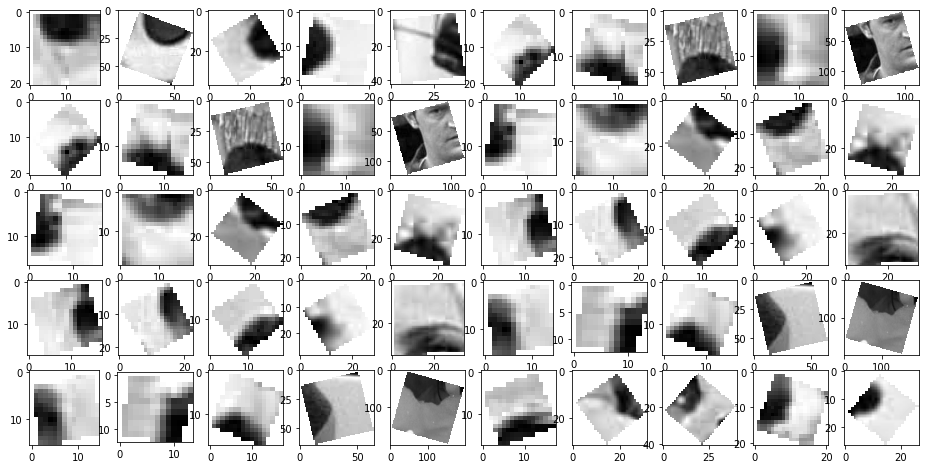

In [34]:
show_patches(0)


#### Patches for word 2

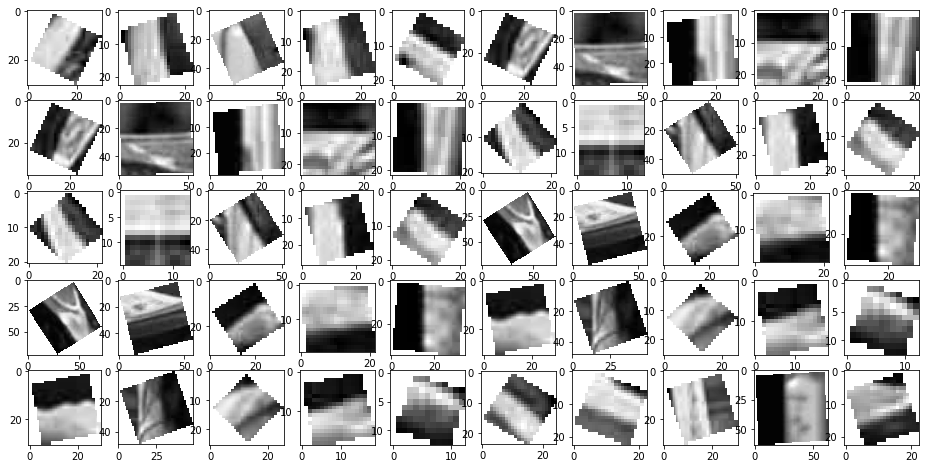

In [35]:
show_patches(1)

### 2.3.  Full frame queries [20 pts]:

In this part we will use our visual vocabulary to perform frame queries.

#### Steps

1. Map an image’s features into its bag-of-words histogram. The histogram for image *$I_j$* is a k-dimensional vector:

   $$F(I_j) = [freq_{1,j}, freq_{2,j}, ....., freq_{k,j}]$$

   where each entry *$freq_{i,j}$* counts the number of occurrences of the i-th visual word in that image, and `k` is the number of total words in the vocabulary.
   
   In other words, a single image’s list of `N` **SIFT** descriptors yields a `k-dimensional` bag of words histogram.


2. Compute similarity scores. Compare two bag-of-words histograms using the normalized scalar product:

   $$S(I_i,I_j) = \frac{F(I_i) \cdot F(I_j)}{||F(I_i)||||F(I_j)||} = \frac{1}{||F(I_i)||||F(I_j)||} \sum_{m=1}^{k} freq_{m,i}freq_{m,j}$$

   where $S()$ is the similarity score. $||F(I_i)||$ is the `L2` norm of $F(I_i)$.


3. Sort the similarity scores between a query histogram and the histograms associated with the rest of the images in the video. Pull up the images associated with the `M` most similar examples.


4. After testing your code for bag-of-words visual search, choose 3 diﬀerent frames from the entire video dataset to serve as queries. 


5. Display the `M=5` most similar frames to each of these queries (in rank order) based on the normalized scalar product between their bag of words histograms. 


6. Explain the results in your answer sheet.

#### Deliverables

- [x] The function `calculate_bag_of_words_histogram` should be included when you export `ps4.py`.
- [x] The function `caculate_normalized_scalar_product` should be included when you export `ps4.py`.
- [x] Display `3` different query frames and the `M=5` most similar frames from the video dataset (don't include the query in the results) in your answer sheet.
- [x] Explain the results in your answer sheet.

In [18]:
def calculate_bag_of_words_histogram(vocabulary, descriptors):
    """ Calculate the bag-of-words histogram for the given frame descriptors.
    
    Inputs:
    - vocabulary: kxd array representing a visual vocabulary
    - descriptors: nxd array of frame descriptors
    
    Outputs:
    - histogram: k-dimensional bag-of-words histogram
    """
    k = vocabulary.shape[0]
    histogram = np.zeros((k,), dtype="int64")
    dists = dist2(descriptors, vocabulary)
    for desc_dists in dists:
        histogram[np.argmin(desc_dists)] += 1
    return histogram

In [19]:
def caculate_normalized_scalar_product(hist1, hist2):
    """
    Calculate the normalized scalar product between two histograms.
    
    Inputs:
    - hist1: k-dimensional array
    - hist2: k-dimensional array
    
    Outputs:
    - score: the normalized scalar product described above
    """
    n1 = np.linalg.norm(hist1, ord=2)
    n2 = np.linalg.norm(hist2, ord=2)
    return hist1.dot(hist2) / (n1 * n2 + 1E-15)

In [24]:
# Calculate histograms
filenames = glob.glob('data/sift/*.mat')
filenames = [os.path.basename(name) for name in filenames]

total = len(filenames)
processed = 0
for filename in filenames:
    if processed % 200 == 0:
        print(f'Processed {processed} / {total}')
    mat = scipy.io.loadmat(os.path.join('data/sift/', filename))
    hist = calculate_bag_of_words_histogram(np.load('gen/vocabulary_800.npy'), mat['descriptors'])
    np.save(os.path.join('data/histograms/', filename[:-4] + '.npy'), hist)
    processed += 1

Processed 0 / 6612
Processed 200 / 6612
Processed 400 / 6612
Processed 600 / 6612
Processed 800 / 6612
Processed 1000 / 6612
Processed 1200 / 6612
Processed 1400 / 6612
Processed 1600 / 6612
Processed 1800 / 6612
Processed 2000 / 6612
Processed 2200 / 6612
Processed 2400 / 6612
Processed 2600 / 6612
Processed 2800 / 6612
Processed 3000 / 6612
Processed 3200 / 6612
Processed 3400 / 6612
Processed 3600 / 6612
Processed 3800 / 6612
Processed 4000 / 6612
Processed 4200 / 6612
Processed 4400 / 6612
Processed 4600 / 6612
Processed 4800 / 6612
Processed 5000 / 6612
Processed 5200 / 6612
Processed 5400 / 6612
Processed 5600 / 6612
Processed 5800 / 6612
Processed 6000 / 6612
Processed 6200 / 6612
Processed 6400 / 6612
Processed 6600 / 6612


In [45]:
# Display query, query histogram and 5 most similar
print('Loading histograms...')
histograms = [np.load(f'data/histograms/{fhs[i][:-4]}.npy') for i in range(total)]
for i in range(1, 4):
    print(f'Generating query {i}...')
    if not os.path.exists(f'gen/query{i}'):
        os.mkdir(f'gen/query{i}')
    i = random.randint(0, len(fhs))
    hist = histograms[i]
    query_fh = fhs[i]
    search_fhs = fhs[:i] + fhs[i + 1:]
    search_histograms = histograms[:i] + histograms[i + 1:]
    scores = []
    for j in range(len(search_histograms)):
        score = caculate_normalized_scalar_product(hist, search_histograms[j])
        scores.append((j, score))
    scores.sort(key=lambda x: x[1], reverse=True)
    scores = scores[:6]
    fig, axs = plt.subplots(1, 1, figsize=(16, 8))
    query_img = imageio.imread(f'data/frames/{query_fh[:-4]}')
    result_images = [imageio.imread(f'data/frames/{search_fhs[idx][:-4]}') for idx, score in scores]
    axs.imshow(query_img)
    fig.savefig(f'gen/query{i}/query_img.png')
    fig, axs = plt.subplots(2, 3, figsize=(16, 8))
    for r in range(2):
        for c in range(3):
            axs[r][c].imshow(result_images[r * 3 + c])
    fig.savefig(f'gen/query{i}/result_images.png')

Loading histograms...


NameError: name 'fhs' is not defined

### 2.4.  Region queries [20 pts]:

In this step we will use regions of interest within an image to query frames from the video.

#### Steps

1. Form a query from a region within a frame. Select a polygonal region interactively with the mouse, and compute a bag of words histogram from only the SIFT descriptors that fall within that region.  Optionally, you may weight it with tf-idf.

   > You may want to reuse your `select_roi.py` script here.


2. Select your favorite query regions from within 4 frames (which may be diﬀerent than those used above) to demonstrate the retrieved frames when only a portion of the SIFT descriptors are used to form a bag of words. 

   > Try to include example(s) where the same object is found in the **most similar M frames** but amidst diﬀerent objects or backgrounds, and also **include a failure case**. 

3. Explain the results, including possible reasons for the failure cases in your answer sheet.

#### Deliverables

- [x] Display the selected query region and the `M=5` most similar frames for `4` different queries in your answer sheet.
- [x] Explain the results in your answer sheet.

In [ ]:
# See gen_region_query.py
